## Raceway model for PDF shaping (894 samples)

This uses the new object oriented class for PDF shaping.

This model uses the CFD raceway data with 894 samples

## Web application 4 inputs and 3 outputs

Run interactively on the web at:

## Inputs


(2, 'i_pul_coal_inj_kg_thm')

(3, 'i_nat_gas_inj_kg_thm')

(4, 'i_nat_gas_t_k')

(5, 'i_o2_vol_perce')

## Outputs

(16, 'o_raceway_flame_temp_k')

(17, 'o_raceway_coal_burn_perce')

(18, 'o_raceway_volume_m')




In [2]:

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch

from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)




In [3]:
import PDFshapingUtils as PDF_tk

In [4]:
PDFshapingOBJ = PDF_tk.PDFshapingUtils()

In [5]:

PDFshapingOBJ.initializeImpulseGaussian()

print(PDFshapingOBJ.x_range_impulse_func )
print(PDFshapingOBJ.impulse_func_vector_vals )
print(PDFshapingOBJ.x_range_impulse_func.shape )
print(PDFshapingOBJ.impulse_func_vector_vals.shape )
 
print( sum(PDFshapingOBJ.impulse_func_vector_vals) )      ## should add up to 100 (i.e. 1.0 prob density)


tensor([-20.0000, -19.9900, -19.9800,  ...,  19.9700,  19.9800,  19.9900])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([4000])
torch.Size([4000])
tensor(100.0000)


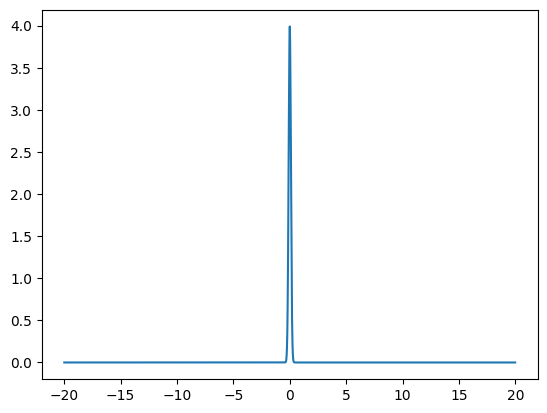

In [6]:

plt.plot(PDFshapingOBJ.x_range_impulse_func, PDFshapingOBJ.impulse_func_vector_vals)
plt.show()


## RUN KDE test

In [7]:
## PDFshapingOBJ.test_torchKDE_with_fake_data()

## Load Data

In [8]:

PDFshapingOBJ.read_csv_file_with_pandas('CFD.11.2023.csv')


In [9]:

PDFshapingOBJ.CFD_raw_data


index  i_h2_inj_kg_thm  i_pul_coal_inj_kg_thm  i_nat_gas_inj_kg_thm  \
0        1                0                      0                  37.9   
1        2                0                      0                  37.9   
2        3                0                      0                  37.9   
3        4                0                      0                  37.9   
4        5                0                      0                  70.0   
..     ...              ...                    ...                   ...   
889    890               20                      0                  70.0   
890    891               30                      0                  60.0   
891    892               10                      0                 100.0   
892    893               20                      0                  90.0   
893    894               30                      0                  80.0   

     i_nat_gas_t_k  i_o2_vol_perce  i_bf_windrate_nm3_hr  i_hb_moist_g_nm3  \
0              300              21            308750.365            12.154   
1              300              24            308750.365            12.154   
2              300              27            308750.365            12.154   
3              300              30            308750.365            12.154   
4              300              21            308750.365            12.154   
..             ...             ...                   ...               ...   
889            300              27            308750.365            12.154   
890            300              27            308750.365            12.154   
891            300              27            308750.365            12.154   
892            300              27            308750.365            12.154   
893            300              27            308750.365            12.154   

     i_hot_blast_press_pa  i_hot_blast_temp_k  ...  o_shaft_co_utiliz  \
0                359906.3            1459.817  ...           47.20085   
1                359906.3            1459.817  ...           49.15851   
2                359906.3            1459.817  ...           49.30602   
3                359906.3            1459.817  ...           47.22992   
4                359906.3            1459.817  ...           46.66340   
..                    ...                 ...  ...                ...   
889              359906.3            1459.817  ...           48.11546   
890              359906.3            1459.817  ...           47.40511   
891              359906.3            1459.817  ...           48.24004   
892              359906.3            1459.817  ...           47.21544   
893              359906.3            1459.817  ...           46.50030   

     o_shaft_h2_utiliz  o_shaft_top_gas_temp_c  o_shaft_press_drop_pa  \
0             42.99392                118.8785              108434.33   
1             44.99764                 95.7563              108381.02   
2             44.48147                 84.8519              112232.83   
3             46.37194                 66.3779              118634.40   
4             41.83302                130.4139              106947.64   
..                 ...                     ...                    ...   
889           42.78430                122.0079              137423.80   
890           41.99833                132.4238              146622.00   
891           41.11932                121.1668              128838.00   
892           39.43614                129.2255              129115.30   
893           41.24624                149.5792              157703.10   

     o_shaft_coke_rate_kg_thm  o_shaft_cohesive_zone_tip_height_m  \
0                   462.73655                            31.83963   
1                   480.82105                            31.83963   
2                   500.10050                            31.75963   
3                   521.58650                            31.55962   
4                   422.57185                           

In [10]:

PDFshapingOBJ.print_headers_list()


['index', 'i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_ore_moisture_weight_perce', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_production_rate_thmperday', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
30
(0, 'index')
(1, 'i_h2_inj_kg_thm')
(2, 'i_pul_coal_inj_kg_thm')
(3, 'i_nat_gas_inj_kg_thm')
(4, 'i_nat_gas_t_k')
(5, 'i_o2_vol_perce')
(6, 'i_bf_windrate_nm3_hr')
(7, 'i_hb_moist_g_nm3')
(8, 'i_hot_blast_press_pa')
(9, 'i_hot_blast_temp_k')
(10, 'i_ore_moisture_weight_perce')
(11, 'i_coke_weight_kg')
(12, 

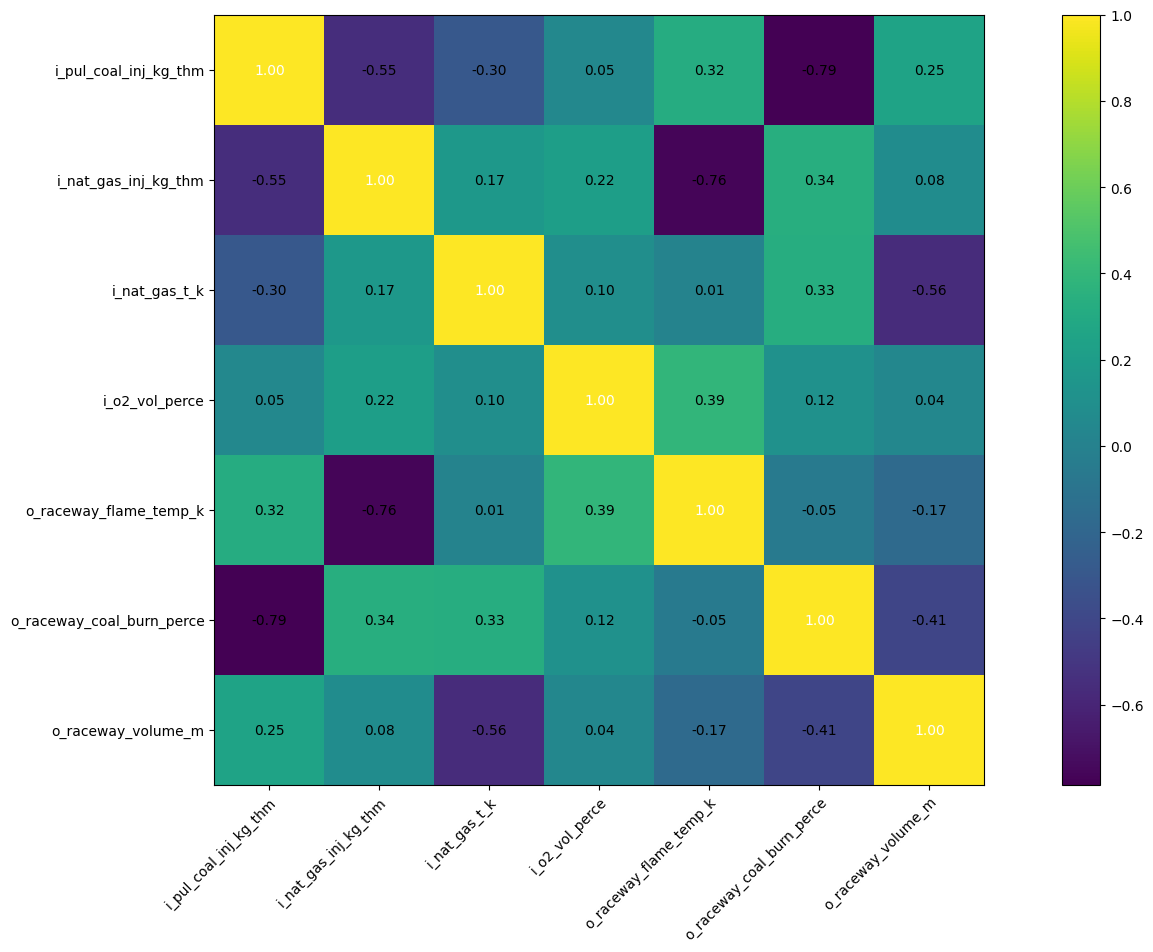

In [11]:

PDFshapingOBJ.list_of_selected_column_names = ['i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 
                    'i_nat_gas_t_k', 'i_o2_vol_perce', 'o_raceway_flame_temp_k', 
                    'o_raceway_coal_burn_perce', 'o_raceway_volume_m']

PDFshapingOBJ.print_correlation_coefficients()


In [12]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[  1.           0.           0.         ...   0.1941631    0.0438327
    0.5448123 ]
 [  2.           0.           0.         ...   0.2186134    0.04034286
    0.5149459 ]
 [  3.           0.           0.         ...   0.2353341    0.03772617
    0.4849808 ]
 ...
 [892.          10.           0.         ...   0.2015624    0.1179911
    0.4641767 ]
 [893.          20.           0.         ...   0.1906331    0.1420678
    0.4541806 ]
 [894.          30.           0.         ...   0.1820335    0.1569839
    0.4515486 ]]
(894, 30)



## Select inputs and outputs


In [13]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs=[2, 3, 4, 5] , 
                   outputs=[16, 17, 18]   
)


4
3


In [14]:



print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)



(894, 4)
(894, 3)


In [15]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [16]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(715, 4)
(179, 4)
(715, 3)
(179, 3)


In [17]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [18]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [19]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl


## NN architectures

In [87]:

#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(4, 3) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(4, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 3)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(4, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 3)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled





In [88]:

#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(4, 3)       
        
        ## F2
        self.f2_linear1 = nn.Linear(4, 30)
        self.f2_act1    = nn.GELU()                   ## Tanh()                       
        self.f2_linear2 = nn.Linear(30, 20)  
        self.f2_act2    = nn.GELU()                   ## Tanh() 
        self.f2_linear3 = nn.Linear(20, 10)
        self.f2_act3    = nn.GELU()                   ## Tanh() 
        self.f2_linear4 = nn.Linear(10, 3)
        self.f2_dropout = nn.Dropout(0.10)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        
        f2 = self.f2_linear2(f2)
        f2 = self.f2_act2(f2)
        f2 = self.f2_dropout(f2)
        
        f2 = self.f2_linear3(f2)
        f2 = self.f2_act3(f2)
        f2 = self.f2_dropout(f2)
        
        f2 = self.f2_linear4(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    



## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear


In [89]:

def fit_y_scaled(num_epochs, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(
            torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()   )
            )
        )
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,           PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy()  ))
    


In [90]:

PDFshapingOBJ.the_string           = "No_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "shaft"
PDFshapingOBJ.learning_rate        = 0.000005
PDFshapingOBJ.N_EPOCHS             = 6000



0  loss=  tensor(1.8420, grad_fn=<MseLossBackward0>)
200  loss=  tensor(1.4944, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.8142, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.5114, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.4504, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.4333, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.5098, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.4607, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.3113, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.3340, grad_fn=<MseLossBackward0>)
2000  loss=  tensor(0.2625, grad_fn=<MseLossBackward0>)
2200  loss=  tensor(0.3807, grad_fn=<MseLossBackward0>)
2400  loss=  tensor(0.2753, grad_fn=<MseLossBackward0>)
2600  loss=  tensor(0.1439, grad_fn=<MseLossBackward0>)
2800  loss=  tensor(0.3521, grad_fn=<MseLossBackward0>)
3000  loss=  tensor(0.1489, grad_fn=<MseLossBackward0>)
3200  loss=  tensor(0.2618, grad_fn=<MseLossBackward0>)
3400  loss=  tensor(0.2284, grad_fn=<MseLossBackward0>)

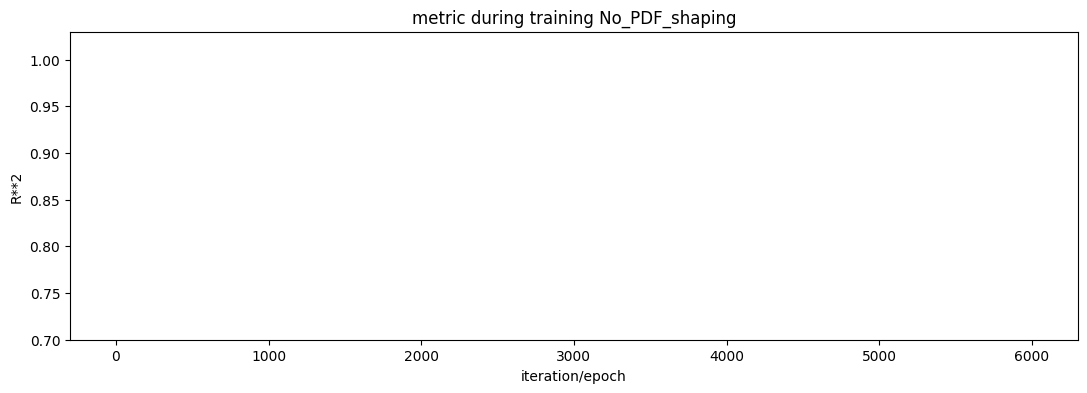

Training loss: tensor(0.2147, grad_fn=<MseLossBackward0>)
Training R**2: 0.5679807473382007
Test loss - scaled: tensor(0.2185, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(967.4919, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.5660613127932146
Testing R**2 - descaled: 0.566061400061622
*****
*****
Testing R**2 - Output: 0 o_raceway_flame_temp_k 0.92782939849832
*****
*****
Testing R**2 - Output: 1 o_raceway_coal_burn_perce 0.863291012101806
*****
*****
Testing R**2 - Output: 2 o_raceway_volume_m -0.09293620452074958


In [91]:

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

opt = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(PDFshapingOBJ.N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,         PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,       PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))

PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [92]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])


**************************************************
preds, real
(2526.6404, 2583.367)
(89.435974, 91.07791)
(0.22059321, 0.2167488)
**************************************************
preds, real
(2343.9517, 2344.956)
(86.80711, 86.50982)
(0.21808313, 0.2167488)
**************************************************
preds, real
(2600.8364, 2621.923)
(102.73781, 100.0)
(0.19031651, 0.1965359)
**************************************************
preds, real
(2223.8909, 2175.781)
(85.474144, 83.188614)
(0.21452552, 0.2167488)
**************************************************
preds, real
(2161.3076, 2193.05)
(100.14455, 100.0)
(0.21363805, 0.2296868)
**************************************************
preds, real
(2317.4434, 2347.552)
(98.77377, 100.0)
(0.2136529, 0.1965359)
**************************************************
preds, real
(2260.7363, 2303.987)
(98.33448, 100.0)
(0.21724793, 0.1965359)
**************************************************
preds, real
(2292.547, 2267.999)
(90.62867, 87.4

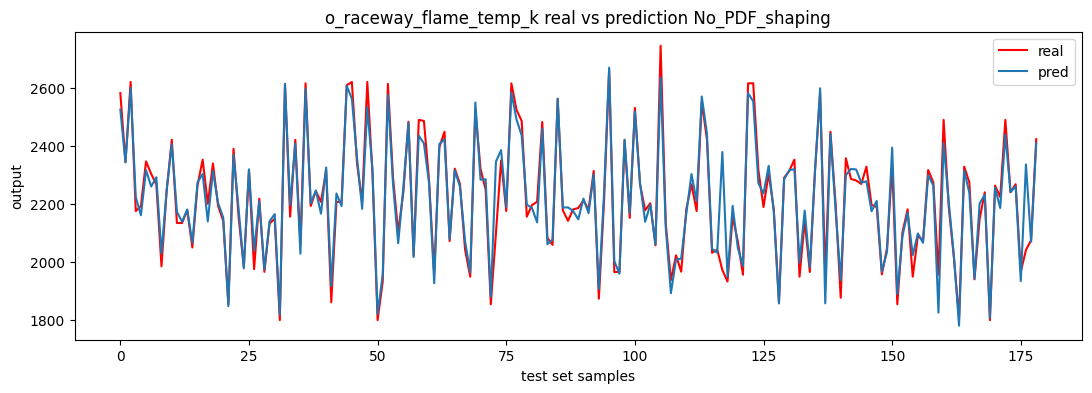

/Users/user/Desktop/DOE_CIVS/experiments/2023may/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


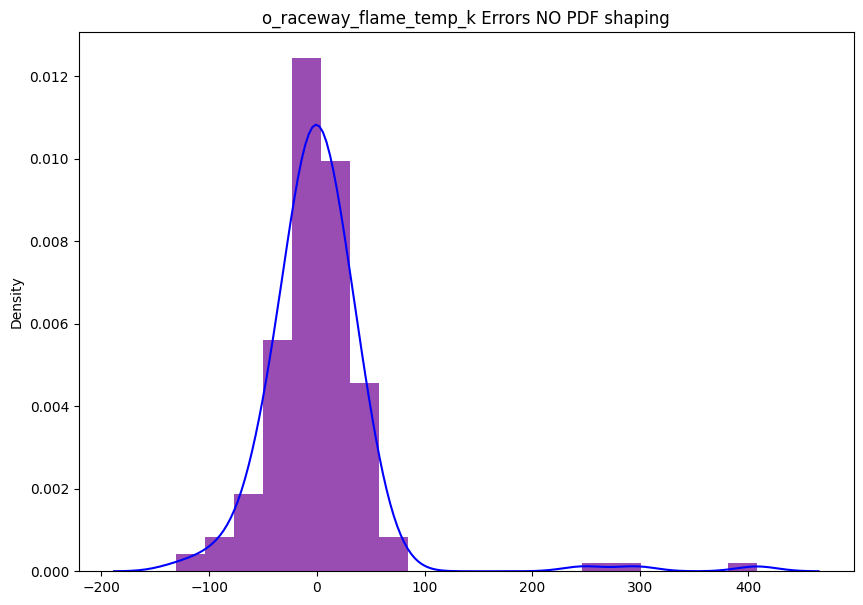

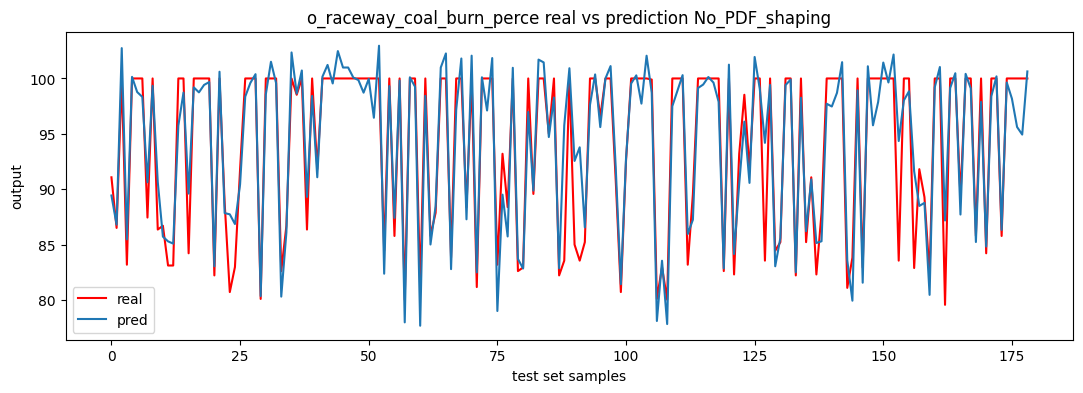

/Users/user/Desktop/DOE_CIVS/experiments/2023may/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


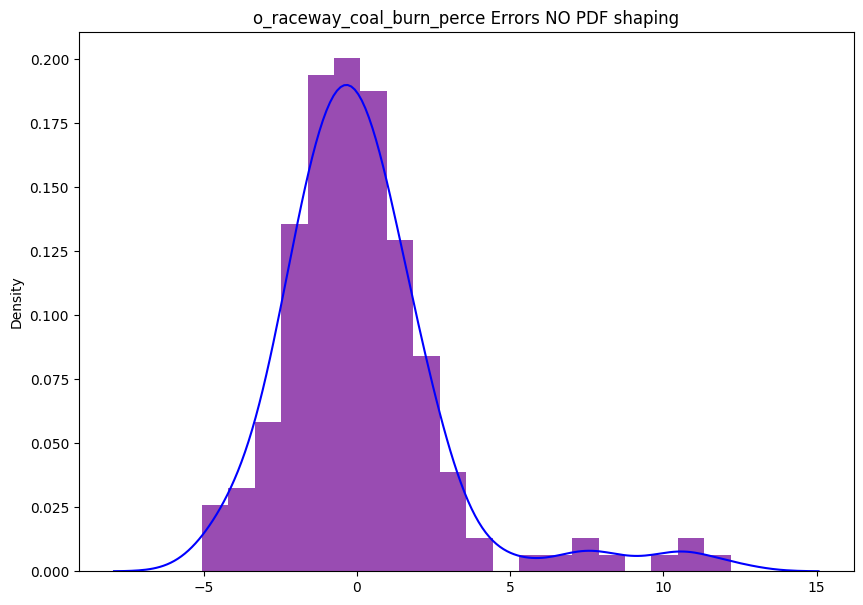

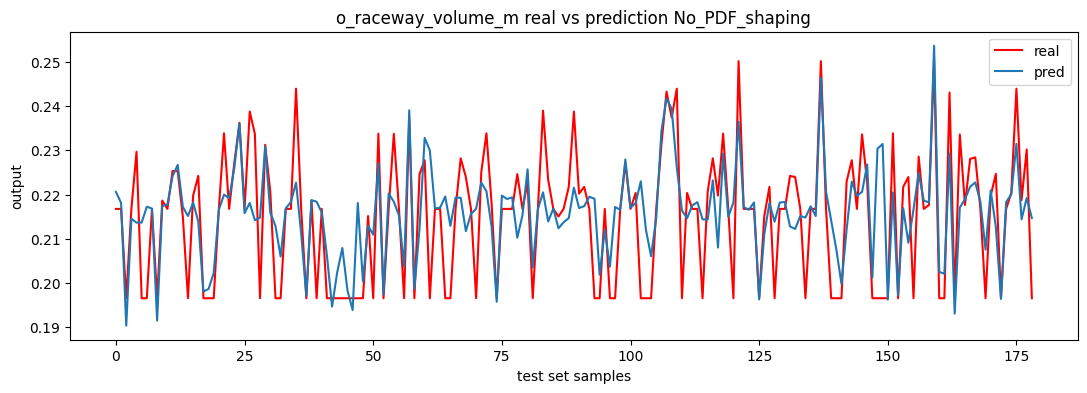

/Users/user/Desktop/DOE_CIVS/experiments/2023may/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


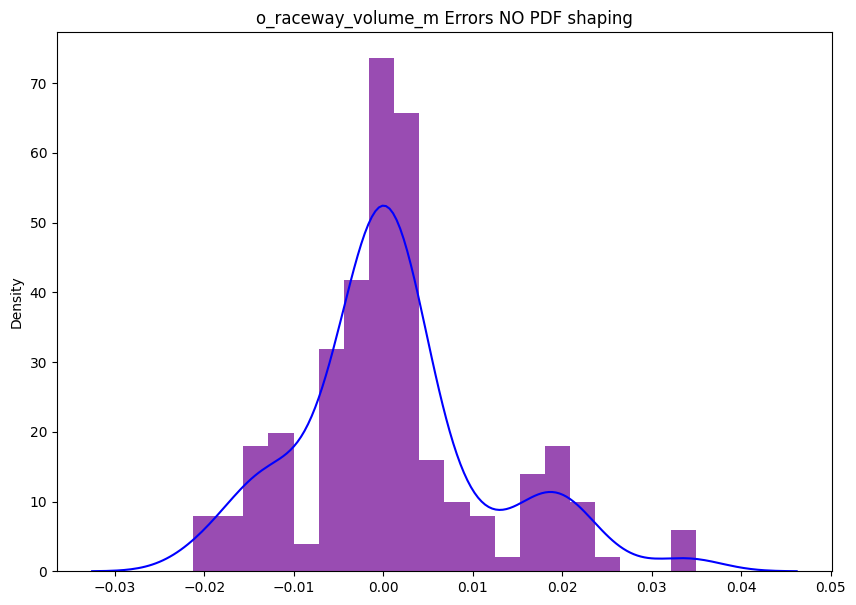

In [93]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )



## Results for g(x) = F1(x) + F2(x) with PDF shaping

F1 = Linear

F2 = Nonlinear


In [94]:

def fit_y_scaled_PDF(num_epochs, num_epochs_pdf, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
      
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(r2_avg.detach().numpy())
        
        
    ## opt = torch.optim.Adam(   model.parameters(), lr=learning_rate_pdfcontrol   )    
        
    for epoch in range(num_epochs_pdf):
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
       
        
        error     = pred_scaled.float() - PDFshapingOBJ.y_train_tr_scaled.float()        ## 894  x 6
        basisFunc = PDFshapingOBJ.train_multiple_kernels_per_output( error )             ## 4000 x 6
        
        diff = ( basisFunc.float() - PDFshapingOBJ.impulse_func_vector_vals.unsqueeze(1).float() )  ## 4000 x 6

        
        loss = torch.mean(   (   diff  )**2    )  
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        

        print(epoch, " loss= ", loss)
        if epoch % 50 == 0:
            print(error.shape)
            print(basisFunc.shape)
            PDFshapingOBJ.print_errors_kdes(  error, basisFunc )
            print(PDFshapingOBJ.impulse_func_vector_vals.shape)
      

        r2_avg = torch.mean(torch.tensor(
                 r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
        
        
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,       PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy() ))
    


In [95]:

PDFshapingOBJ.the_string           = "With_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "shaft"

PDFshapingOBJ.N_EPOCHS             = 4000
PDFshapingOBJ.N_EPOCHS_PDF         = 4000


0  loss=  tensor(1.2788, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.8396, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.4424, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.4761, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.3754, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.2315, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.4462, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.1918, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.2828, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.4344, grad_fn=<MseLossBackward0>)
2000  loss=  tensor(0.2942, grad_fn=<MseLossBackward0>)
2200  loss=  tensor(0.1603, grad_fn=<MseLossBackward0>)
2400  loss=  tensor(0.1767, grad_fn=<MseLossBackward0>)
2600  loss=  tensor(0.4101, grad_fn=<MseLossBackward0>)
2800  loss=  tensor(0.2379, grad_fn=<MseLossBackward0>)
3000  loss=  tensor(0.2645, grad_fn=<MseLossBackward0>)
3200  loss=  tensor(0.3119, grad_fn=<MseLossBackward0>)
3400  loss=  tensor(0.2337, grad_fn=<MseLossBackward0>)

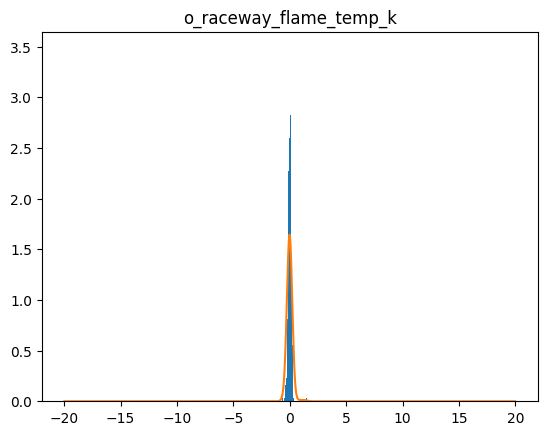

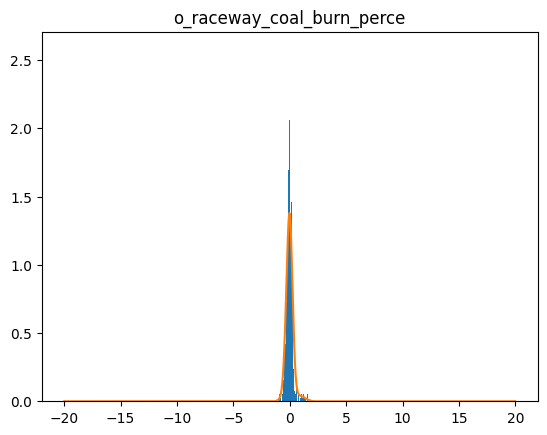

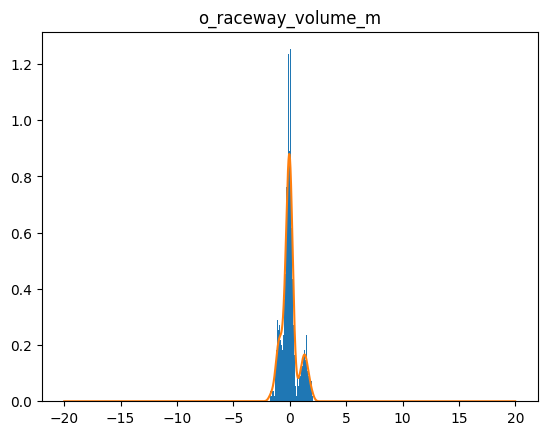

torch.Size([4000])
1  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
4  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
5  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
6  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
7  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
8  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
9  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
10  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
11  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
12  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
13  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
14  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
15  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
16  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
17  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
18  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
19  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
20  loss=  tensor(0.0

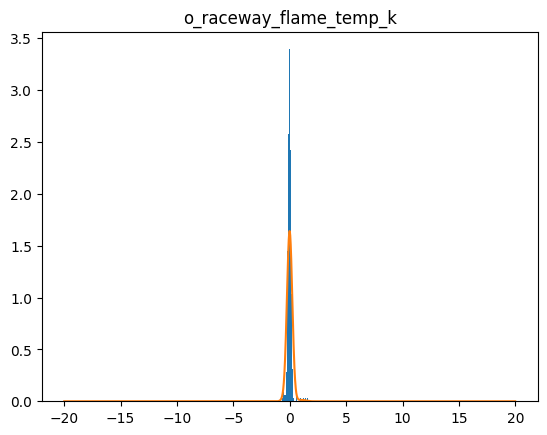

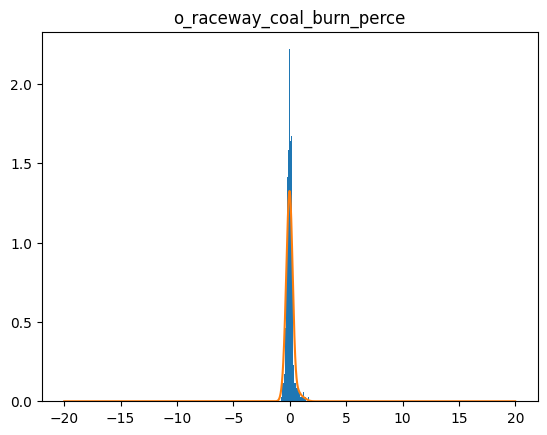

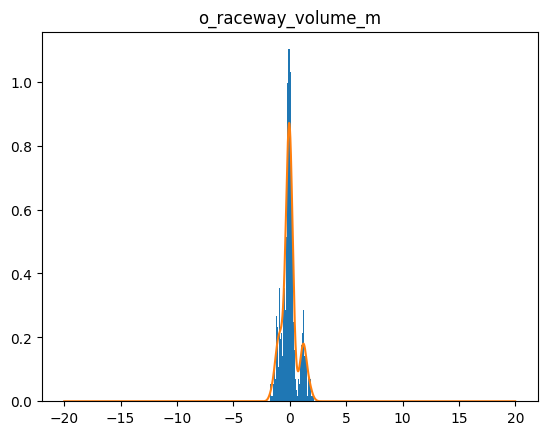

torch.Size([4000])
51  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
52  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
53  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
54  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
55  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
56  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
57  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
58  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
59  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
60  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
61  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
62  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
63  loss=  tensor(0.0324, grad_fn=<MeanBackward0>)
64  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
65  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
66  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
67  loss=  tensor(0.0324, grad_fn=<MeanBackward0>)
68  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
69  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
70  loss=  t

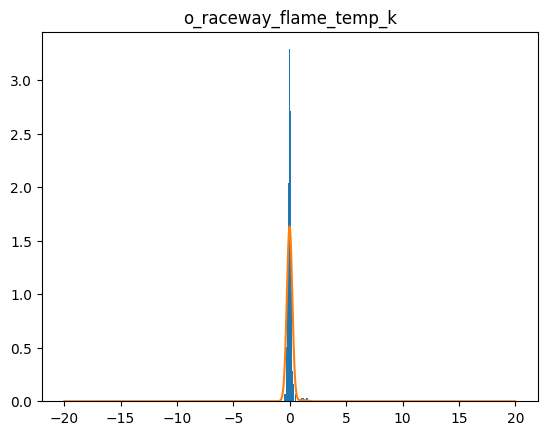

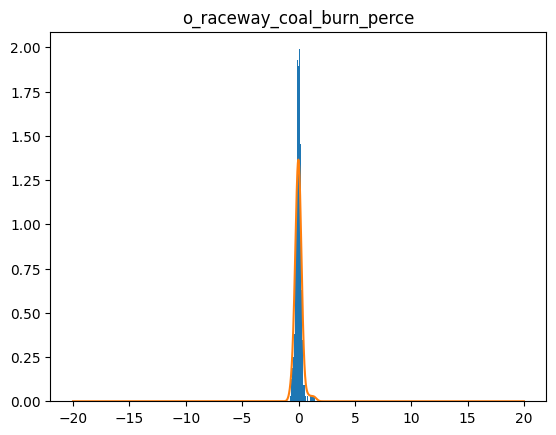

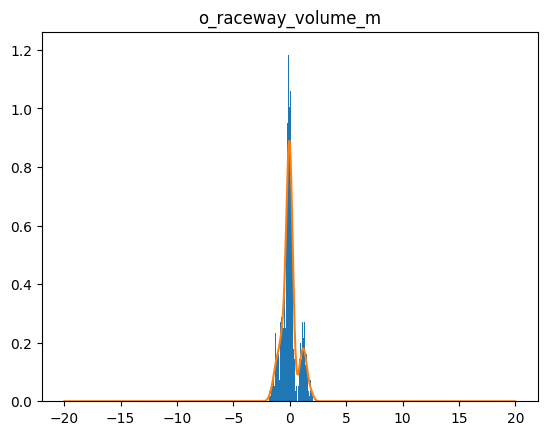

torch.Size([4000])
101  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
102  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
103  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
104  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
105  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
106  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
107  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
108  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
109  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
110  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
111  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
112  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
113  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
114  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
115  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
116  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
117  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
118  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
119  loss=  tensor(0.0319, grad_fn=<MeanBackw

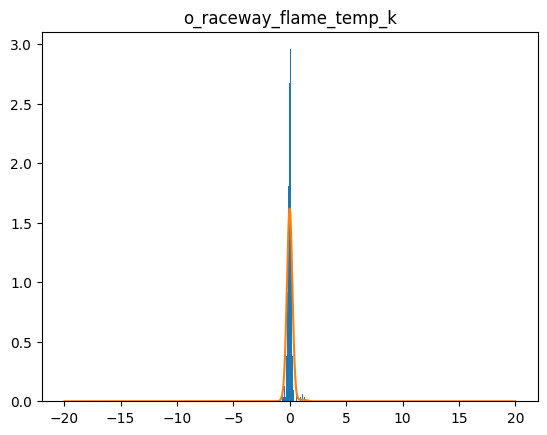

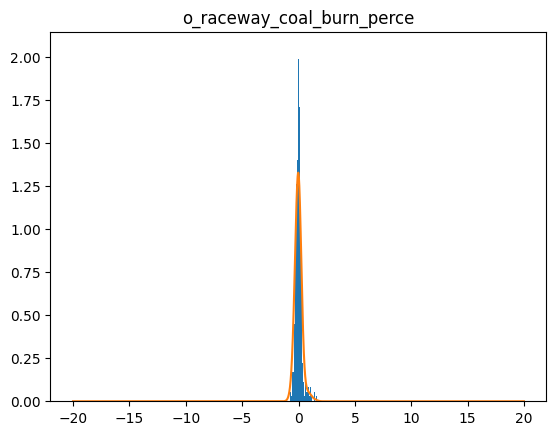

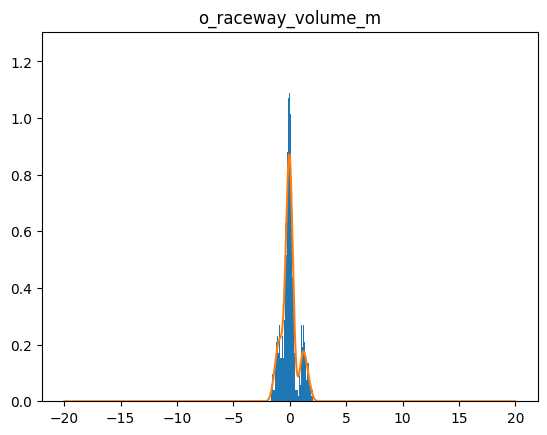

torch.Size([4000])
151  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
152  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
153  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
154  loss=  tensor(0.0325, grad_fn=<MeanBackward0>)
155  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
156  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
157  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
158  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
159  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
160  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
161  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
162  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
163  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
164  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
165  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
166  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
167  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
168  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
169  loss=  tensor(0.0323, grad_fn=<MeanBackw

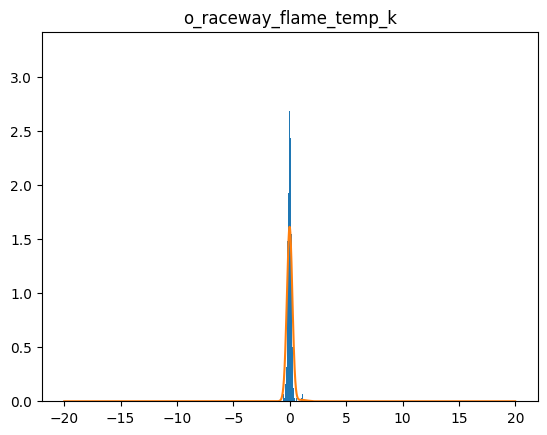

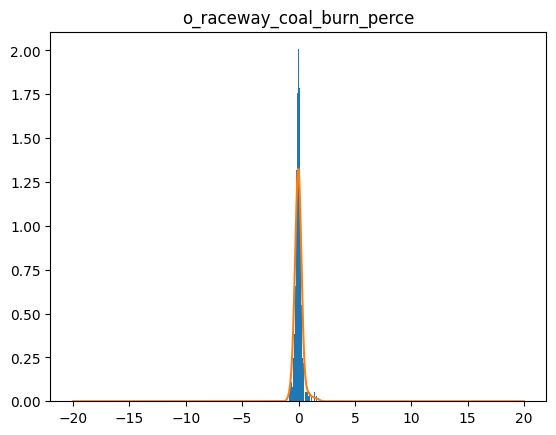

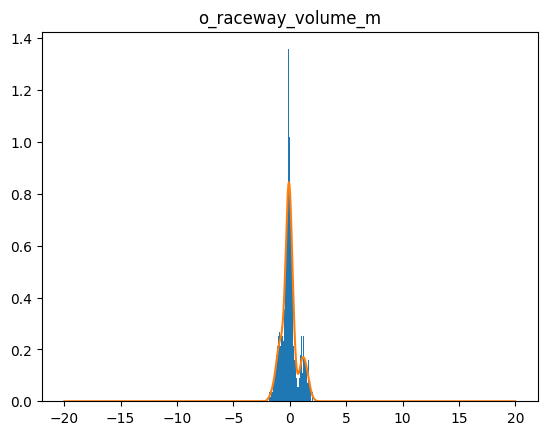

torch.Size([4000])
201  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
202  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
203  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
204  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
205  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
206  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
207  loss=  tensor(0.0324, grad_fn=<MeanBackward0>)
208  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
209  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
210  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
211  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
212  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
213  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
214  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
215  loss=  tensor(0.0326, grad_fn=<MeanBackward0>)
216  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
217  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
218  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
219  loss=  tensor(0.0320, grad_fn=<MeanBackw

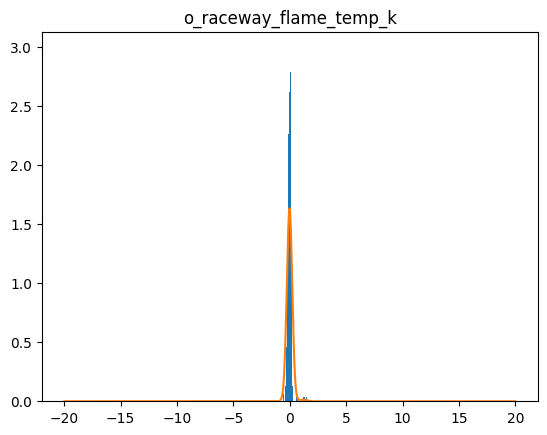

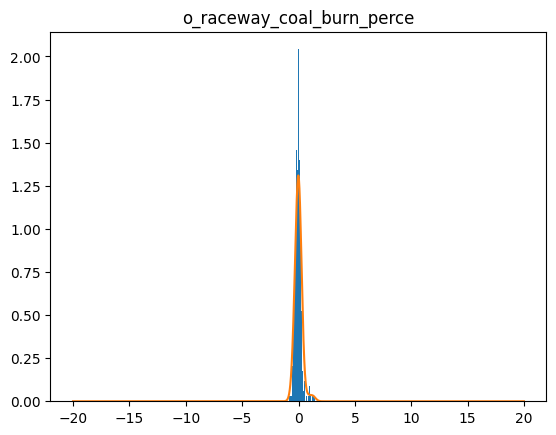

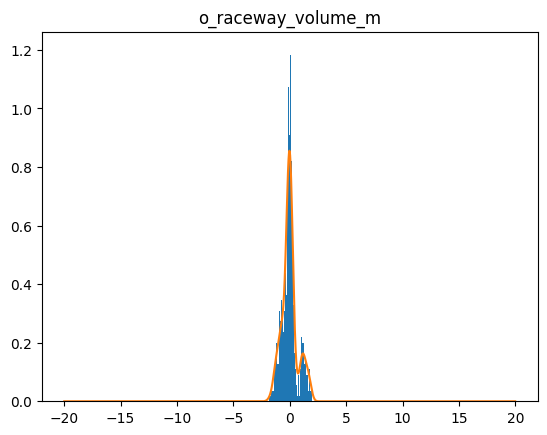

torch.Size([4000])
251  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
252  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
253  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
254  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
255  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
256  loss=  tensor(0.0324, grad_fn=<MeanBackward0>)
257  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
258  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
259  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
260  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
261  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
262  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
263  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
264  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
265  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
266  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
267  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
268  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
269  loss=  tensor(0.0317, grad_fn=<MeanBackw

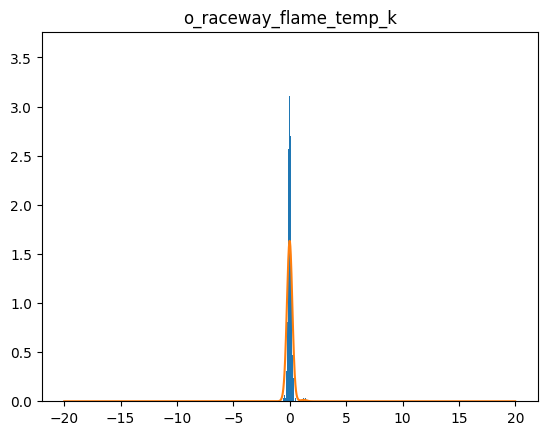

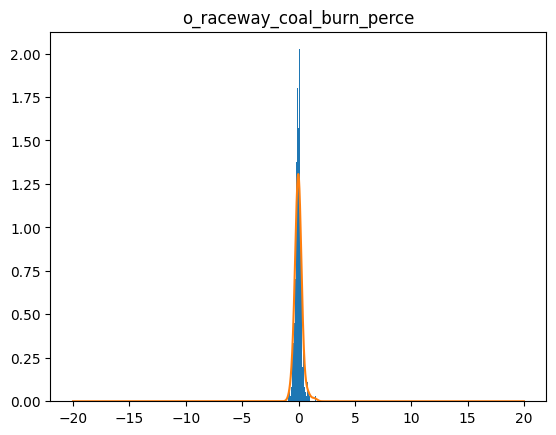

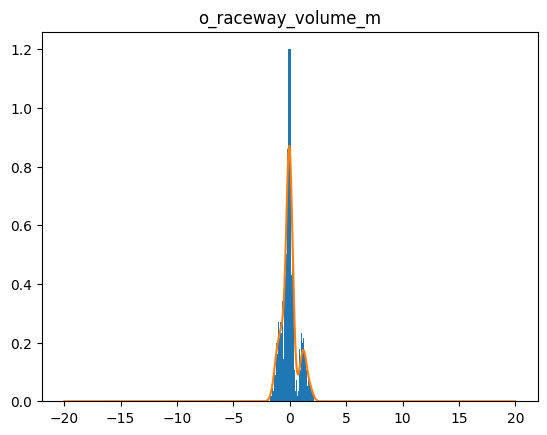

torch.Size([4000])
301  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
302  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
303  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
304  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
305  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
306  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
307  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
308  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
309  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
310  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
311  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
312  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
313  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
314  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
315  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
316  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
317  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
318  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
319  loss=  tensor(0.0317, grad_fn=<MeanBackw

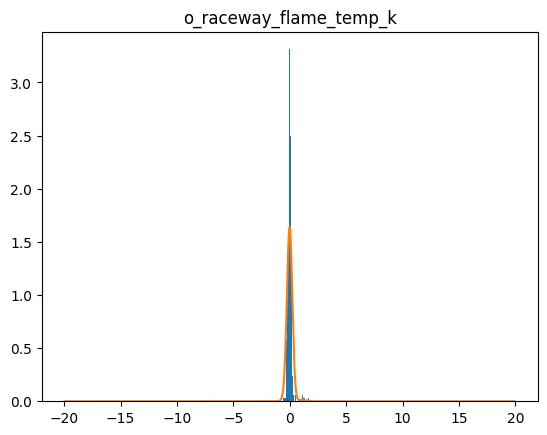

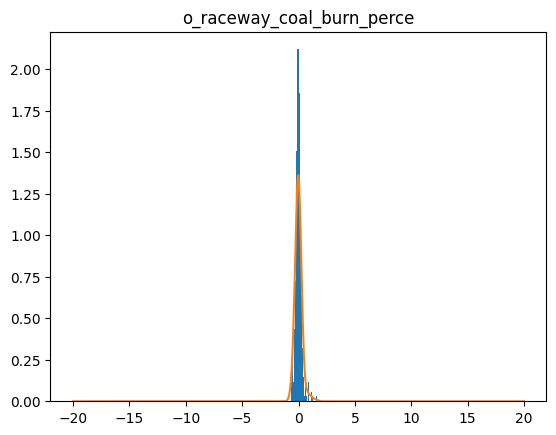

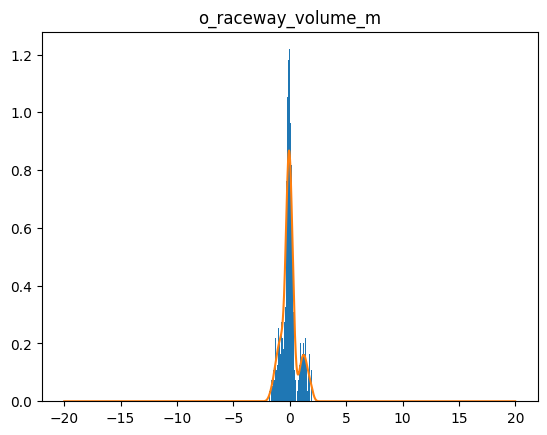

torch.Size([4000])
351  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
352  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
353  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
354  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
355  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
356  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
357  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
358  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
359  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
360  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
361  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
362  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
363  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
364  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
365  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
366  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
367  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
368  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
369  loss=  tensor(0.0318, grad_fn=<MeanBackw

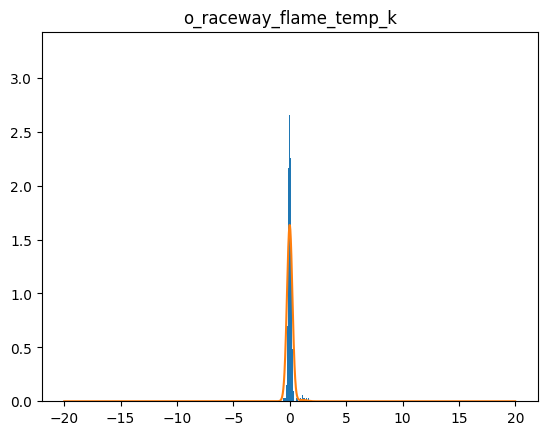

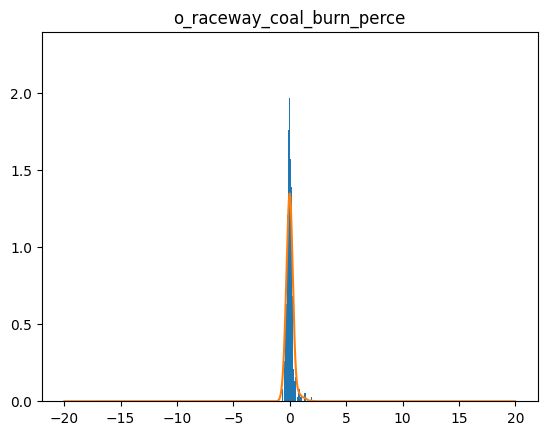

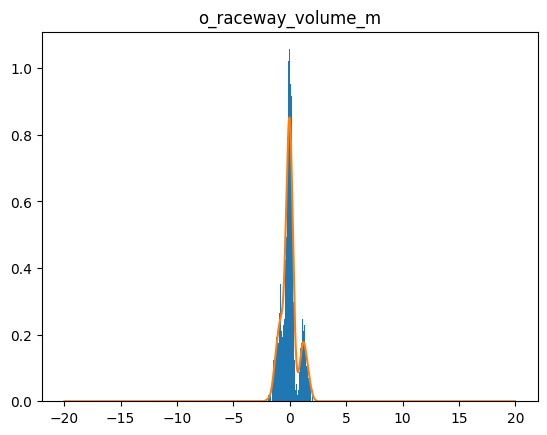

torch.Size([4000])
401  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
402  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
403  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
404  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
405  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
406  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
407  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
408  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
409  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
410  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
411  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
412  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
413  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
414  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
415  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
416  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
417  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
418  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
419  loss=  tensor(0.0323, grad_fn=<MeanBackw

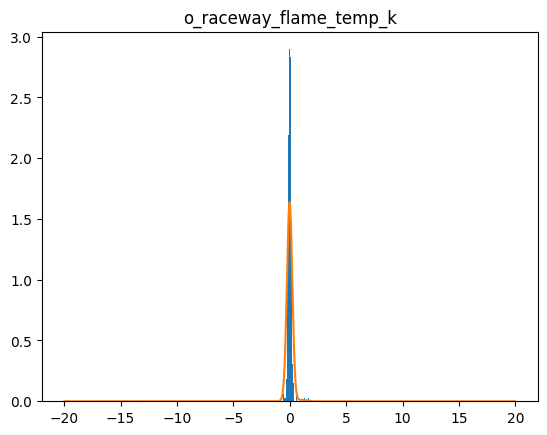

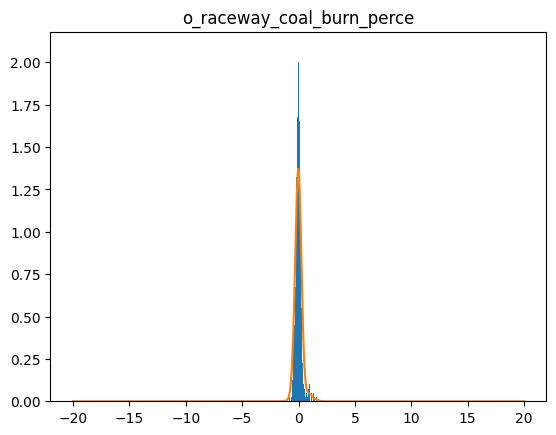

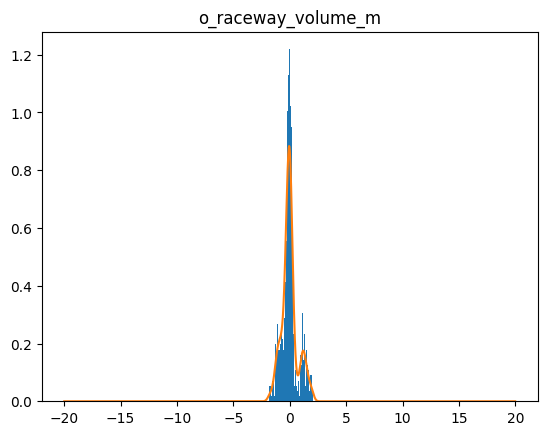

torch.Size([4000])
451  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
452  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
453  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
454  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
455  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
456  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
457  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
458  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
459  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
460  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
461  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
462  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
463  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
464  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
465  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
466  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
467  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
468  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
469  loss=  tensor(0.0317, grad_fn=<MeanBackw

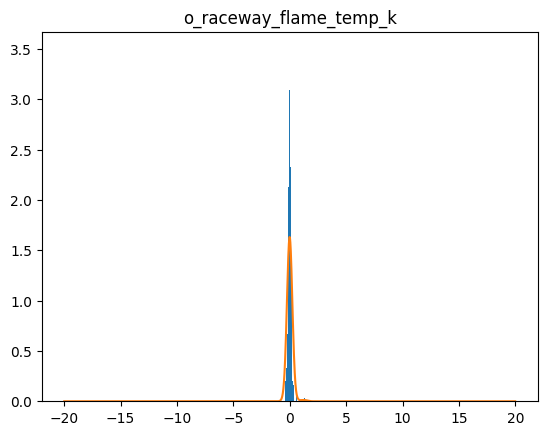

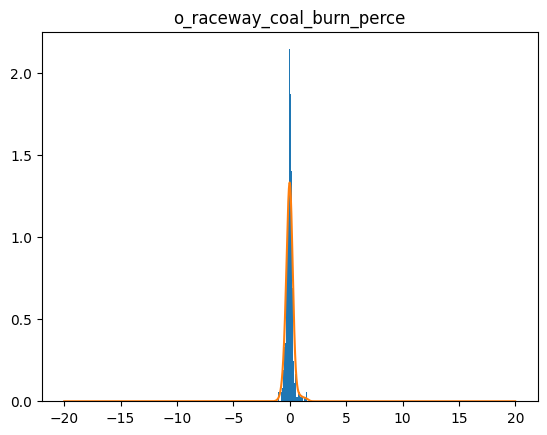

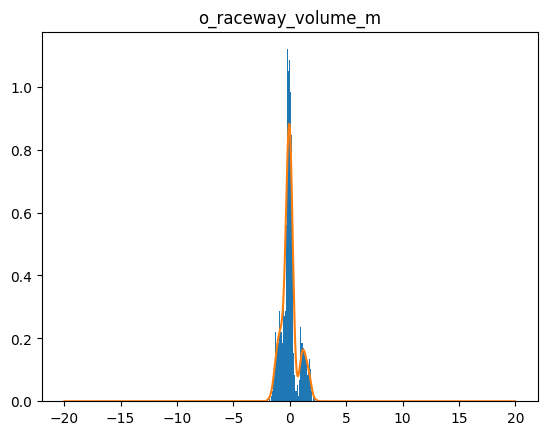

torch.Size([4000])
501  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
502  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
503  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
504  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
505  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
506  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
507  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
508  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
509  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
510  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
511  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
512  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
513  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
514  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
515  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
516  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
517  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
518  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
519  loss=  tensor(0.0318, grad_fn=<MeanBackw

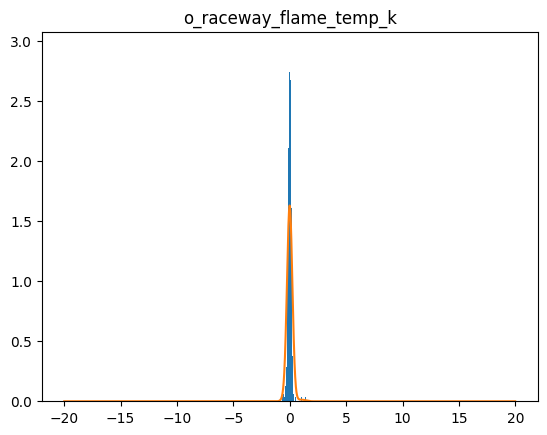

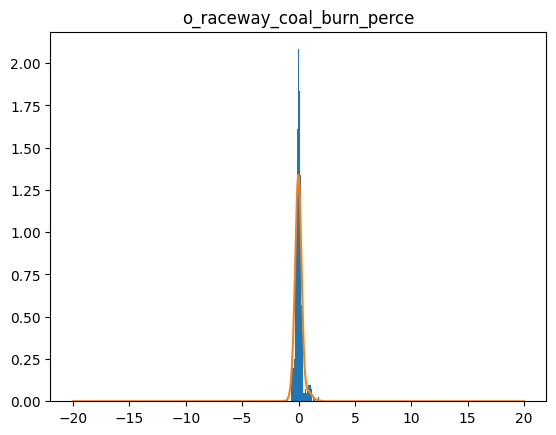

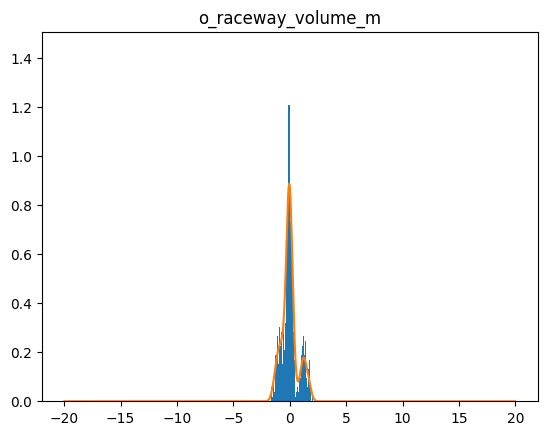

torch.Size([4000])
551  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
552  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
553  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
554  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
555  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
556  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
557  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
558  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
559  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
560  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
561  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
562  loss=  tensor(0.0324, grad_fn=<MeanBackward0>)
563  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
564  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
565  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
566  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
567  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
568  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
569  loss=  tensor(0.0316, grad_fn=<MeanBackw

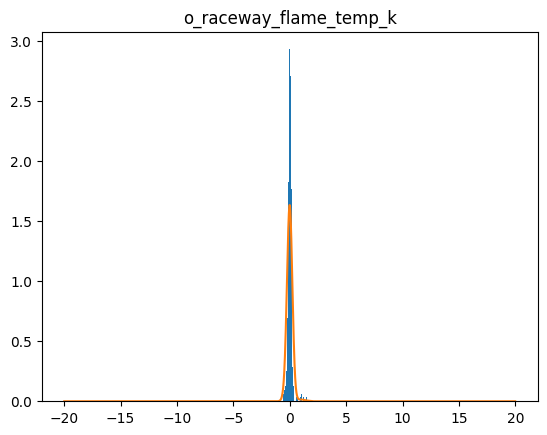

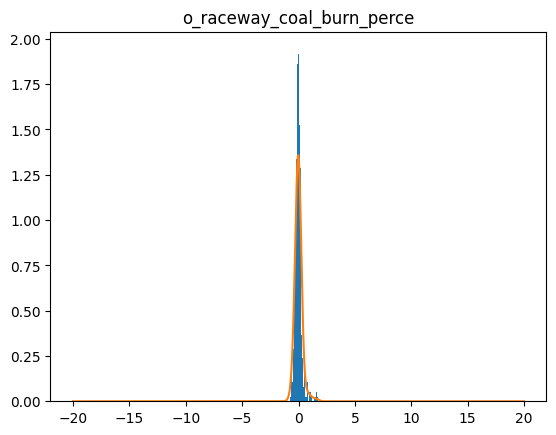

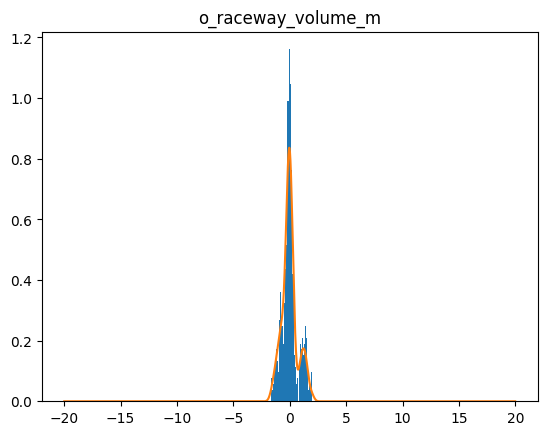

torch.Size([4000])
601  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
602  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
603  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
604  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
605  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
606  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
607  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
608  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
609  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
610  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
611  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
612  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
613  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
614  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
615  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
616  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
617  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
618  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
619  loss=  tensor(0.0317, grad_fn=<MeanBackw

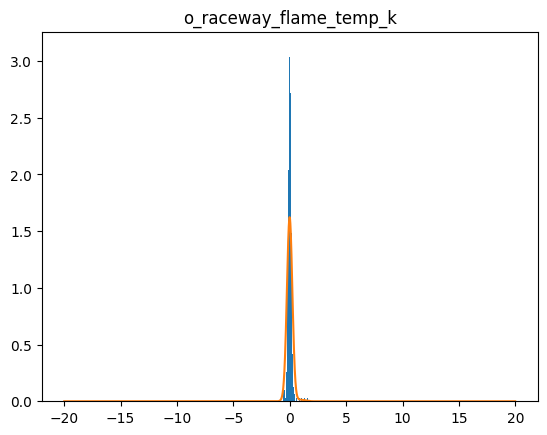

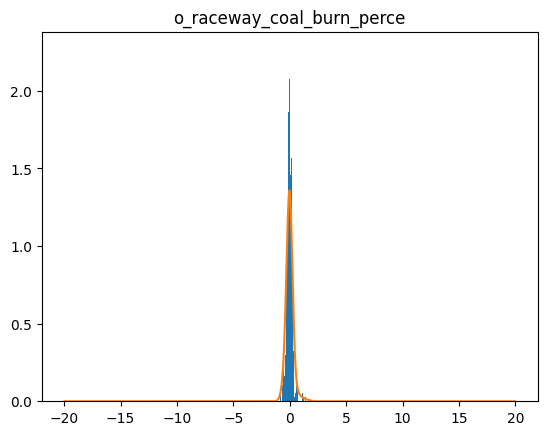

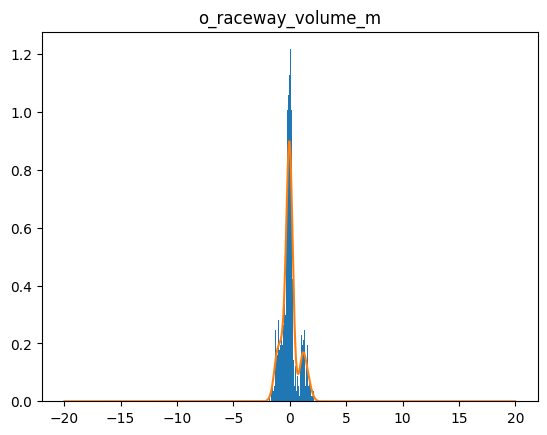

torch.Size([4000])
651  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
652  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
653  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
654  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
655  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
656  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
657  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
658  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
659  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
660  loss=  tensor(0.0325, grad_fn=<MeanBackward0>)
661  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
662  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
663  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
664  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
665  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
666  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
667  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
668  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
669  loss=  tensor(0.0316, grad_fn=<MeanBackw

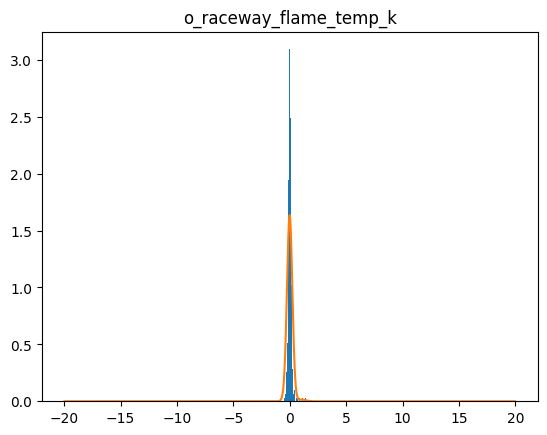

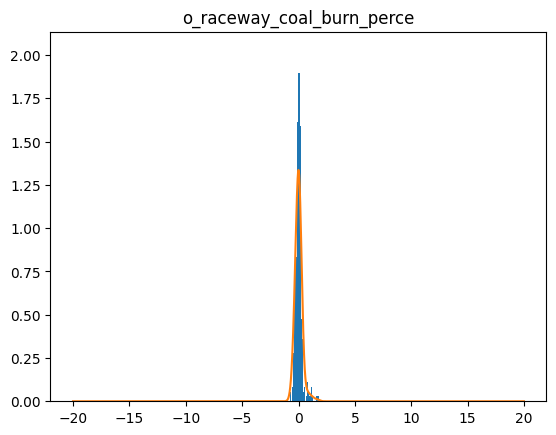

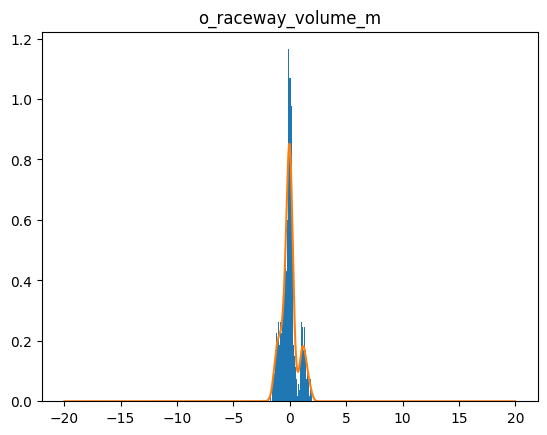

torch.Size([4000])
701  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
702  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
703  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
704  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
705  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
706  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
707  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
708  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
709  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
710  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
711  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
712  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
713  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
714  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
715  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
716  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
717  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
718  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
719  loss=  tensor(0.0321, grad_fn=<MeanBackw

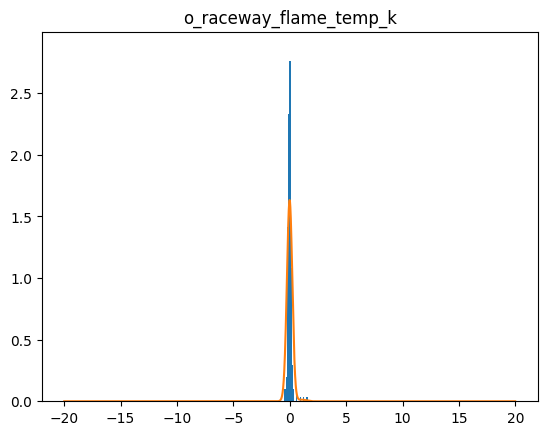

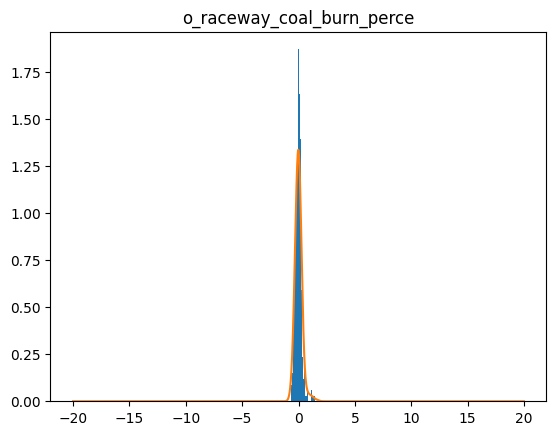

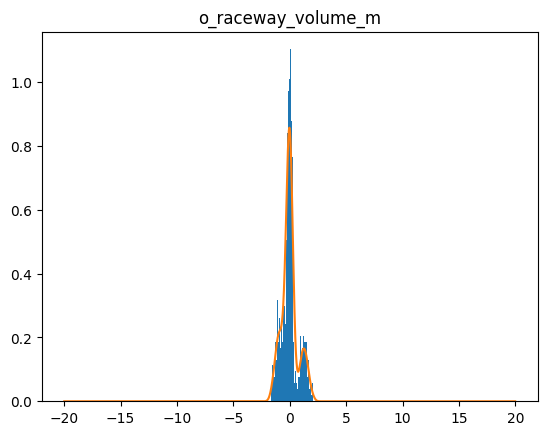

torch.Size([4000])
751  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
752  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
753  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
754  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
755  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
756  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
757  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
758  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
759  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
760  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
761  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
762  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
763  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
764  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
765  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
766  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
767  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
768  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
769  loss=  tensor(0.0317, grad_fn=<MeanBackw

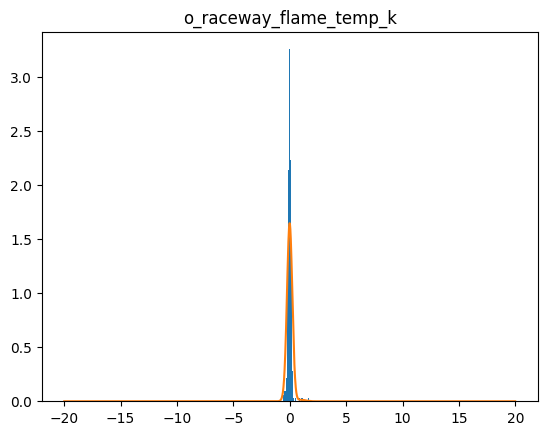

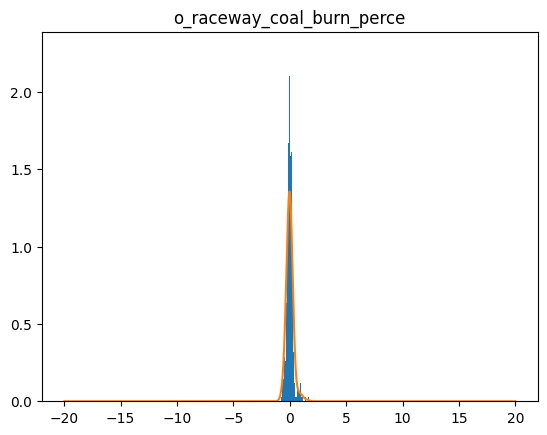

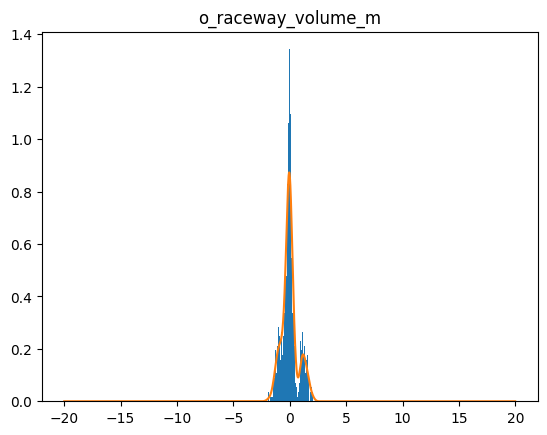

torch.Size([4000])
801  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
802  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
803  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
804  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
805  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
806  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
807  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
808  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
809  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
810  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
811  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
812  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
813  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
814  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
815  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
816  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
817  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
818  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
819  loss=  tensor(0.0318, grad_fn=<MeanBackw

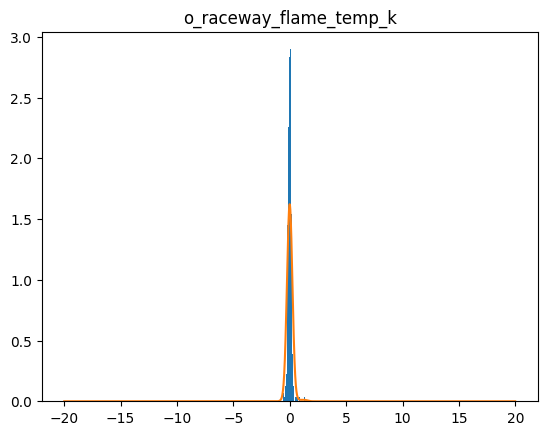

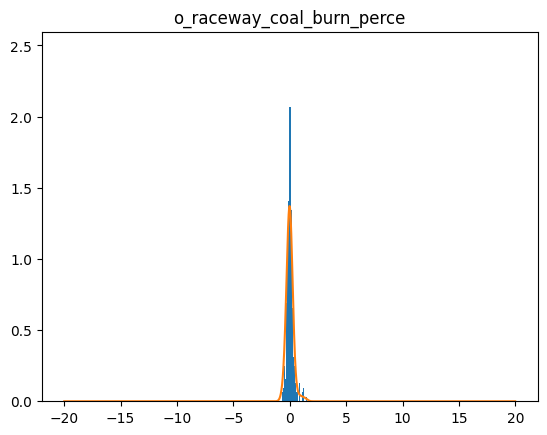

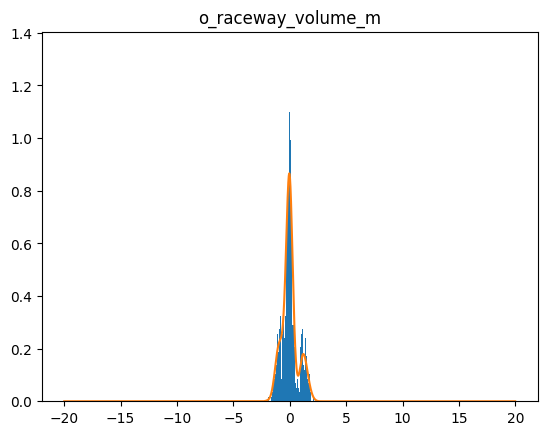

torch.Size([4000])
851  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
852  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
853  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
854  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
855  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
856  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
857  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
858  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
859  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
860  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
861  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
862  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
863  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
864  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
865  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
866  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
867  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
868  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
869  loss=  tensor(0.0319, grad_fn=<MeanBackw

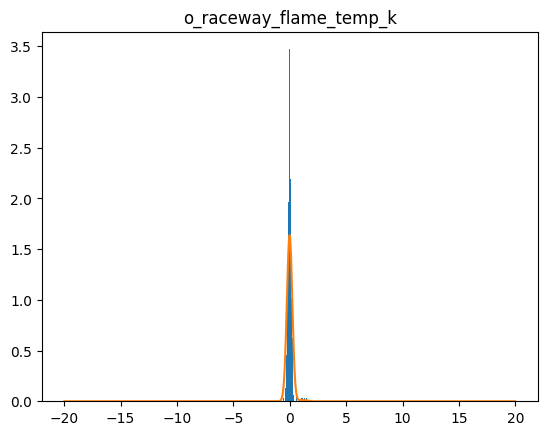

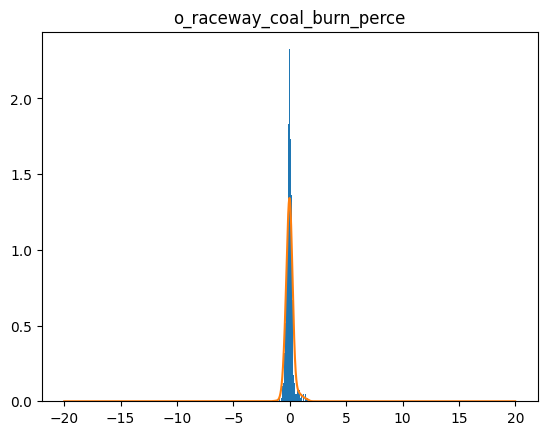

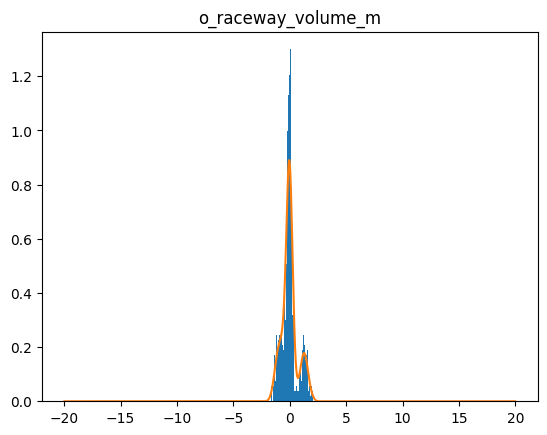

torch.Size([4000])
901  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
902  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
903  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
904  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
905  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
906  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
907  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
908  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
909  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
910  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
911  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
912  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
913  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
914  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
915  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
916  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
917  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
918  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
919  loss=  tensor(0.0320, grad_fn=<MeanBackw

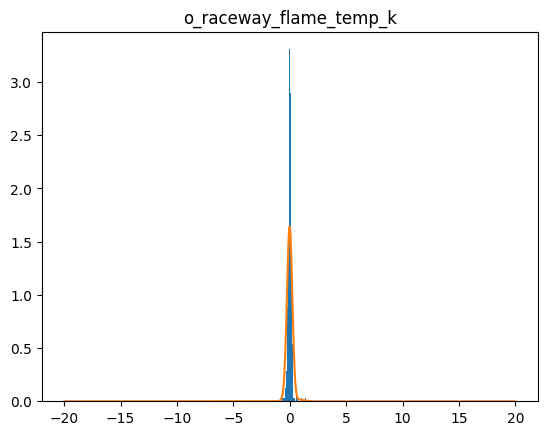

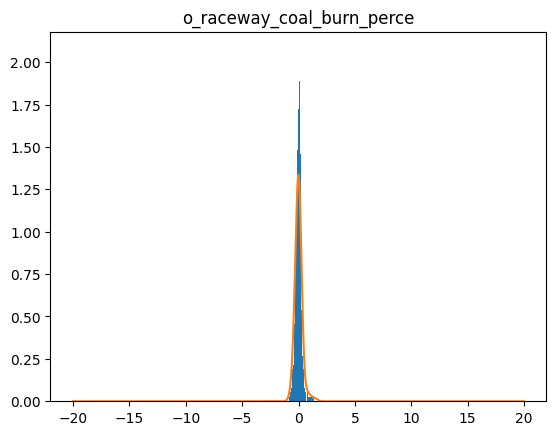

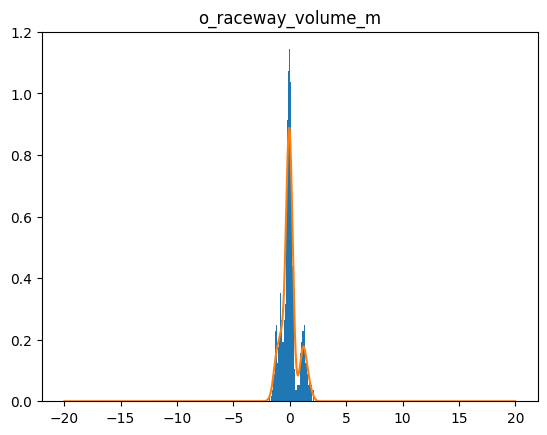

torch.Size([4000])
951  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
952  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
953  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
954  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
955  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
956  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
957  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
958  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
959  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
960  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
961  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
962  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
963  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
964  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
965  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
966  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
967  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
968  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
969  loss=  tensor(0.0319, grad_fn=<MeanBackw

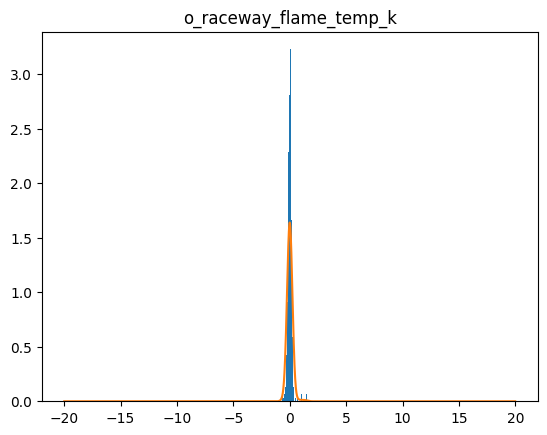

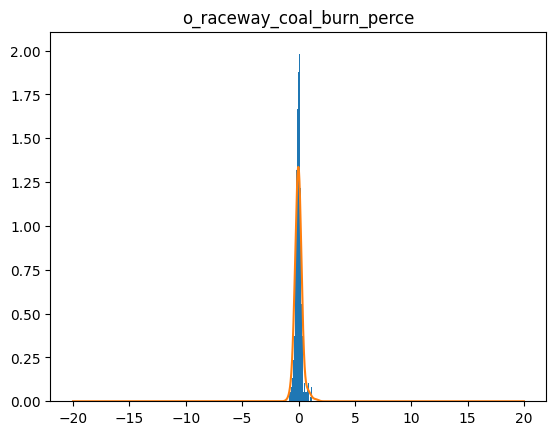

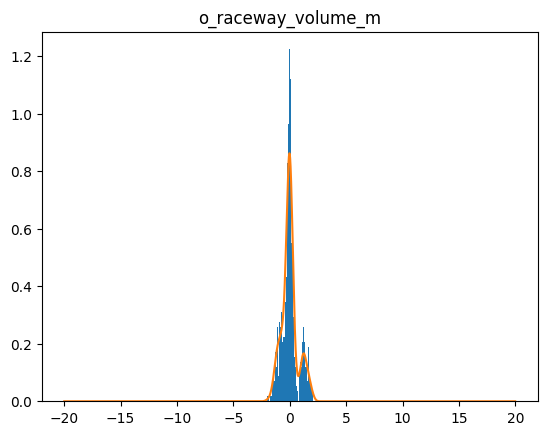

torch.Size([4000])
1001  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1002  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1003  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1004  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1005  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1006  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1007  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1008  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1009  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1010  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1011  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1012  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1013  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1014  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1015  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1016  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1017  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
1018  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1019  loss=  tensor(0.0312,

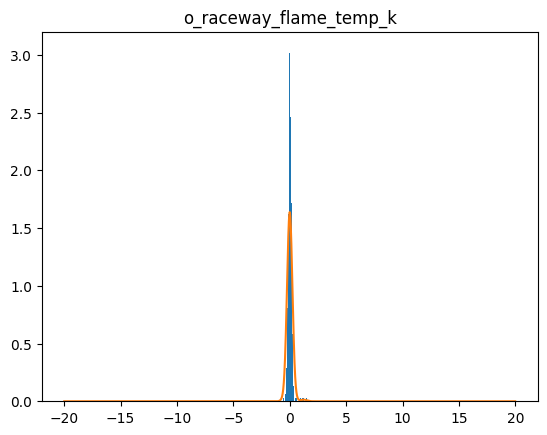

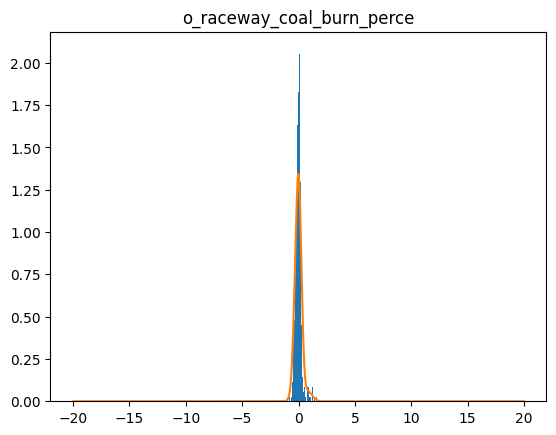

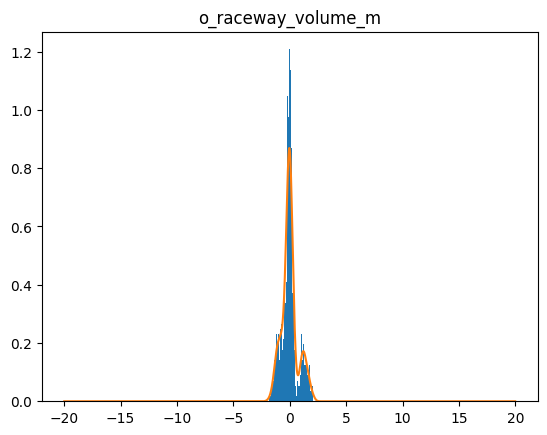

torch.Size([4000])
1051  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1052  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
1053  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1054  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1055  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1056  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1057  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1058  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1059  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1060  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1061  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1062  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1063  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1064  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1065  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1066  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1067  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
1068  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1069  loss=  tensor(0.0320,

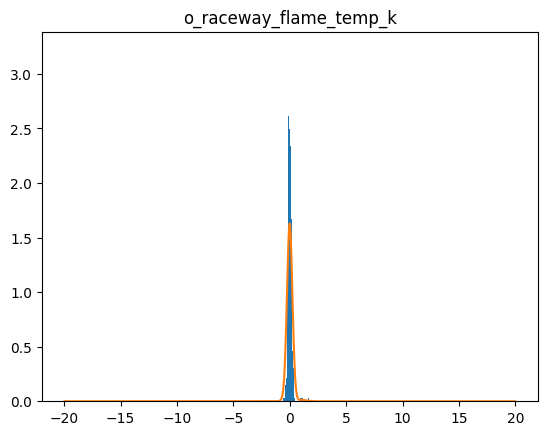

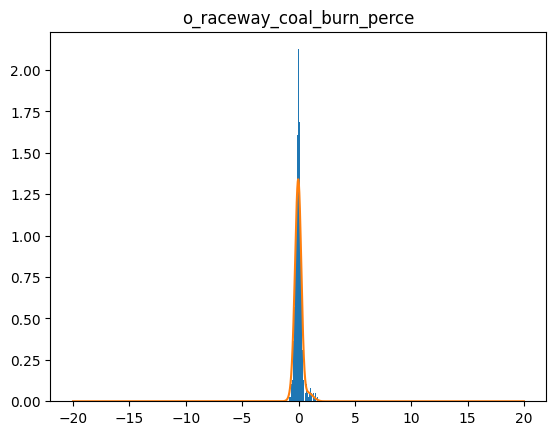

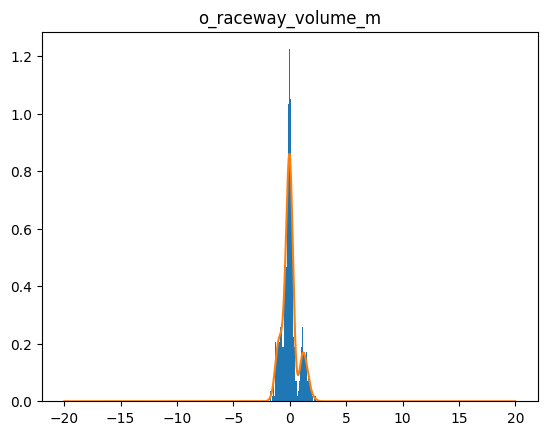

torch.Size([4000])
1101  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1102  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1103  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1104  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1105  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1106  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1107  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
1108  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1109  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1110  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1111  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1112  loss=  tensor(0.0326, grad_fn=<MeanBackward0>)
1113  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1114  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1115  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
1116  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1117  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1118  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1119  loss=  tensor(0.0316,

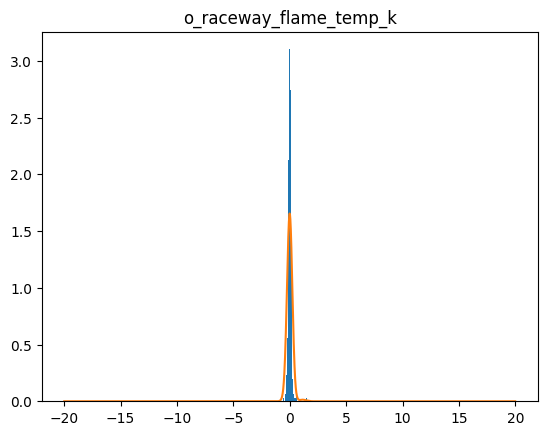

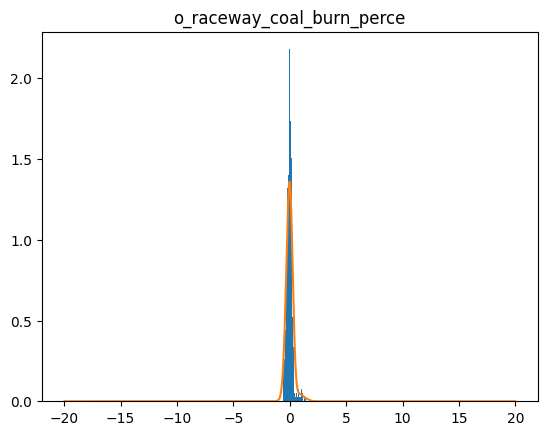

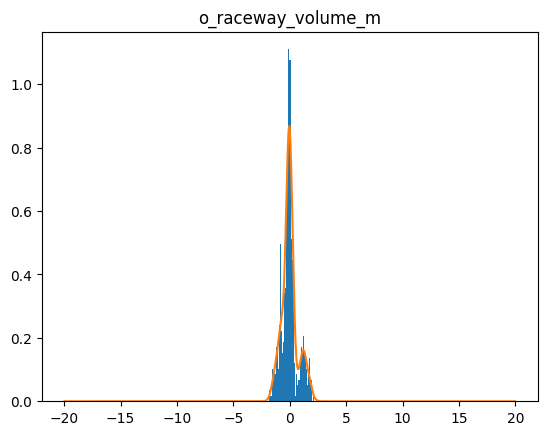

torch.Size([4000])
1151  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1152  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1153  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1154  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1155  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1156  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1157  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1158  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1159  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1160  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1161  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
1162  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1163  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1164  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1165  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1166  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1167  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1168  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1169  loss=  tensor(0.0314,

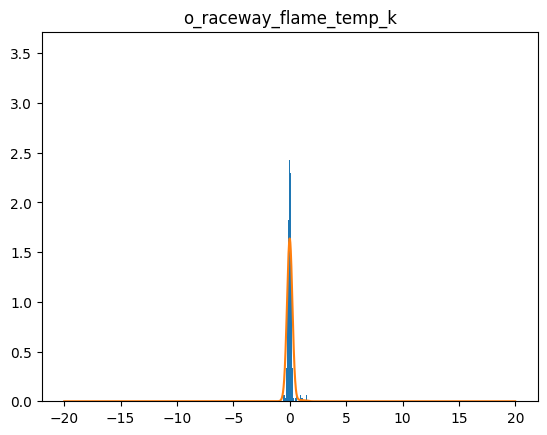

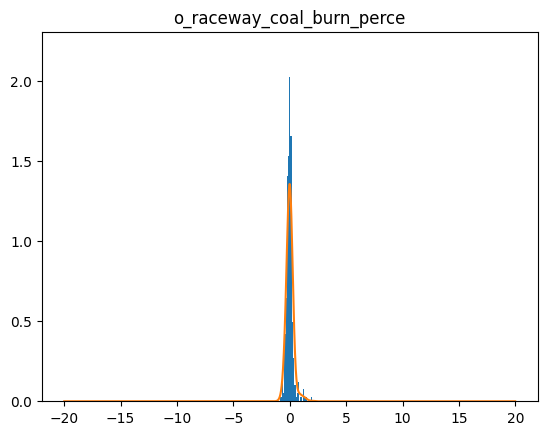

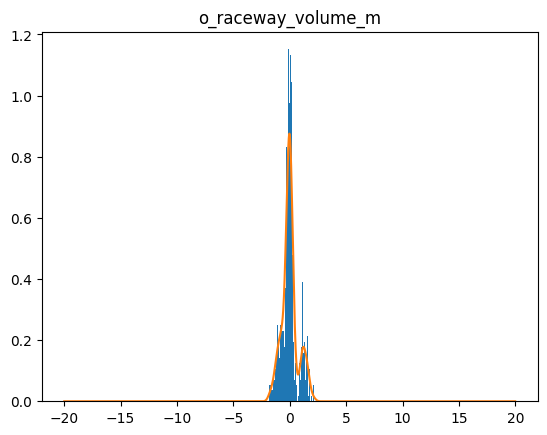

torch.Size([4000])
1201  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1202  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1203  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1204  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1205  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1206  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1207  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1208  loss=  tensor(0.0324, grad_fn=<MeanBackward0>)
1209  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1210  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1211  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1212  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1213  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1214  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1215  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1216  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1217  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1218  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1219  loss=  tensor(0.0319,

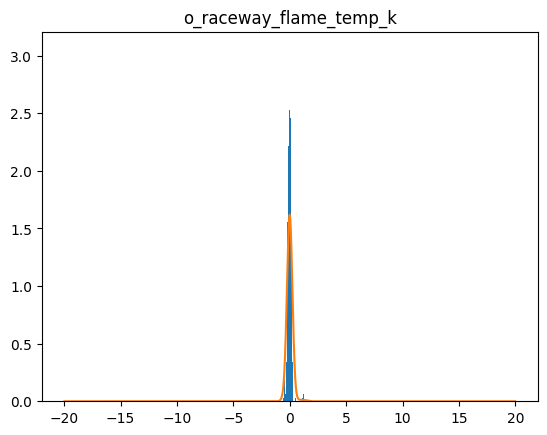

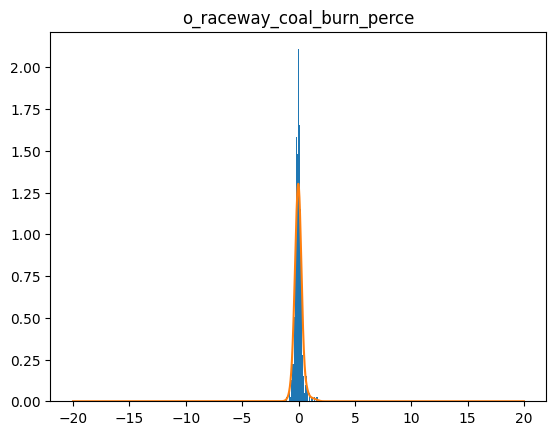

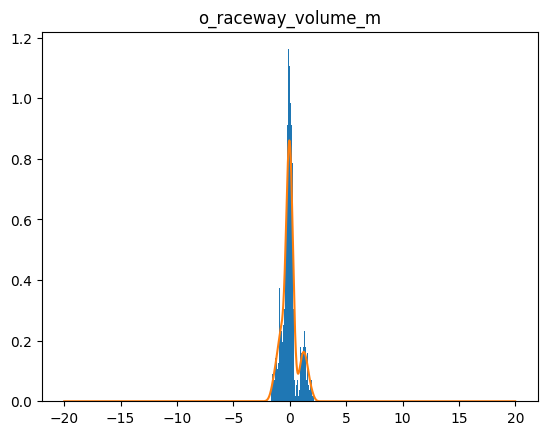

torch.Size([4000])
1251  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1252  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1253  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1254  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1255  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1256  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1257  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1258  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1259  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1260  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1261  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1262  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1263  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1264  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1265  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1266  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1267  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1268  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1269  loss=  tensor(0.0316,

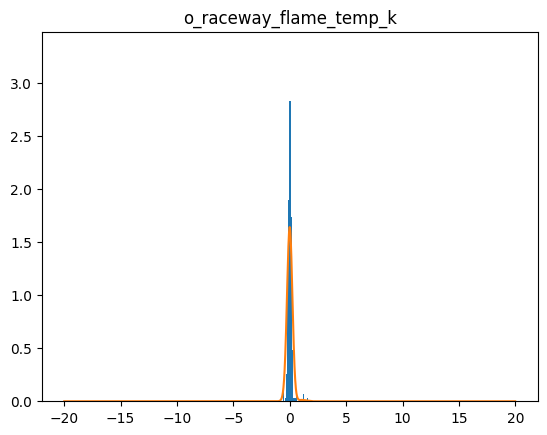

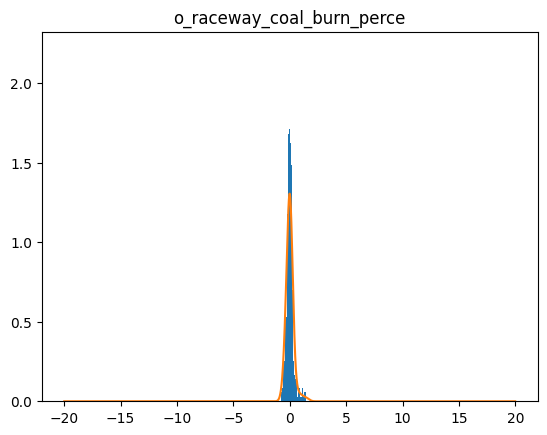

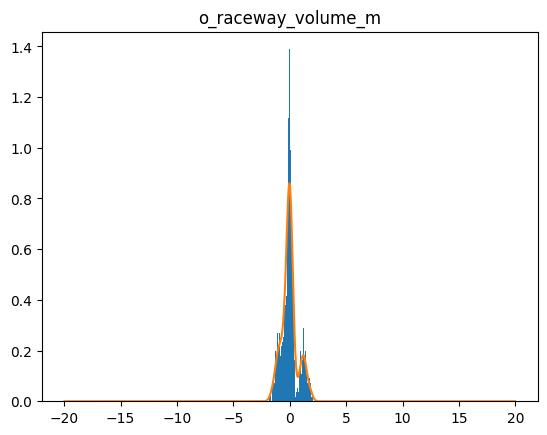

torch.Size([4000])
1301  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1302  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1303  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1304  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1305  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1306  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1307  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1308  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1309  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1310  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
1311  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1312  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1313  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1314  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1315  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1316  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1317  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1318  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1319  loss=  tensor(0.0315,

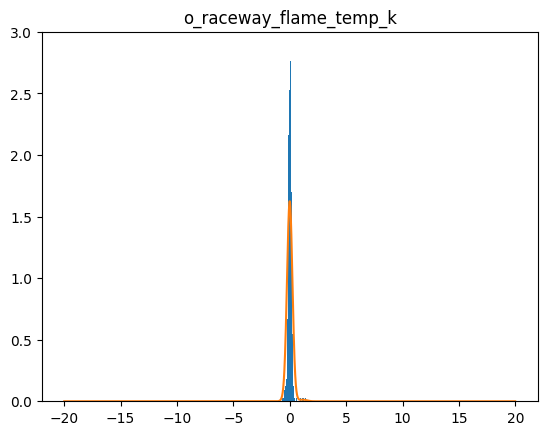

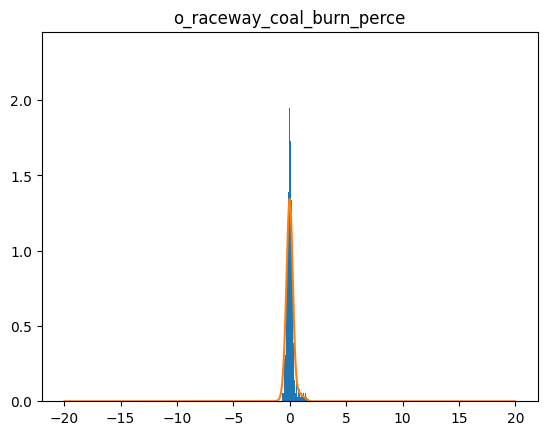

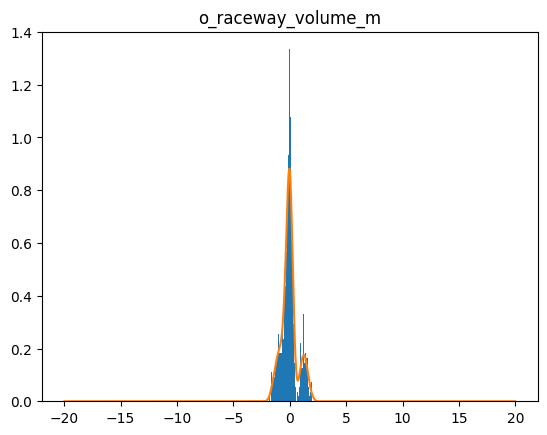

torch.Size([4000])
1351  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1352  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1353  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1354  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1355  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1356  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1357  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1358  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1359  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1360  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1361  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1362  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1363  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1364  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1365  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1366  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1367  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1368  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1369  loss=  tensor(0.0323,

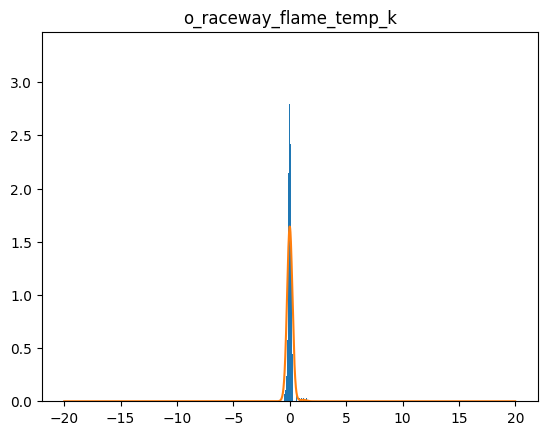

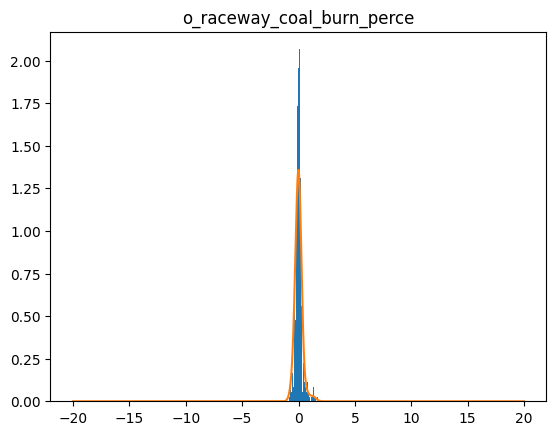

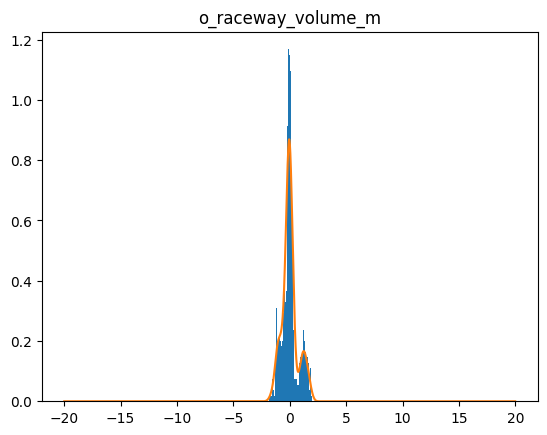

torch.Size([4000])
1401  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1402  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1403  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1404  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1405  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1406  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1407  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1408  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1409  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1410  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1411  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1412  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1413  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1414  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1415  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1416  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1417  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1418  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1419  loss=  tensor(0.0316,

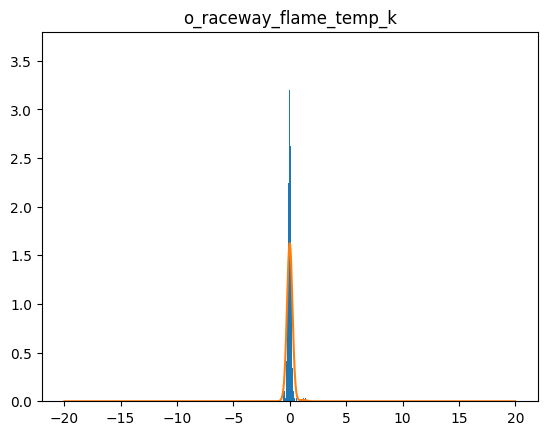

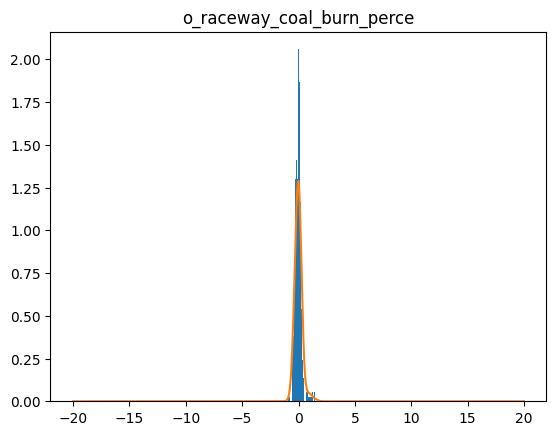

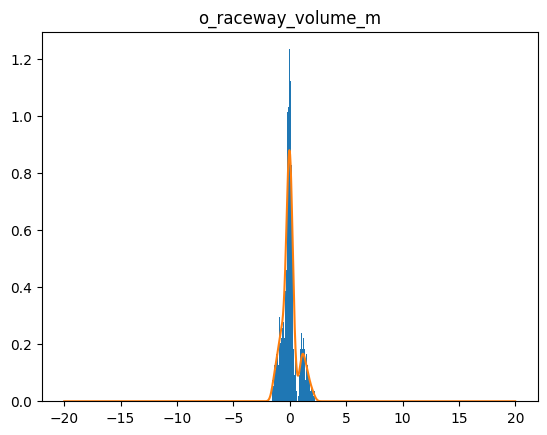

torch.Size([4000])
1451  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1452  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1453  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1454  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1455  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1456  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1457  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1458  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1459  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1460  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1461  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1462  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1463  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1464  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1465  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1466  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1467  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1468  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1469  loss=  tensor(0.0314,

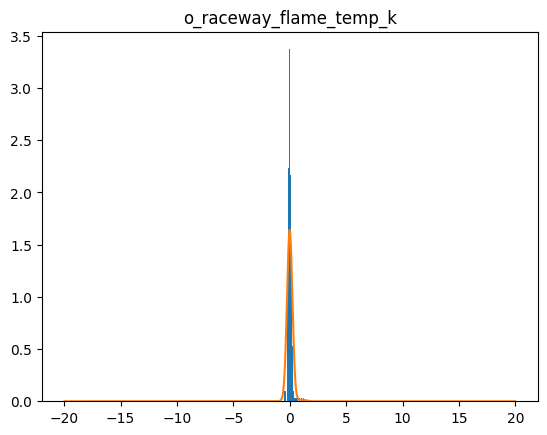

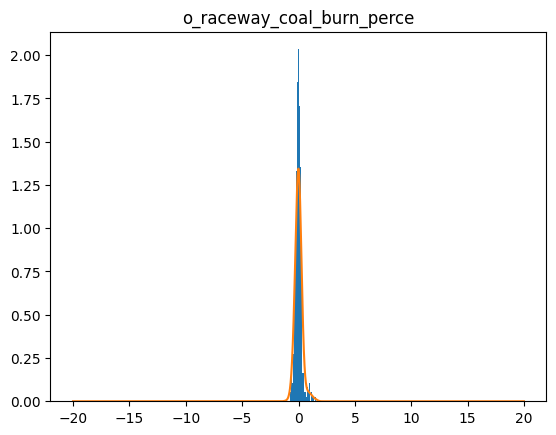

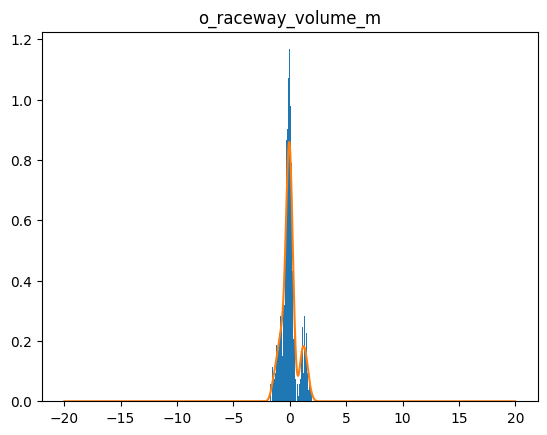

torch.Size([4000])
1501  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1502  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1503  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1504  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1505  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1506  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1507  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1508  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1509  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1510  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1511  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1512  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1513  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1514  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1515  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
1516  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1517  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1518  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1519  loss=  tensor(0.0314,

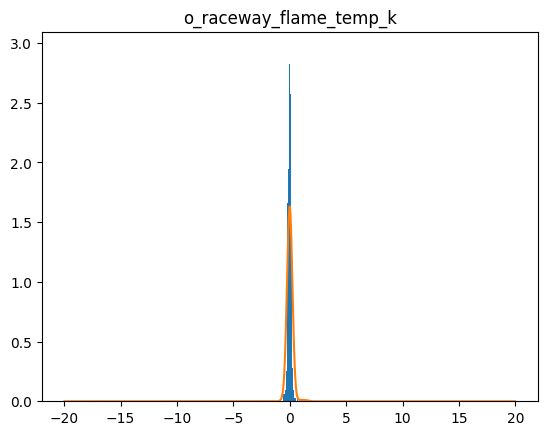

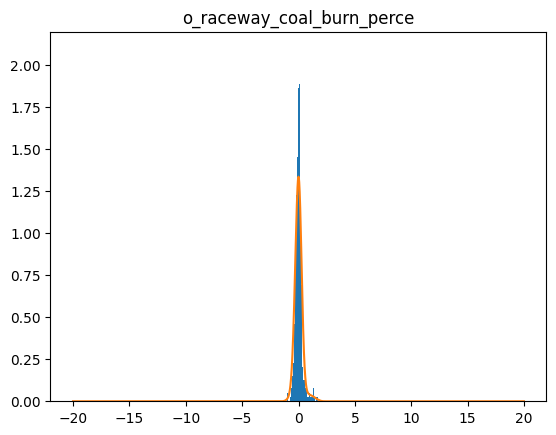

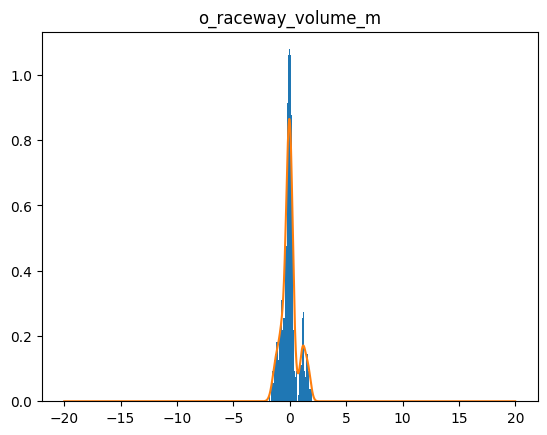

torch.Size([4000])
1551  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1552  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1553  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1554  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1555  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1556  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1557  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1558  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1559  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1560  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1561  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1562  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1563  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1564  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1565  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1566  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1567  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1568  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1569  loss=  tensor(0.0315,

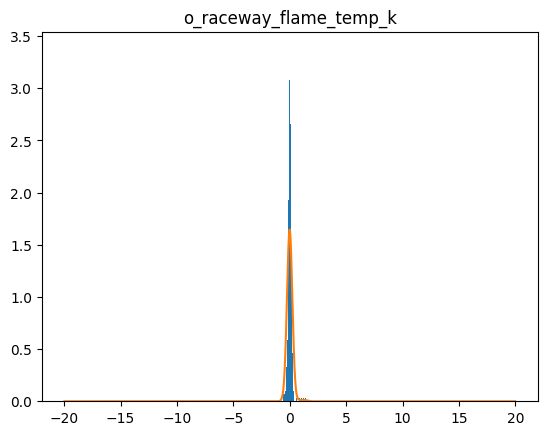

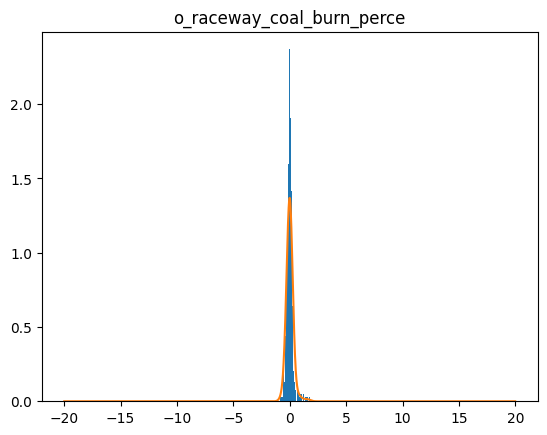

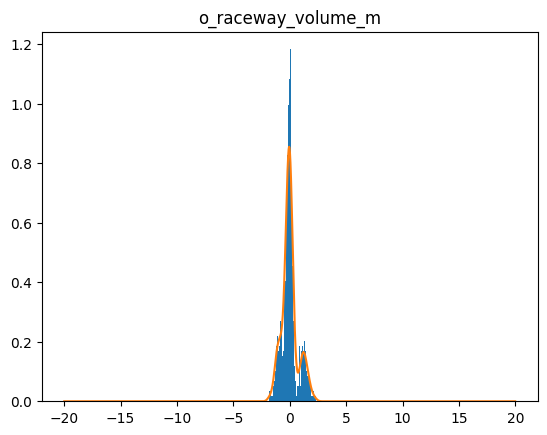

torch.Size([4000])
1601  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
1602  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1603  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1604  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1605  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1606  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1607  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1608  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1609  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1610  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1611  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1612  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1613  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1614  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1615  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1616  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1617  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1618  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1619  loss=  tensor(0.0318,

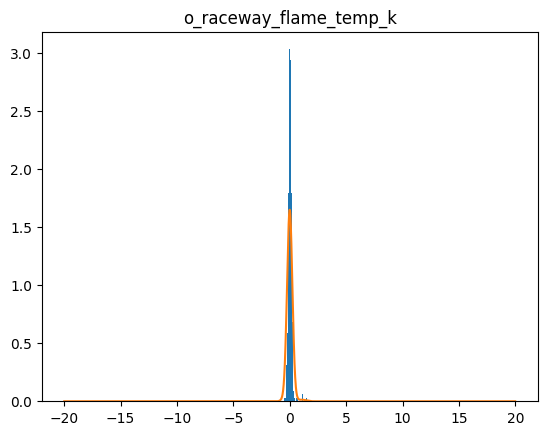

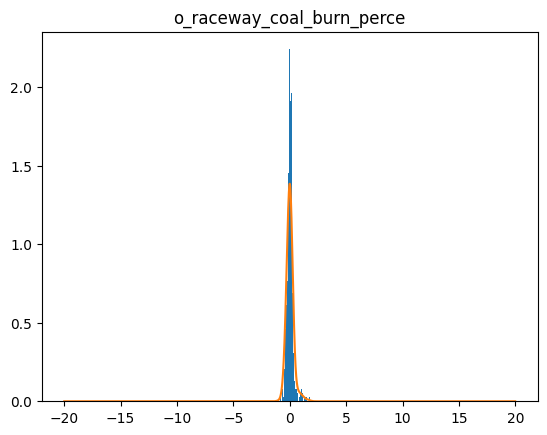

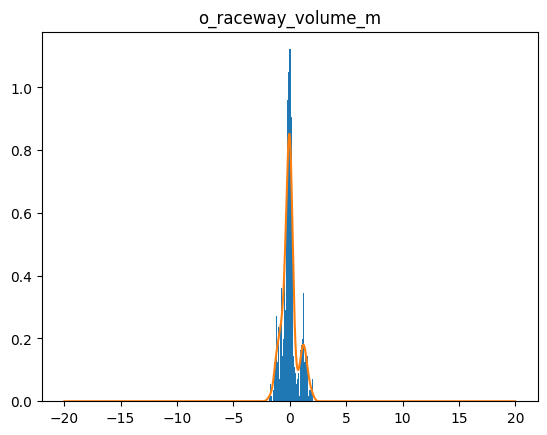

torch.Size([4000])
1651  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1652  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1653  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1654  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1655  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1656  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1657  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1658  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1659  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
1660  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1661  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1662  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1663  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1664  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1665  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1666  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1667  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1668  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1669  loss=  tensor(0.0317,

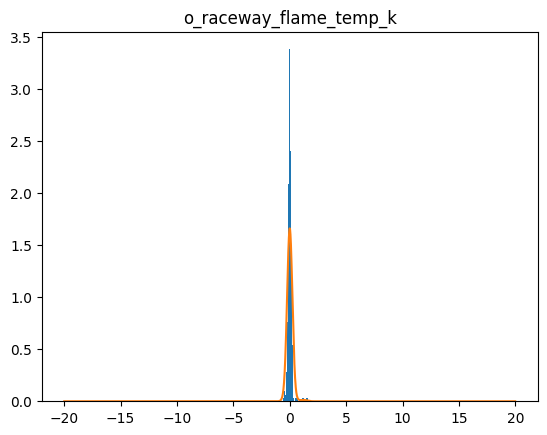

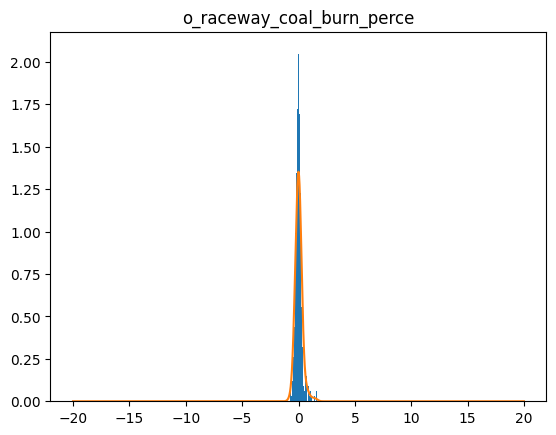

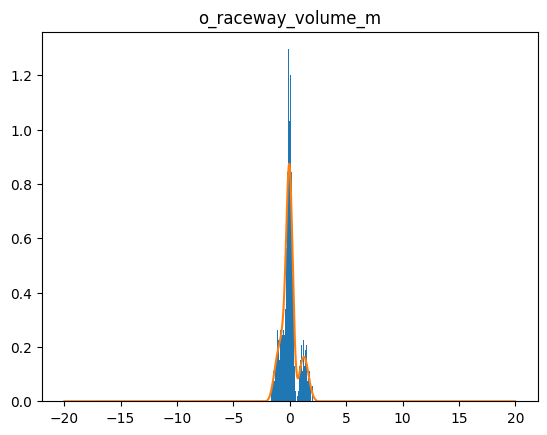

torch.Size([4000])
1701  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1702  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1703  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1704  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1705  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1706  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1707  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1708  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1709  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1710  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1711  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1712  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1713  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1714  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1715  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
1716  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1717  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1718  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1719  loss=  tensor(0.0311,

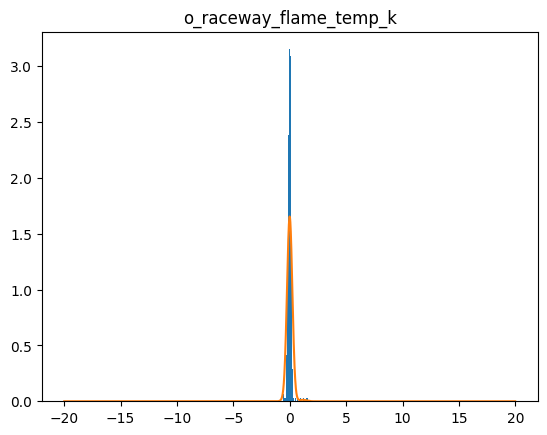

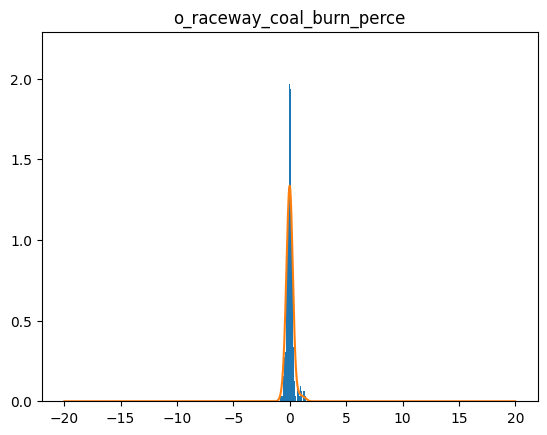

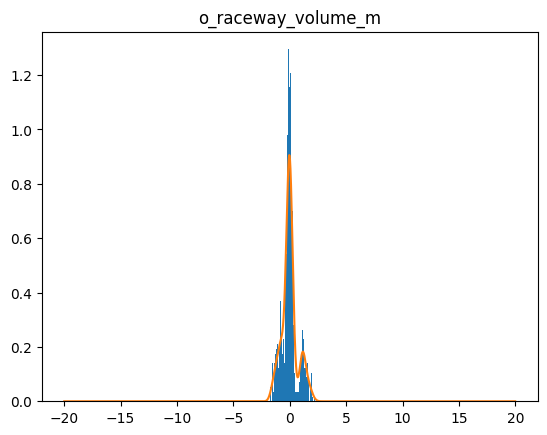

torch.Size([4000])
1751  loss=  tensor(0.0325, grad_fn=<MeanBackward0>)
1752  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
1753  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1754  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1755  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1756  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1757  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1758  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1759  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1760  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1761  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1762  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1763  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1764  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1765  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1766  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1767  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1768  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1769  loss=  tensor(0.0317,

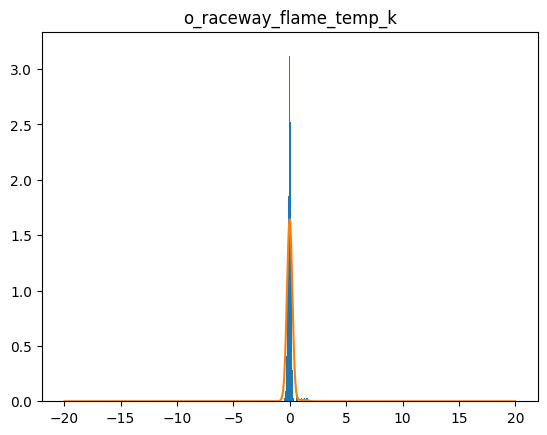

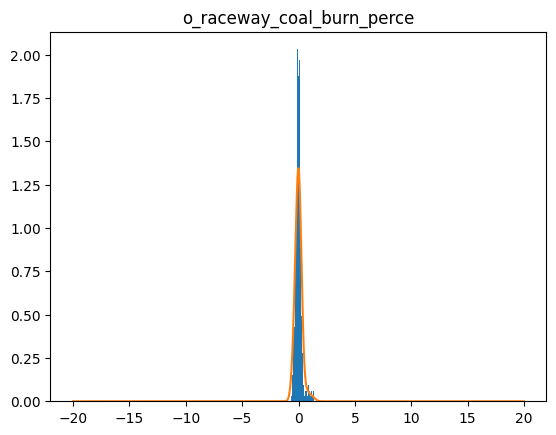

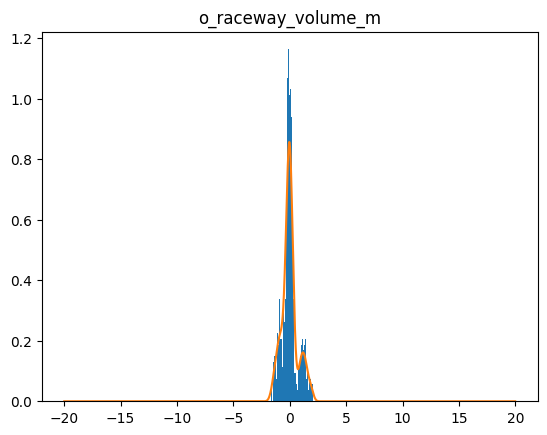

torch.Size([4000])
1801  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1802  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1803  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1804  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1805  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1806  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1807  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1808  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1809  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1810  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1811  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1812  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
1813  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1814  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1815  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1816  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1817  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1818  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1819  loss=  tensor(0.0317,

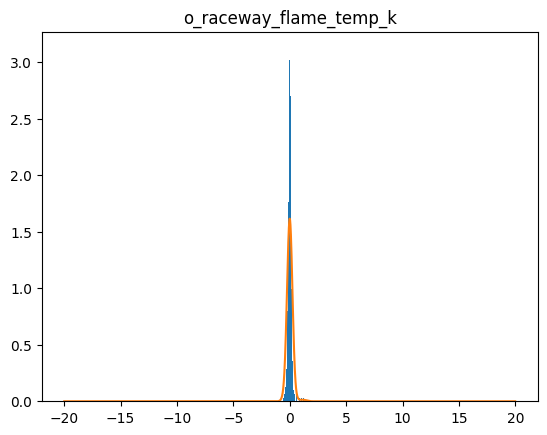

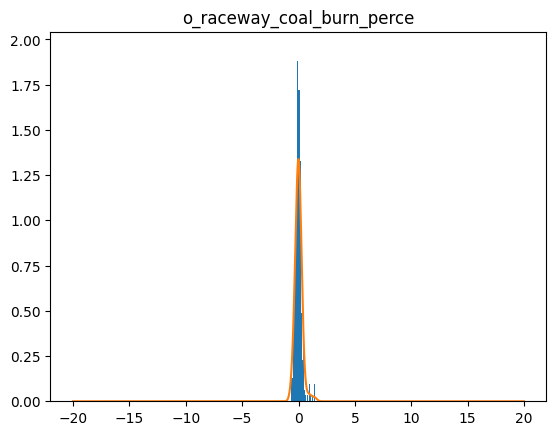

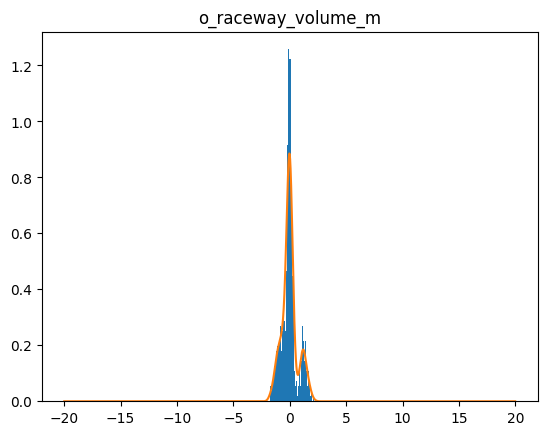

torch.Size([4000])
1851  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1852  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1853  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1854  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1855  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1856  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
1857  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1858  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1859  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1860  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1861  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1862  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1863  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1864  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1865  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1866  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1867  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1868  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1869  loss=  tensor(0.0316,

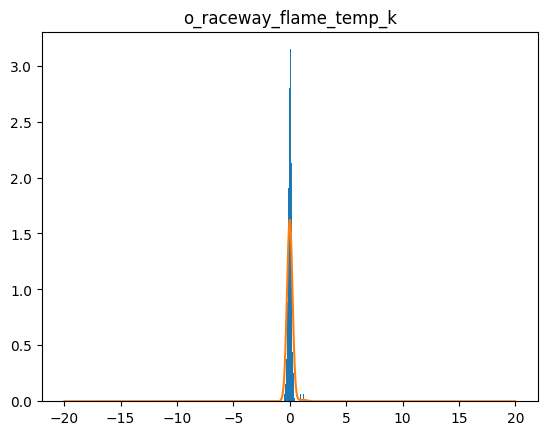

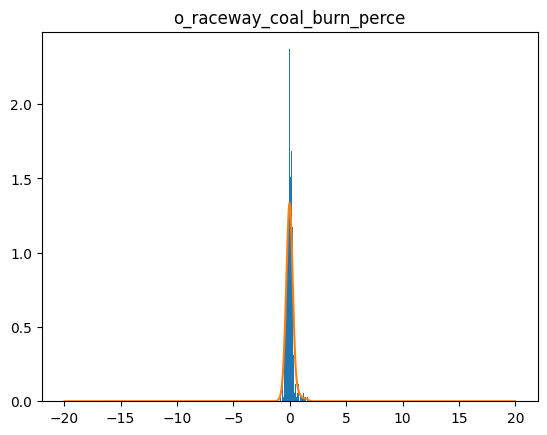

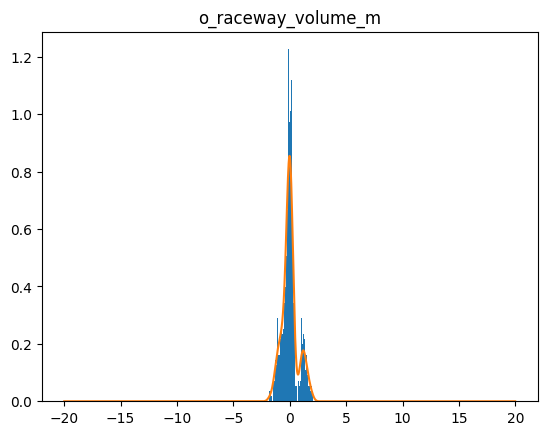

torch.Size([4000])
1901  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1902  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1903  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1904  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1905  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1906  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
1907  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1908  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1909  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1910  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1911  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1912  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1913  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1914  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1915  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1916  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1917  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1918  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
1919  loss=  tensor(0.0315,

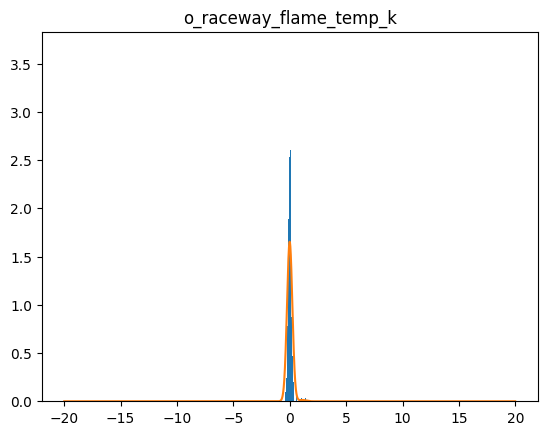

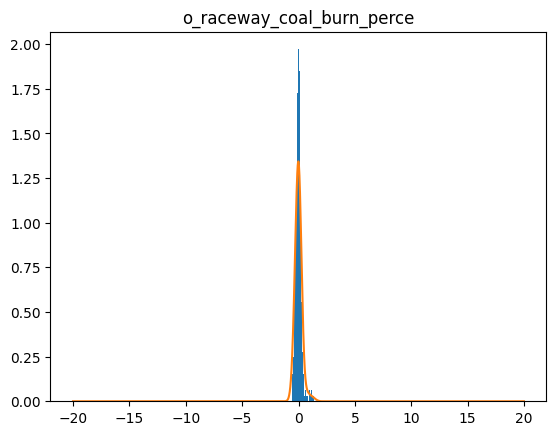

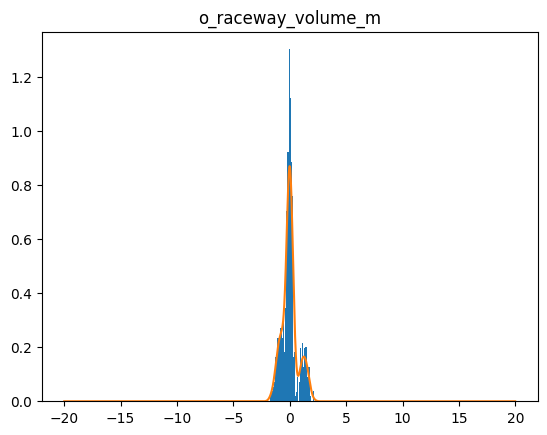

torch.Size([4000])
1951  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
1952  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1953  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
1954  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1955  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1956  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
1957  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
1958  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
1959  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
1960  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1961  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
1962  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1963  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
1964  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
1965  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
1966  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
1967  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
1968  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
1969  loss=  tensor(0.0319,

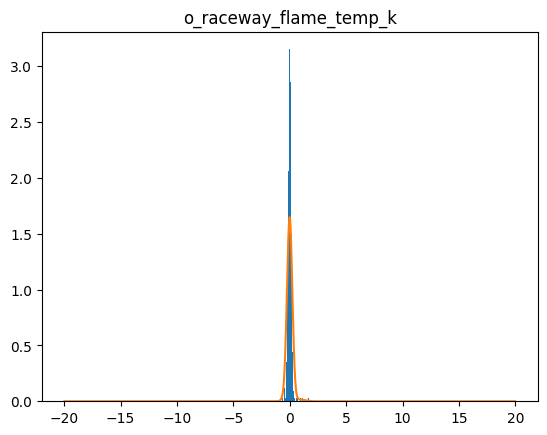

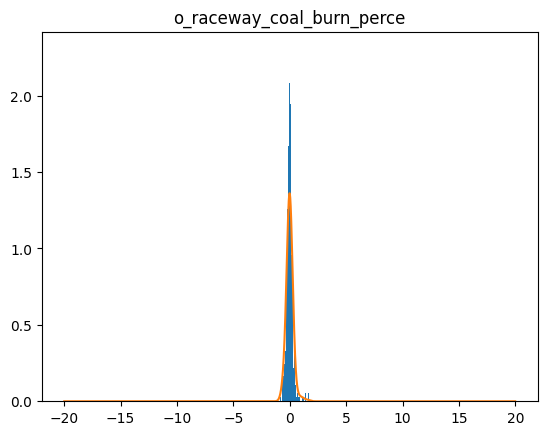

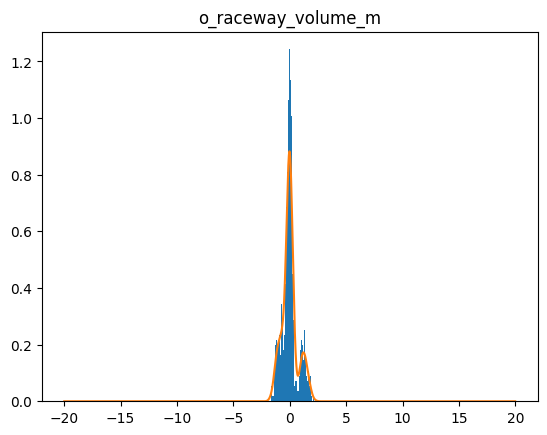

torch.Size([4000])
2001  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2002  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2003  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2004  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2005  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2006  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
2007  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2008  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2009  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2010  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2011  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2012  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2013  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2014  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2015  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2016  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2017  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2018  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2019  loss=  tensor(0.0316,

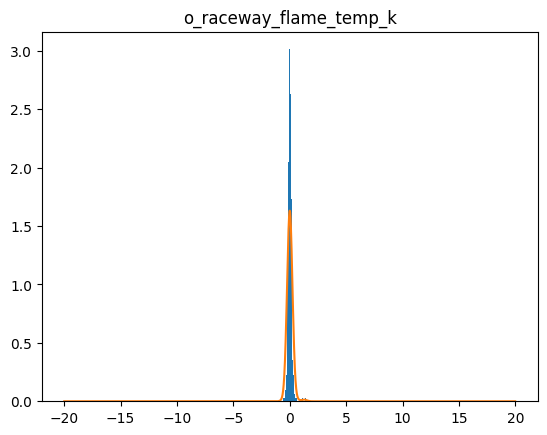

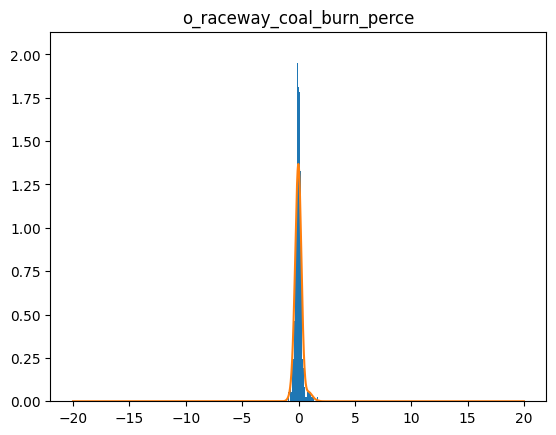

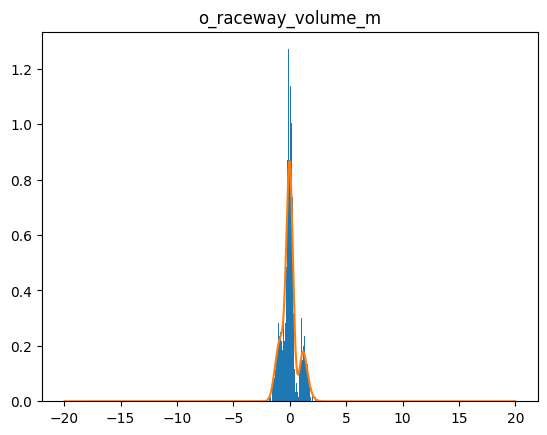

torch.Size([4000])
2051  loss=  tensor(0.0323, grad_fn=<MeanBackward0>)
2052  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2053  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2054  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
2055  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2056  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2057  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2058  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2059  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2060  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2061  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2062  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2063  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2064  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2065  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2066  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2067  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2068  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2069  loss=  tensor(0.0313,

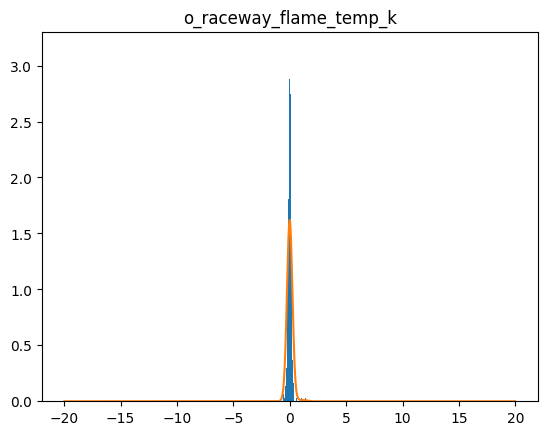

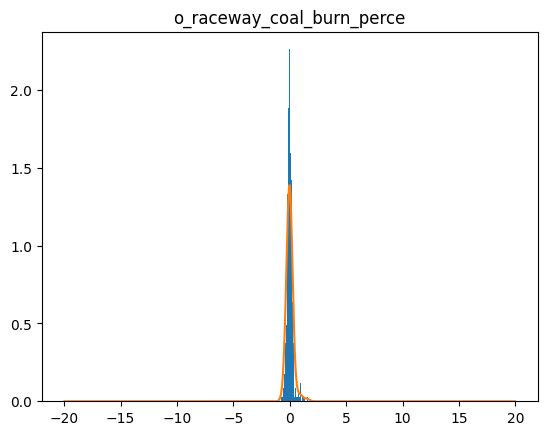

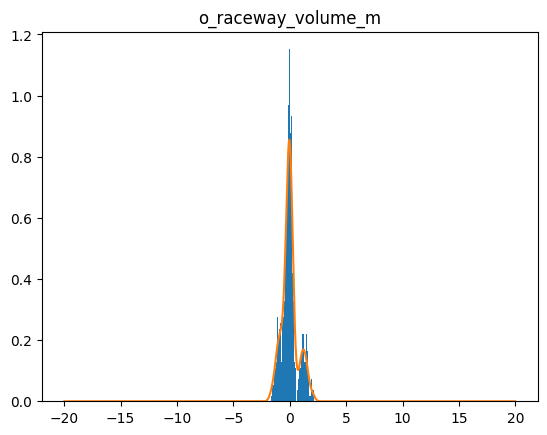

torch.Size([4000])
2101  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2102  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2103  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2104  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
2105  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2106  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2107  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2108  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2109  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2110  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2111  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2112  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2113  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2114  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2115  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2116  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2117  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2118  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2119  loss=  tensor(0.0315,

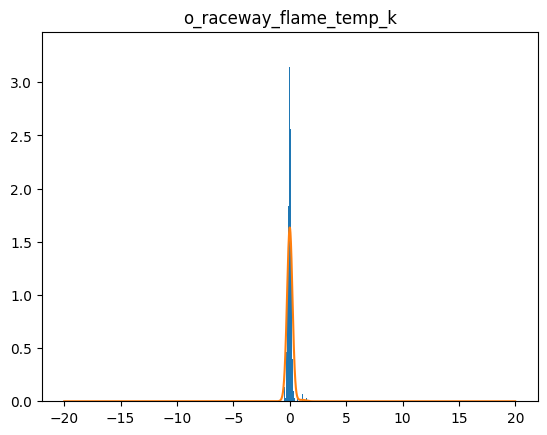

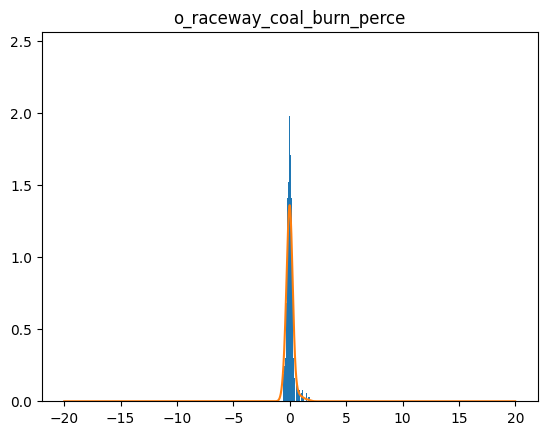

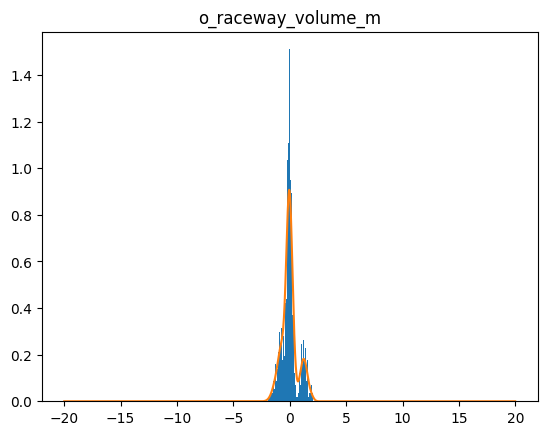

torch.Size([4000])
2151  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2152  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2153  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2154  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2155  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2156  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
2157  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2158  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2159  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2160  loss=  tensor(0.0325, grad_fn=<MeanBackward0>)
2161  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2162  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2163  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2164  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2165  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2166  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2167  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2168  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2169  loss=  tensor(0.0315,

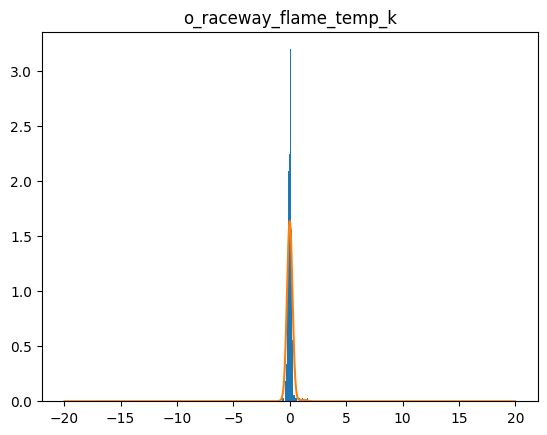

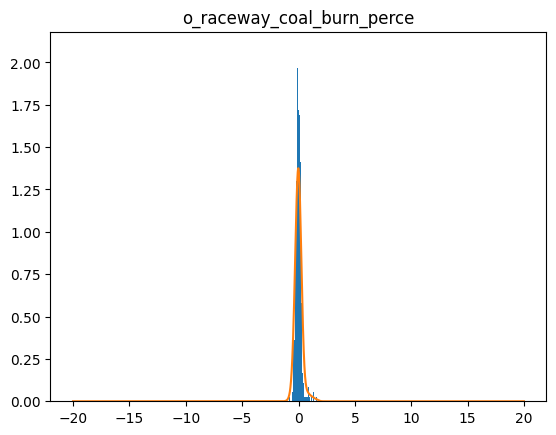

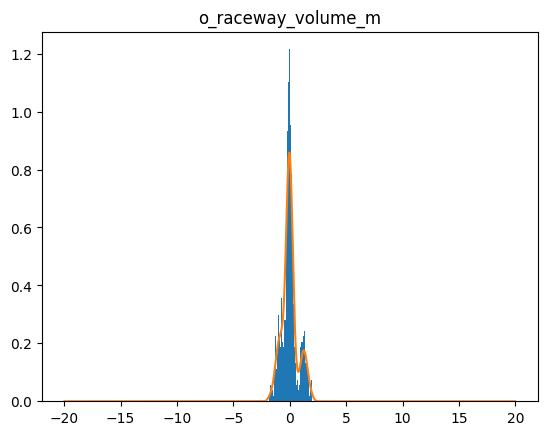

torch.Size([4000])
2201  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2202  loss=  tensor(0.0307, grad_fn=<MeanBackward0>)
2203  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2204  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2205  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2206  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2207  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2208  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2209  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2210  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2211  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2212  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2213  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2214  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2215  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2216  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2217  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2218  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2219  loss=  tensor(0.0314,

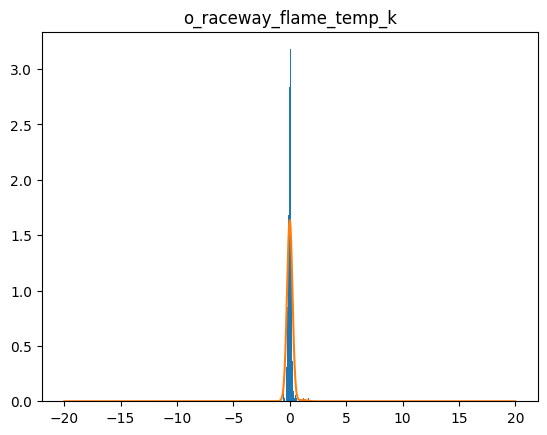

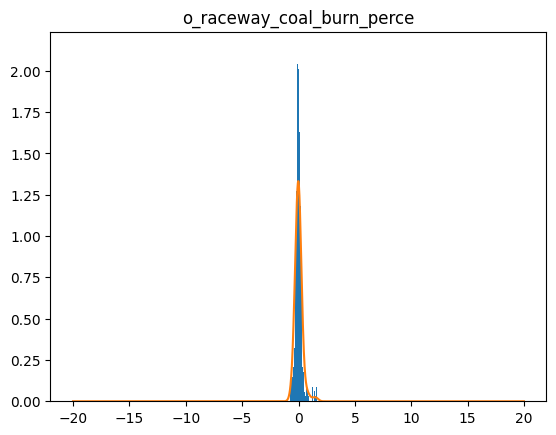

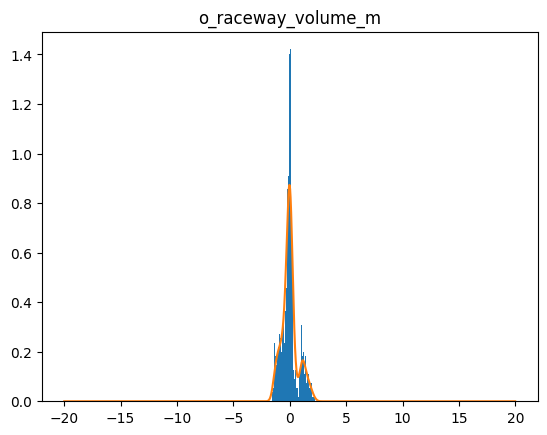

torch.Size([4000])
2251  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2252  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2253  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2254  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2255  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2256  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2257  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2258  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2259  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2260  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2261  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2262  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2263  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2264  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2265  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2266  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2267  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2268  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2269  loss=  tensor(0.0315,

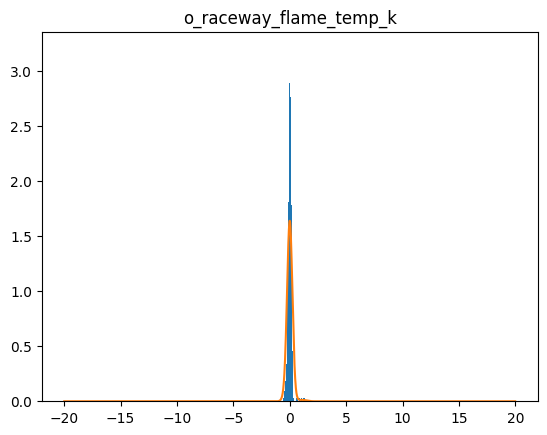

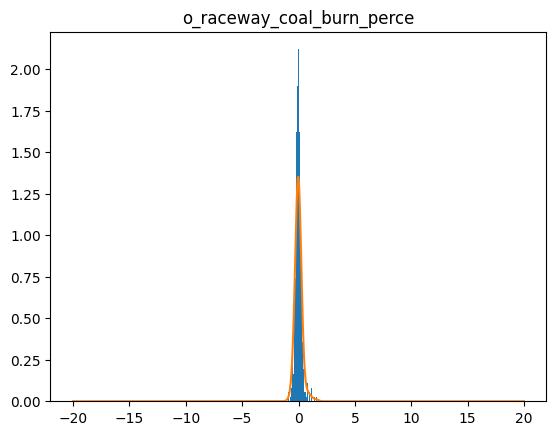

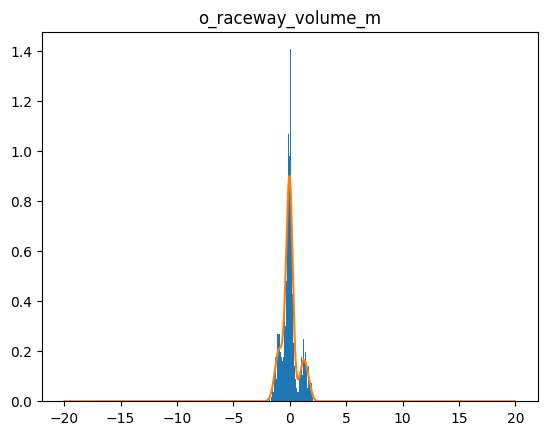

torch.Size([4000])
2301  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2302  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2303  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2304  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2305  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2306  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2307  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2308  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2309  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2310  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2311  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2312  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2313  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2314  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2315  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2316  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2317  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
2318  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2319  loss=  tensor(0.0317,

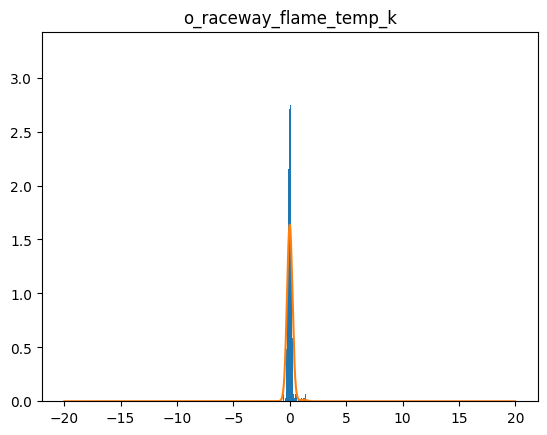

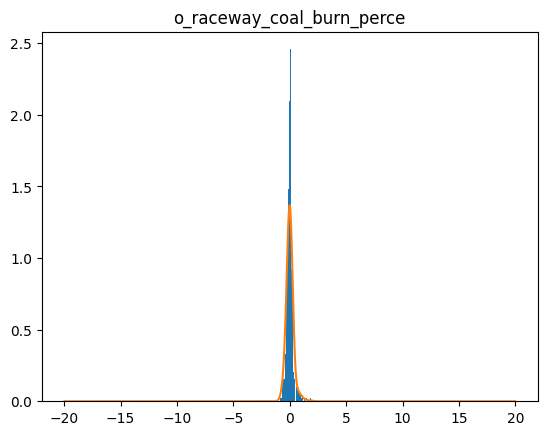

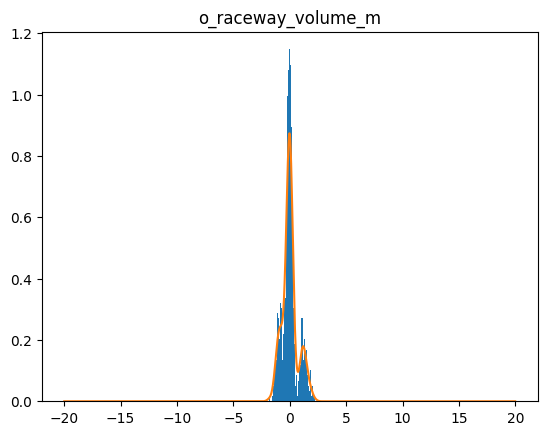

torch.Size([4000])
2351  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2352  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2353  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2354  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2355  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2356  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2357  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2358  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2359  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2360  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2361  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2362  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2363  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2364  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2365  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2366  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2367  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
2368  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2369  loss=  tensor(0.0319,

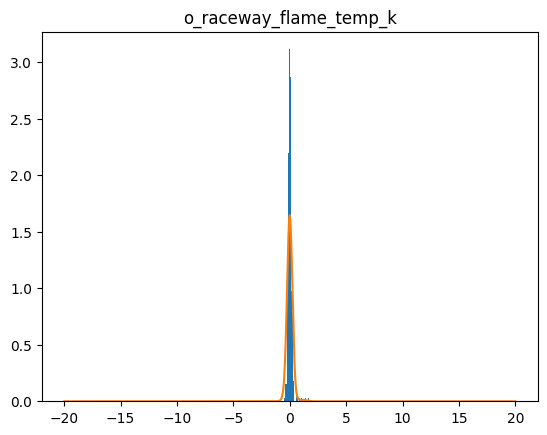

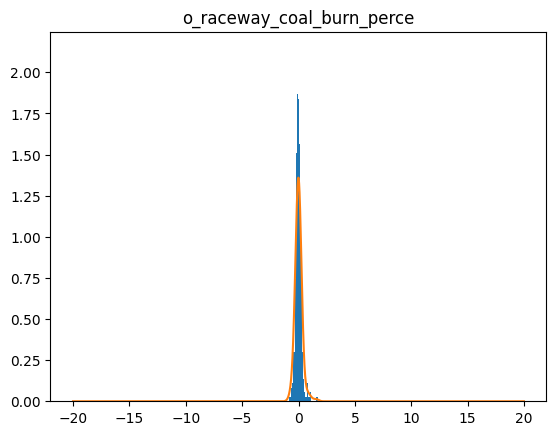

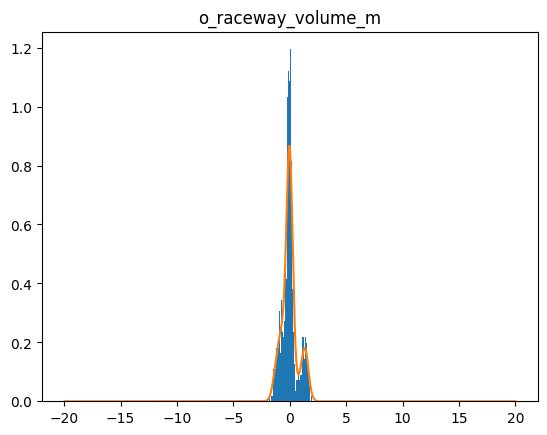

torch.Size([4000])
2401  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2402  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2403  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2404  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2405  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2406  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2407  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2408  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2409  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2410  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2411  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2412  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2413  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2414  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2415  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2416  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2417  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2418  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2419  loss=  tensor(0.0314,

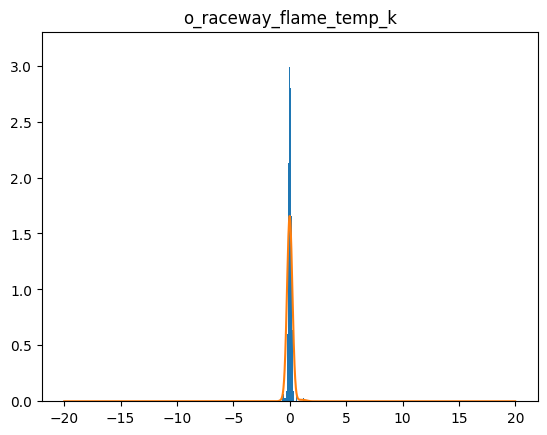

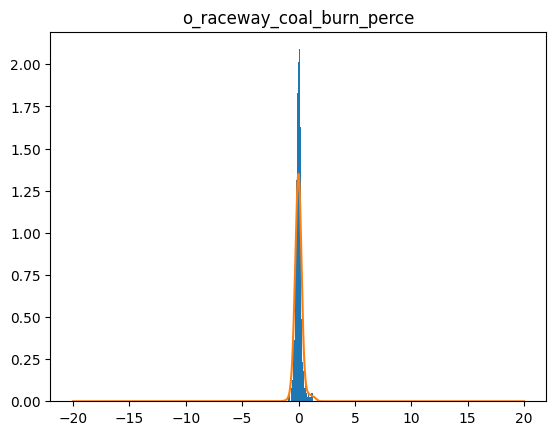

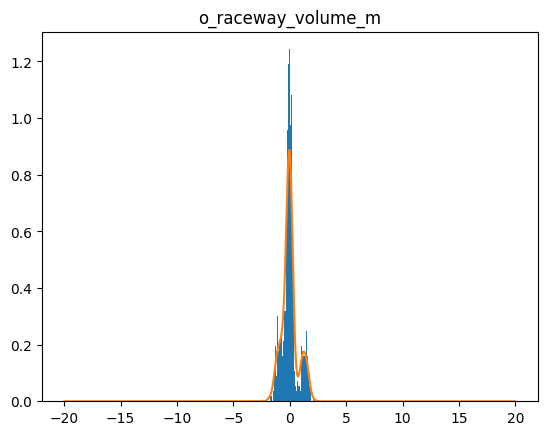

torch.Size([4000])
2451  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2452  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2453  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2454  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2455  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2456  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2457  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2458  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2459  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2460  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2461  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2462  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2463  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2464  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2465  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2466  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2467  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2468  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2469  loss=  tensor(0.0315,

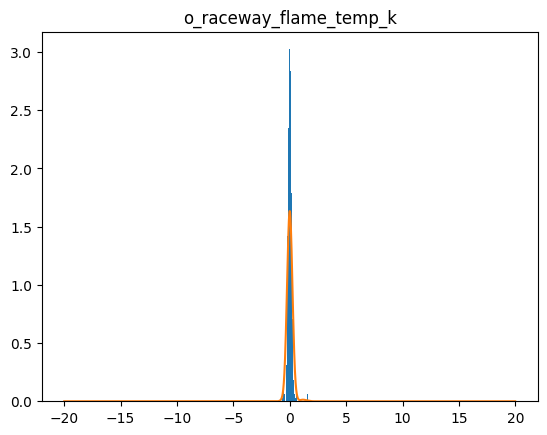

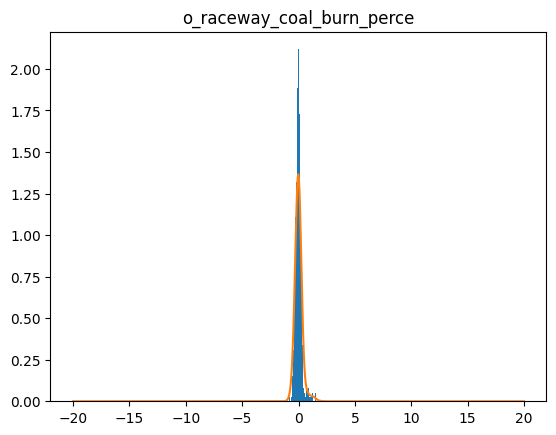

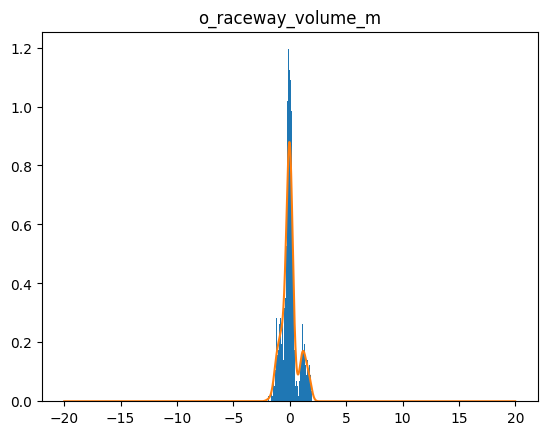

torch.Size([4000])
2501  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2502  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
2503  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2504  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2505  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2506  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2507  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
2508  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2509  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2510  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2511  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2512  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2513  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2514  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2515  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2516  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2517  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2518  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2519  loss=  tensor(0.0315,

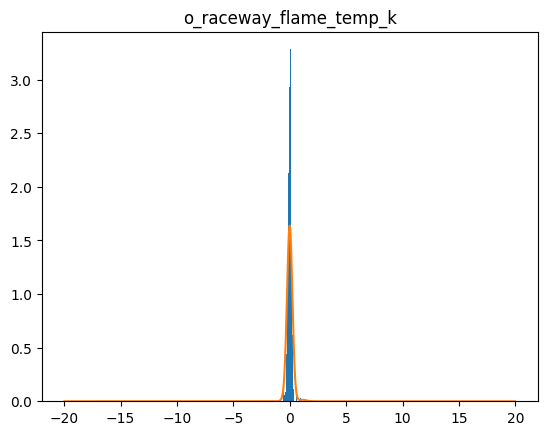

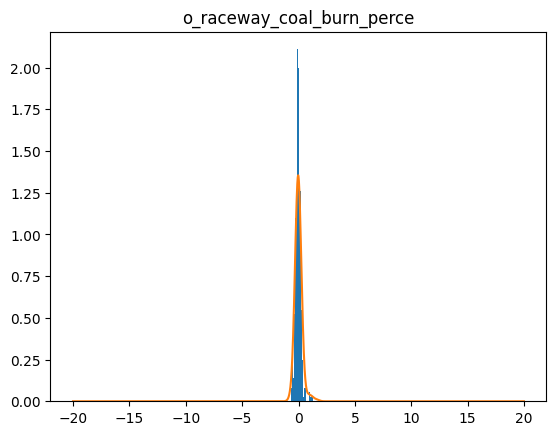

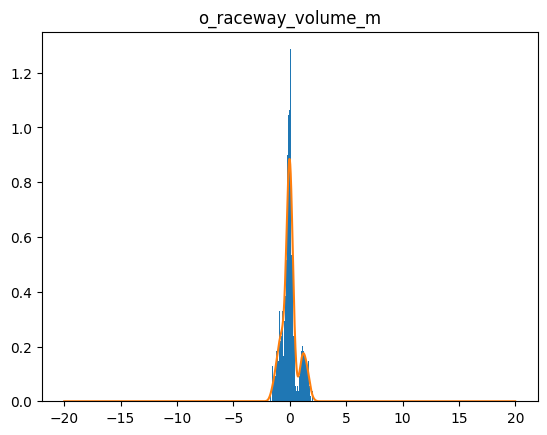

torch.Size([4000])
2551  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2552  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2553  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2554  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2555  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2556  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2557  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2558  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2559  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2560  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2561  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2562  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2563  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2564  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2565  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2566  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2567  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2568  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2569  loss=  tensor(0.0317,

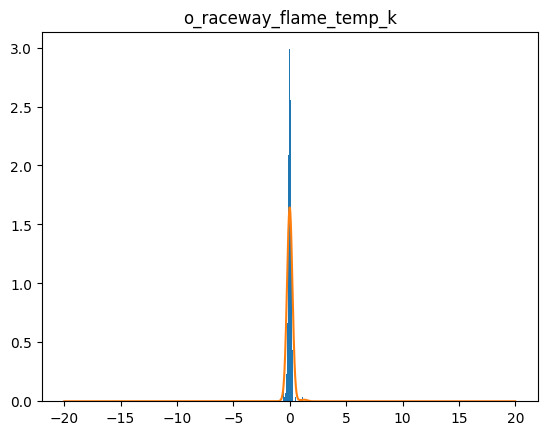

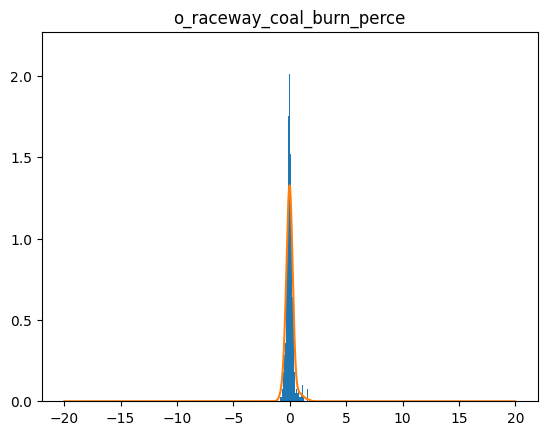

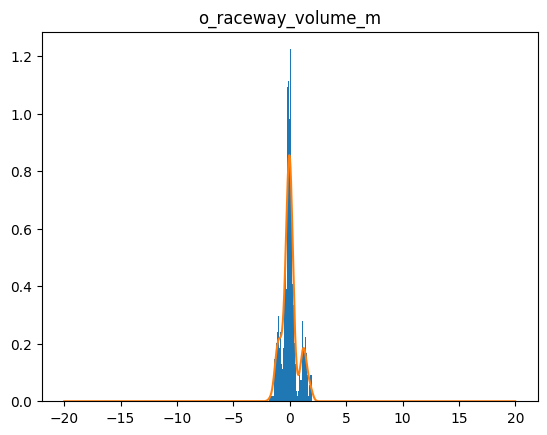

torch.Size([4000])
2601  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2602  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2603  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2604  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
2605  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2606  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2607  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2608  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2609  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2610  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
2611  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2612  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2613  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2614  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2615  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2616  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2617  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2618  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2619  loss=  tensor(0.0313,

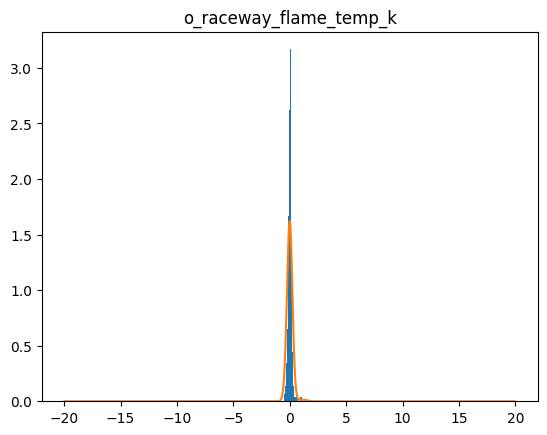

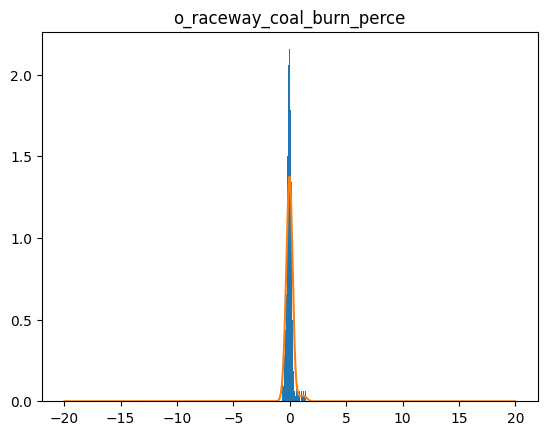

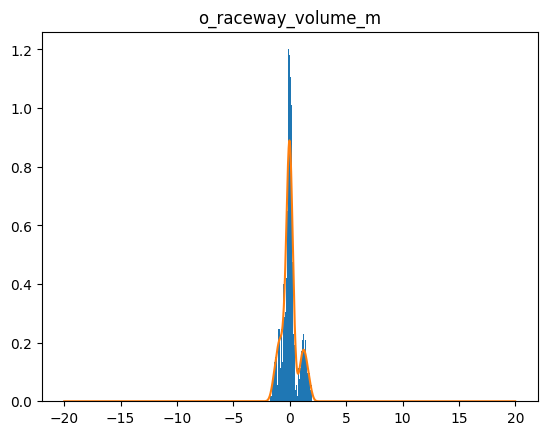

torch.Size([4000])
2651  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2652  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2653  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2654  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2655  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2656  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2657  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2658  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2659  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2660  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2661  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2662  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2663  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2664  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2665  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2666  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2667  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
2668  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2669  loss=  tensor(0.0317,

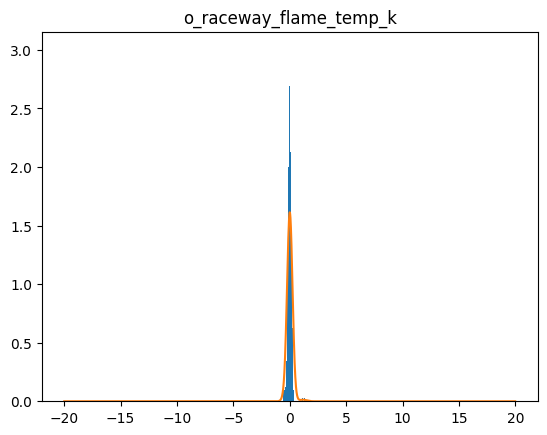

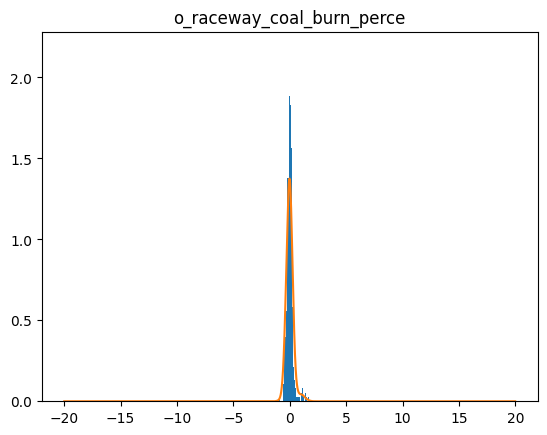

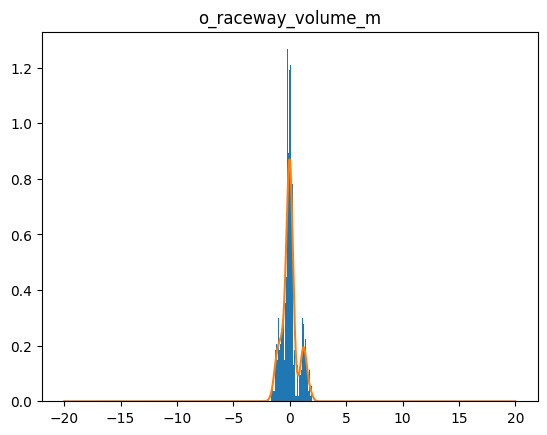

torch.Size([4000])
2701  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2702  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2703  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2704  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2705  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2706  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2707  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2708  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2709  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2710  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2711  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2712  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2713  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2714  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2715  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2716  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2717  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2718  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2719  loss=  tensor(0.0318,

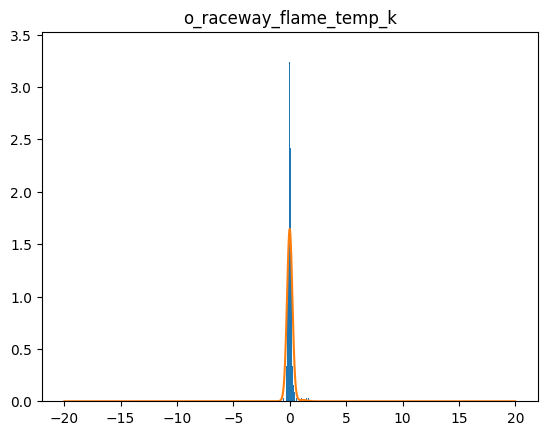

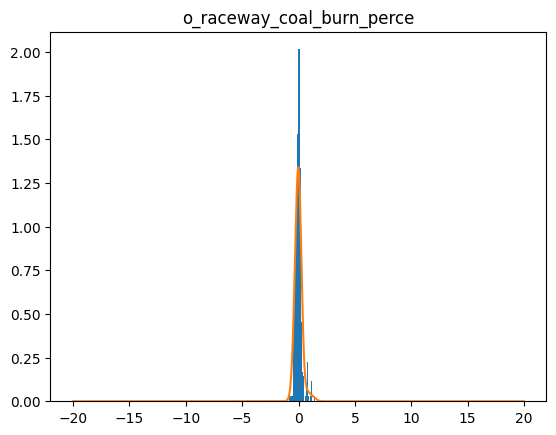

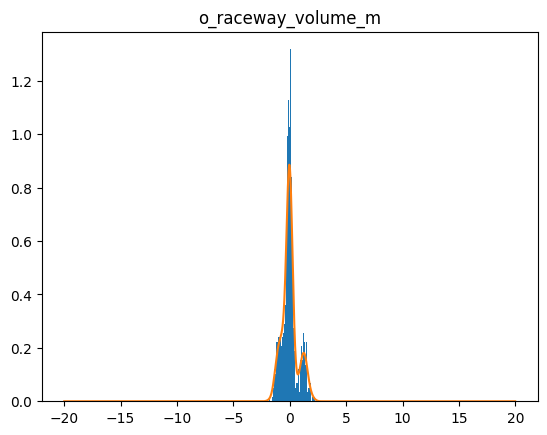

torch.Size([4000])
2751  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2752  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2753  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2754  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2755  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2756  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2757  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2758  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2759  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2760  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2761  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2762  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2763  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2764  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2765  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2766  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2767  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2768  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2769  loss=  tensor(0.0320,

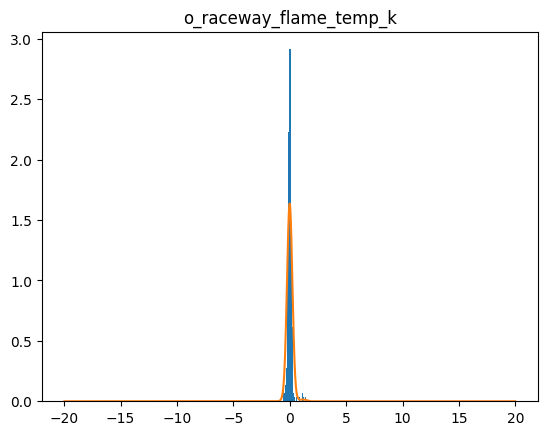

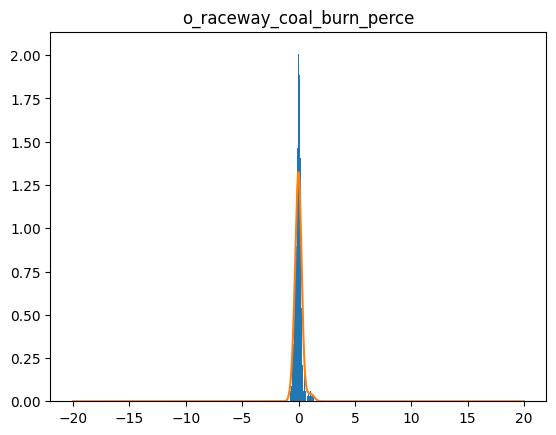

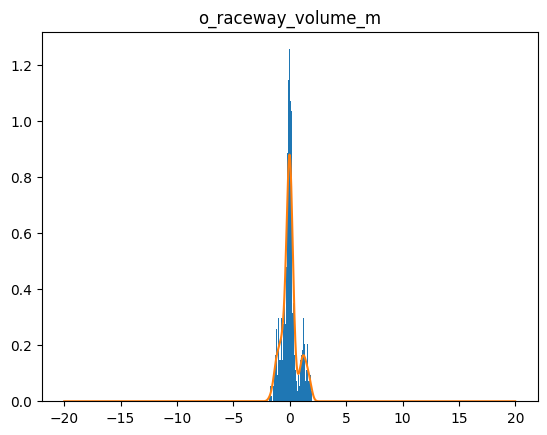

torch.Size([4000])
2801  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2802  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2803  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2804  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2805  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
2806  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2807  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2808  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2809  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2810  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2811  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2812  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2813  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2814  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2815  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2816  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2817  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2818  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2819  loss=  tensor(0.0314,

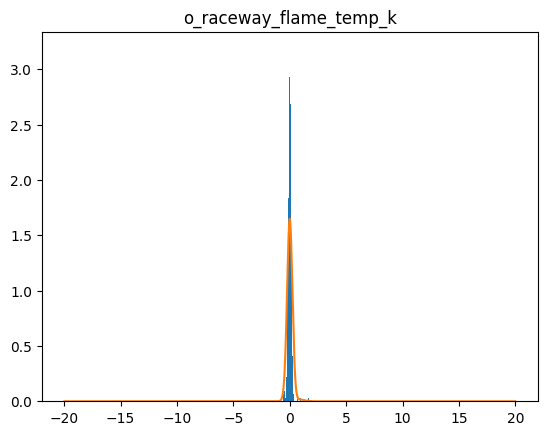

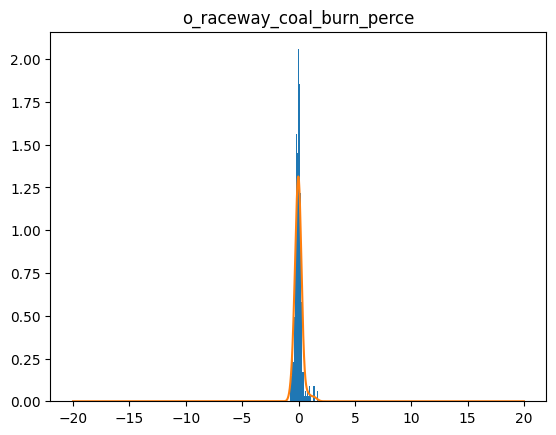

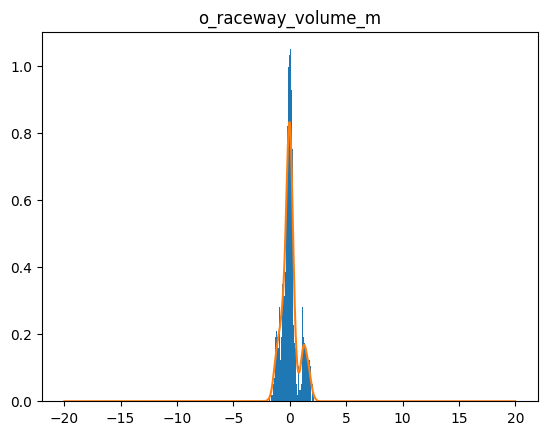

torch.Size([4000])
2851  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2852  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2853  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2854  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2855  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2856  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2857  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2858  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2859  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2860  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2861  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2862  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2863  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2864  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2865  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
2866  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2867  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2868  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2869  loss=  tensor(0.0313,

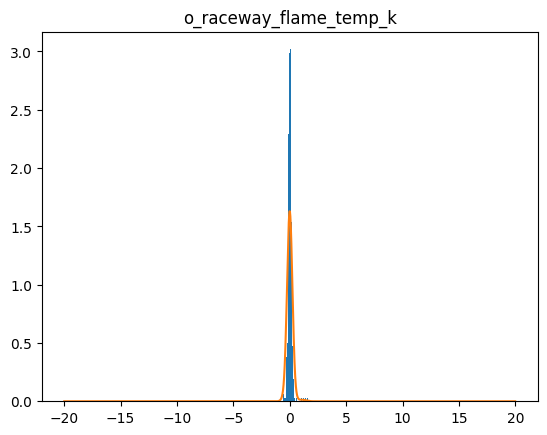

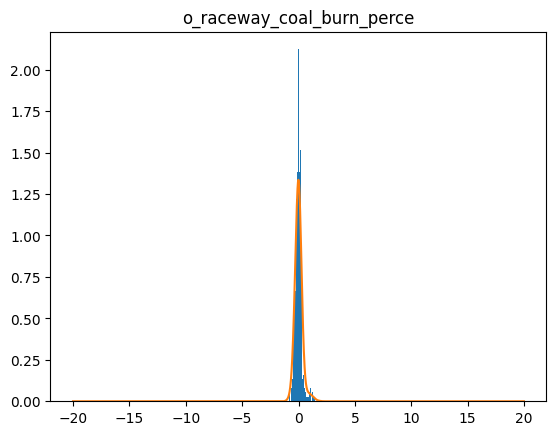

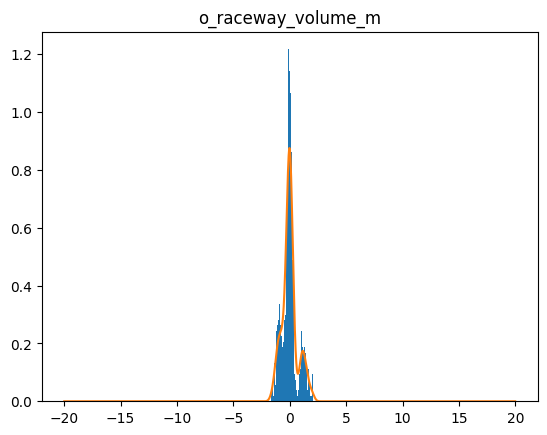

torch.Size([4000])
2901  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2902  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2903  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2904  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2905  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2906  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
2907  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2908  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2909  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
2910  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2911  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2912  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2913  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2914  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2915  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2916  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2917  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2918  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2919  loss=  tensor(0.0316,

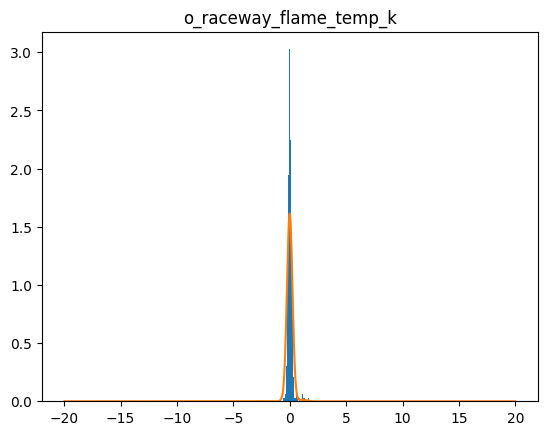

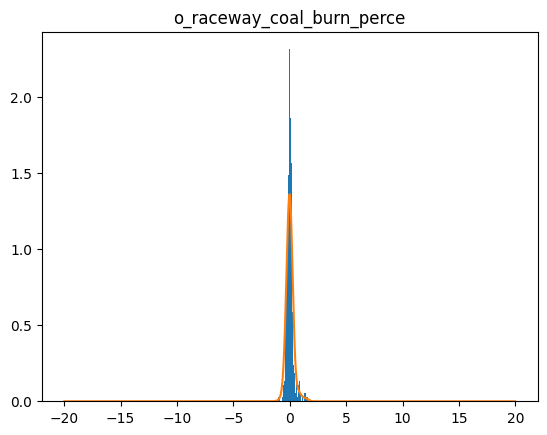

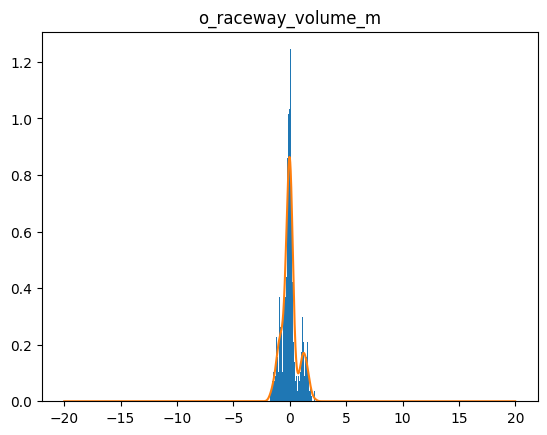

torch.Size([4000])
2951  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2952  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
2953  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
2954  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
2955  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
2956  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
2957  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2958  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
2959  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
2960  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2961  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
2962  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
2963  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
2964  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
2965  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2966  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
2967  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
2968  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
2969  loss=  tensor(0.0312,

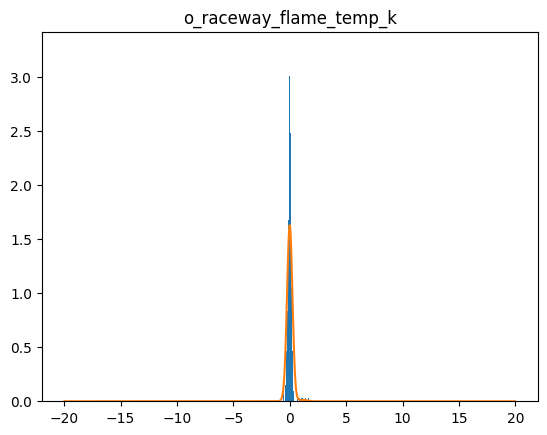

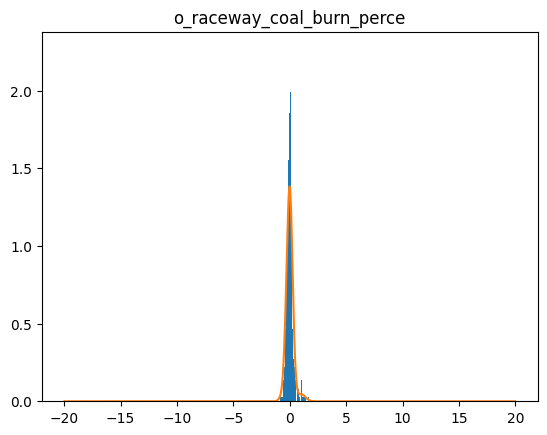

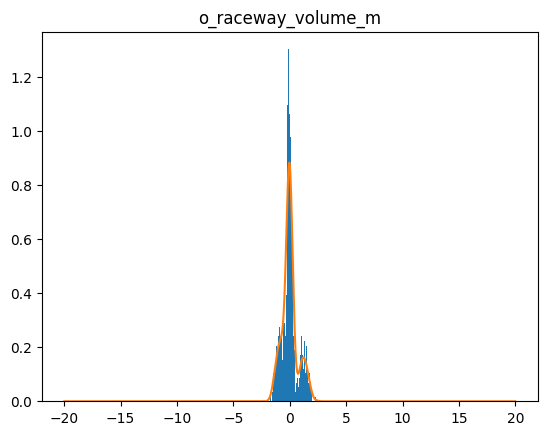

torch.Size([4000])
3001  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3002  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3003  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3004  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3005  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3006  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3007  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3008  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3009  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3010  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3011  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3012  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
3013  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3014  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3015  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3016  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3017  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3018  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
3019  loss=  tensor(0.0312,

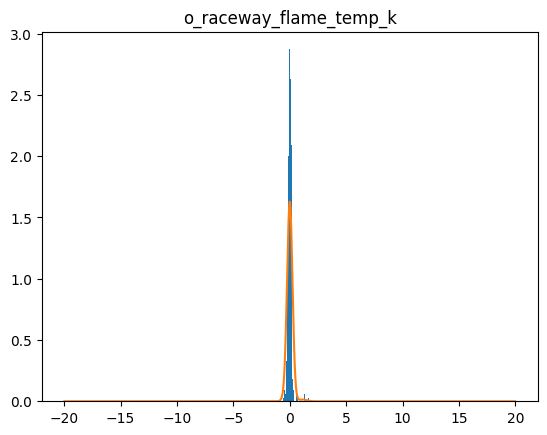

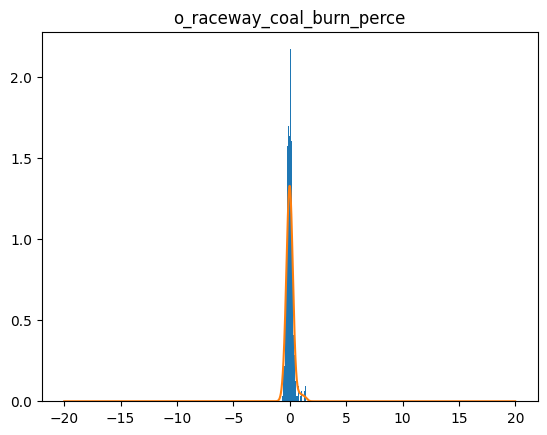

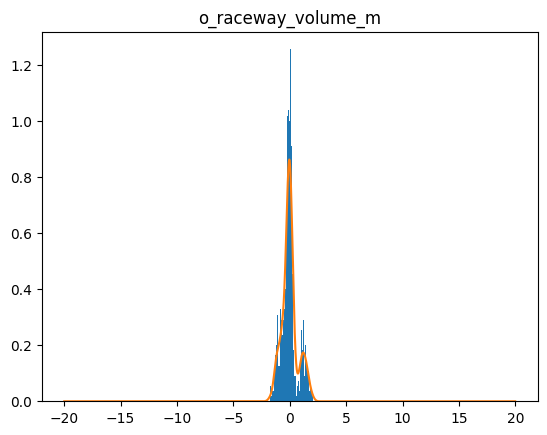

torch.Size([4000])
3051  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3052  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3053  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3054  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
3055  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3056  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3057  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3058  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
3059  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3060  loss=  tensor(0.0322, grad_fn=<MeanBackward0>)
3061  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3062  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3063  loss=  tensor(0.0321, grad_fn=<MeanBackward0>)
3064  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3065  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3066  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3067  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3068  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3069  loss=  tensor(0.0318,

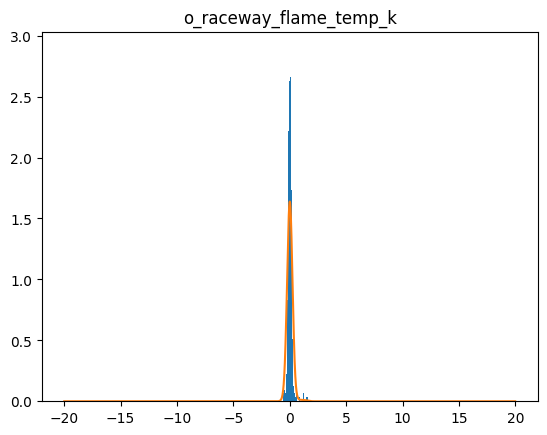

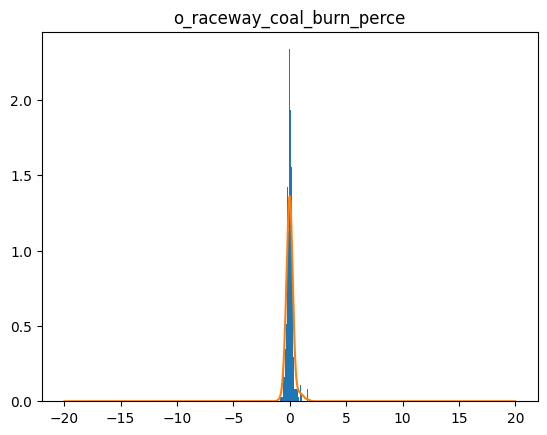

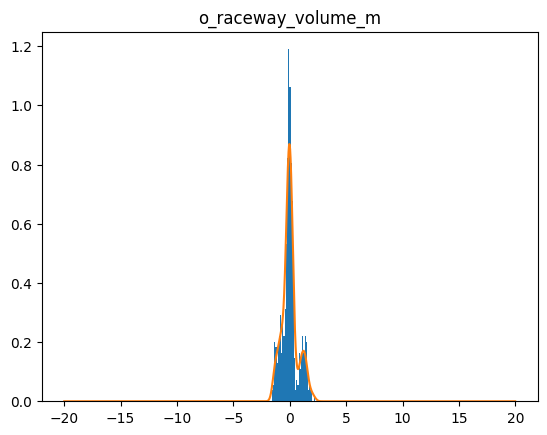

torch.Size([4000])
3101  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3102  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3103  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3104  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3105  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3106  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3107  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3108  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3109  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3110  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3111  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3112  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3113  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3114  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3115  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3116  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3117  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3118  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3119  loss=  tensor(0.0314,

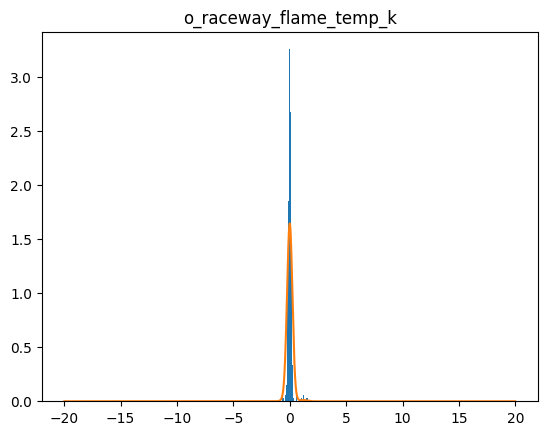

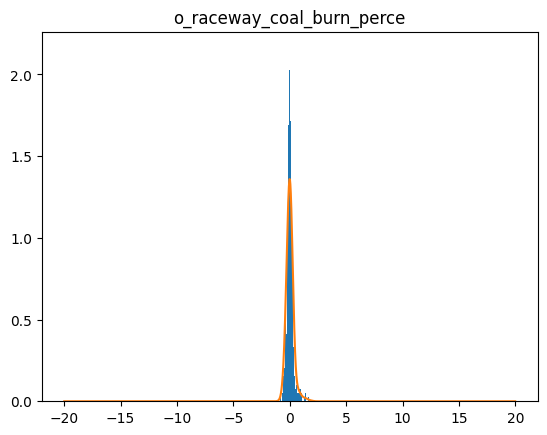

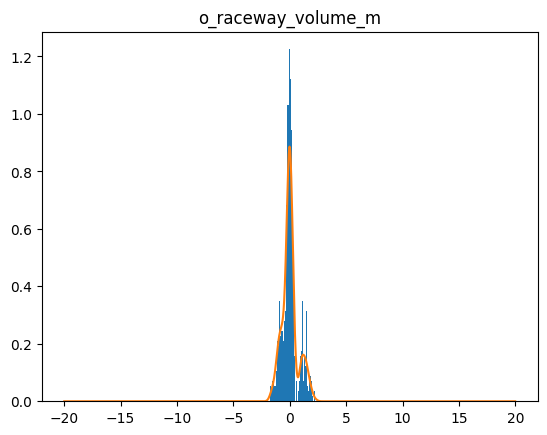

torch.Size([4000])
3151  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3152  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3153  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3154  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3155  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3156  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3157  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3158  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3159  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3160  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3161  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3162  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3163  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3164  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3165  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
3166  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3167  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3168  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3169  loss=  tensor(0.0315,

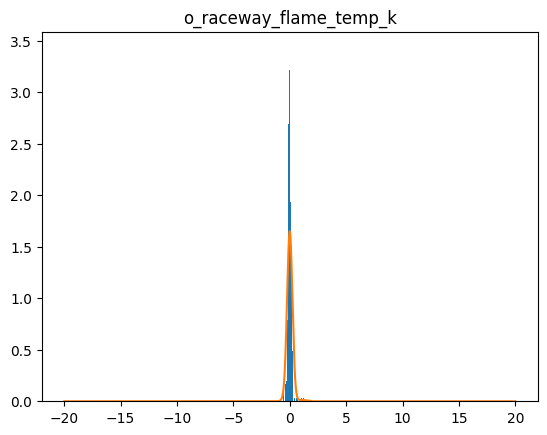

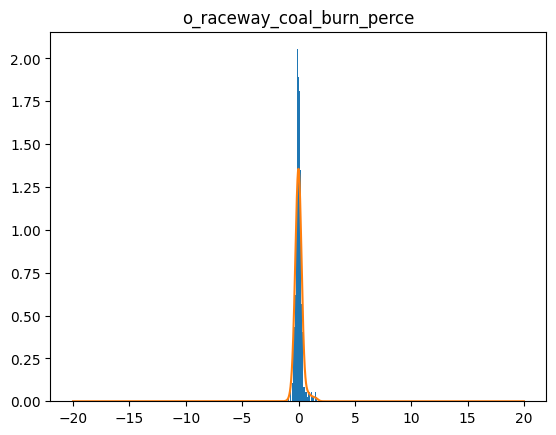

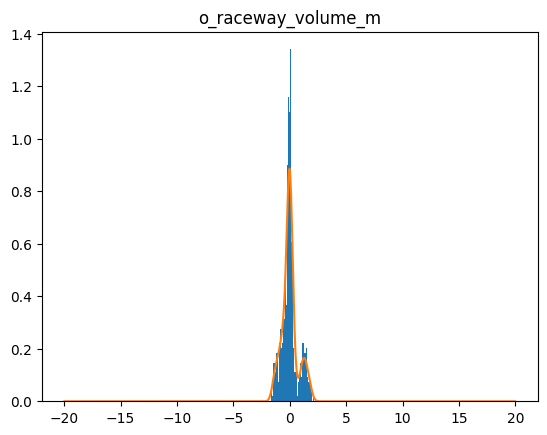

torch.Size([4000])
3201  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3202  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3203  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
3204  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3205  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3206  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3207  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3208  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3209  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3210  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3211  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3212  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3213  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3214  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3215  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3216  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3217  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3218  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3219  loss=  tensor(0.0317,

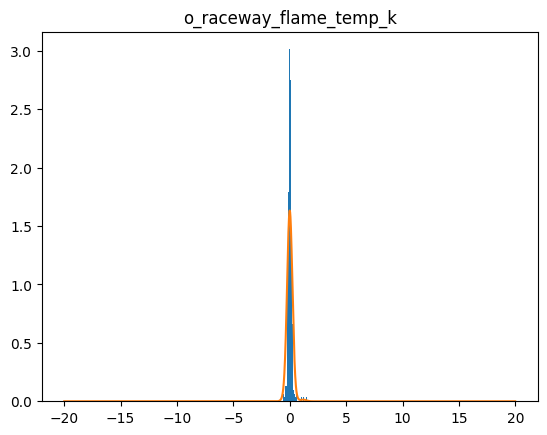

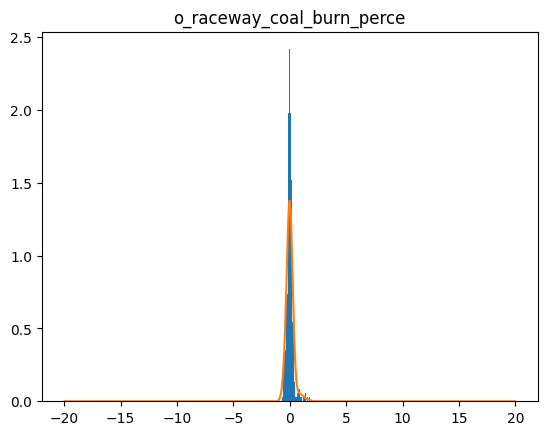

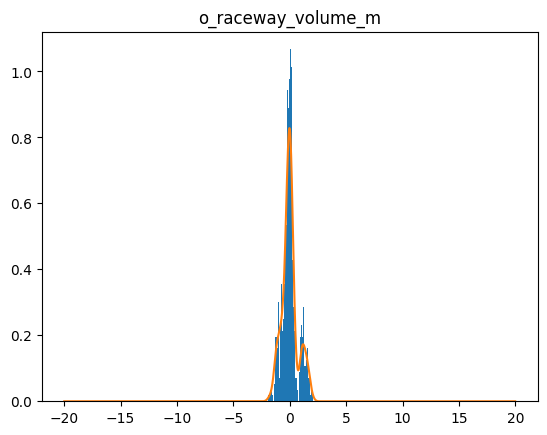

torch.Size([4000])
3251  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3252  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3253  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3254  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3255  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3256  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3257  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3258  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3259  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3260  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3261  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3262  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3263  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3264  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3265  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3266  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3267  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3268  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
3269  loss=  tensor(0.0315,

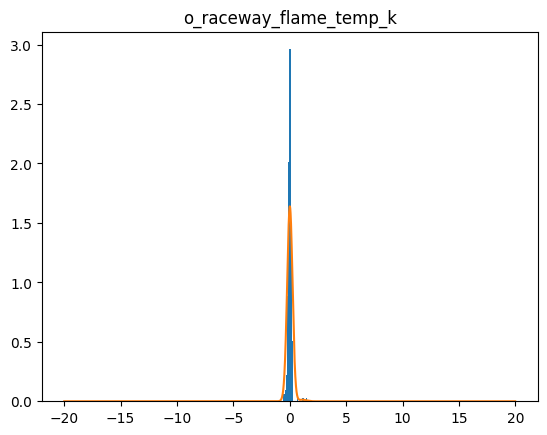

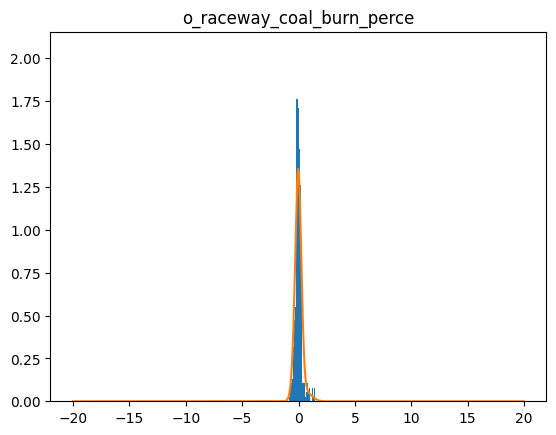

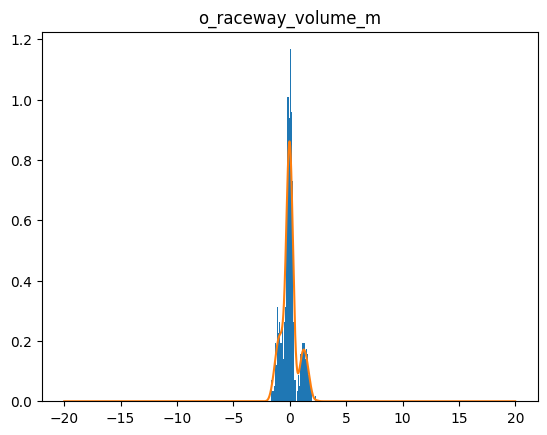

torch.Size([4000])
3301  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3302  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3303  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3304  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3305  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3306  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3307  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3308  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3309  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3310  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3311  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3312  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3313  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3314  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3315  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3316  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3317  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3318  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3319  loss=  tensor(0.0310,

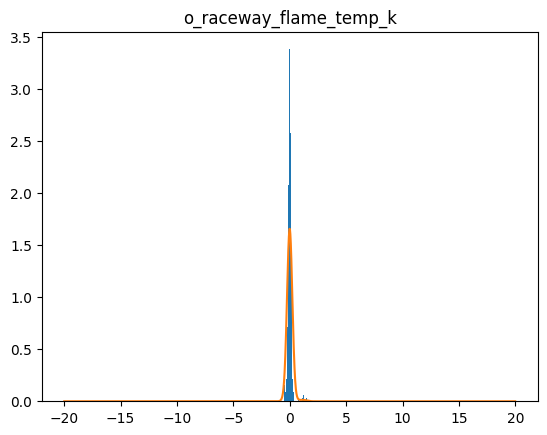

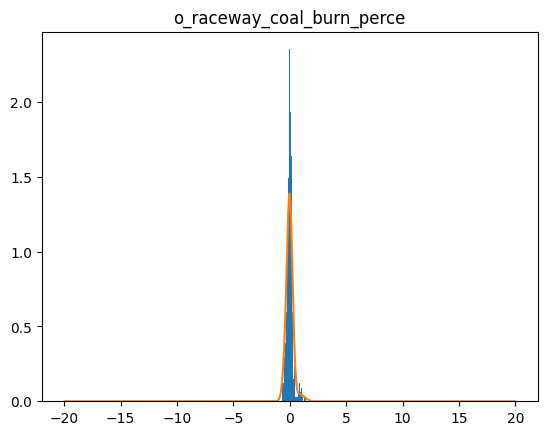

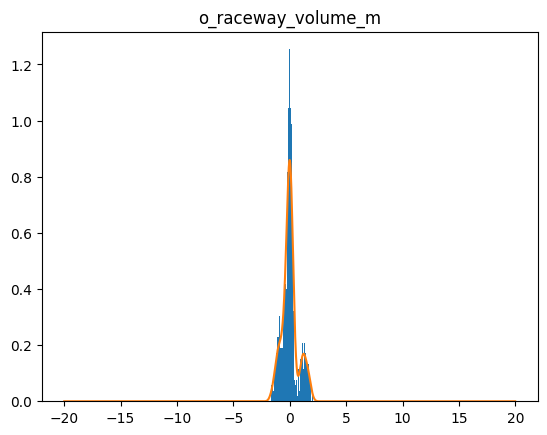

torch.Size([4000])
3351  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3352  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3353  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3354  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3355  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3356  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3357  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3358  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3359  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3360  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3361  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3362  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3363  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3364  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3365  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3366  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3367  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3368  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3369  loss=  tensor(0.0312,

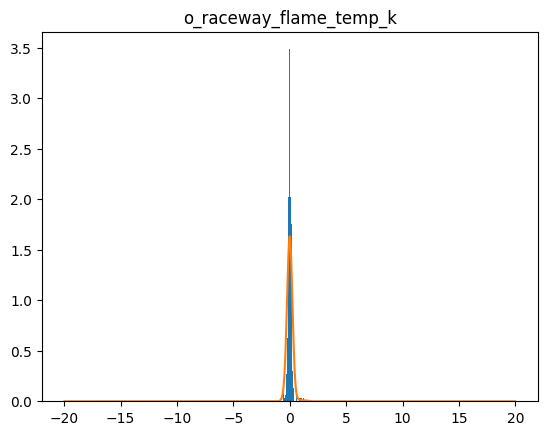

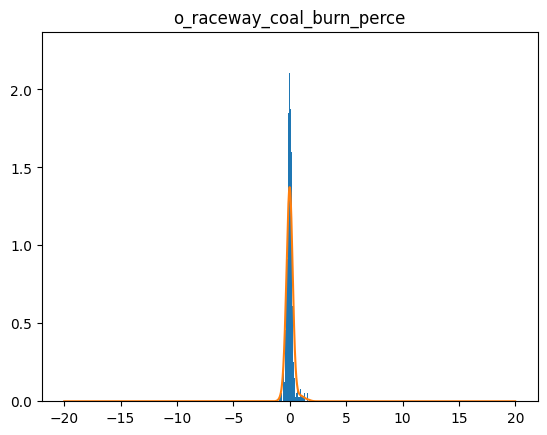

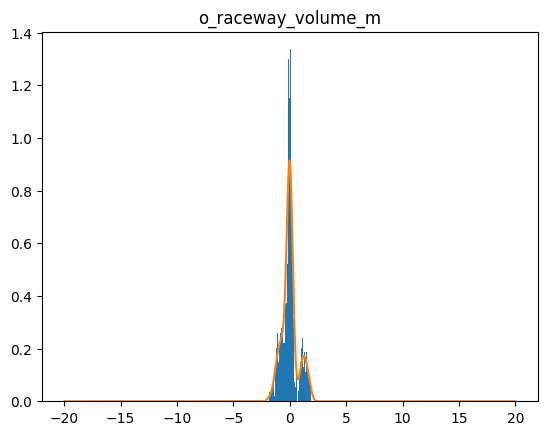

torch.Size([4000])
3401  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3402  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
3403  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3404  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3405  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3406  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3407  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3408  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3409  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3410  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3411  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3412  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3413  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3414  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3415  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3416  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3417  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3418  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3419  loss=  tensor(0.0316,

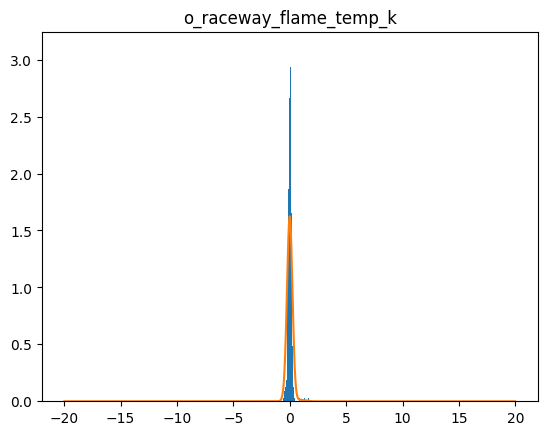

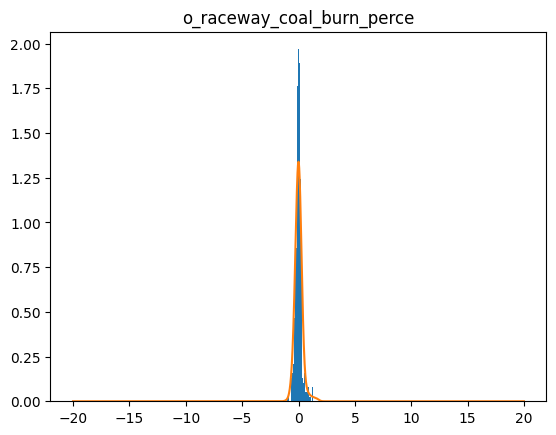

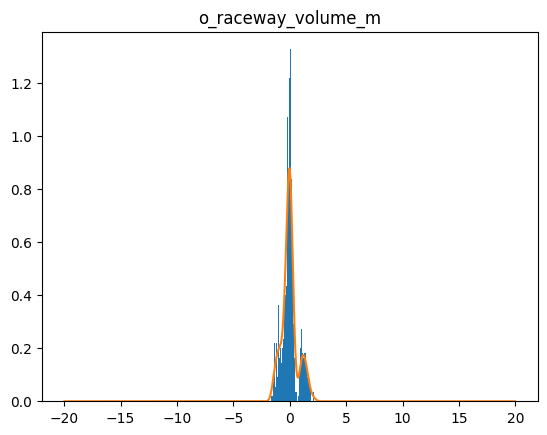

torch.Size([4000])
3451  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3452  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3453  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3454  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
3455  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3456  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3457  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3458  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3459  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3460  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3461  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3462  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3463  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3464  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3465  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3466  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3467  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3468  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3469  loss=  tensor(0.0313,

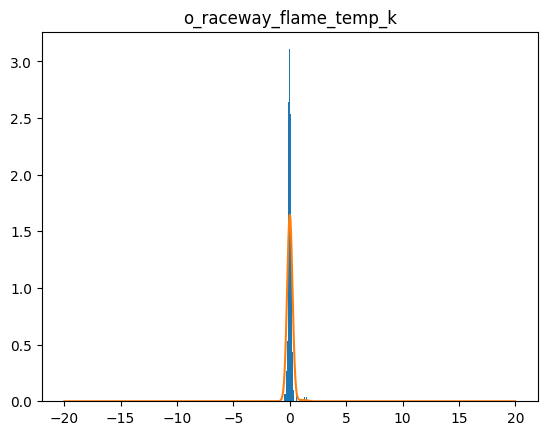

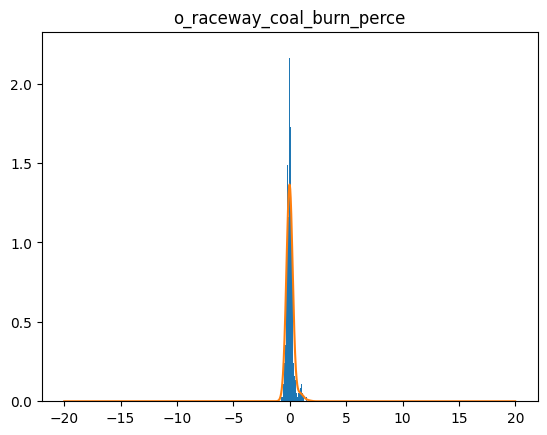

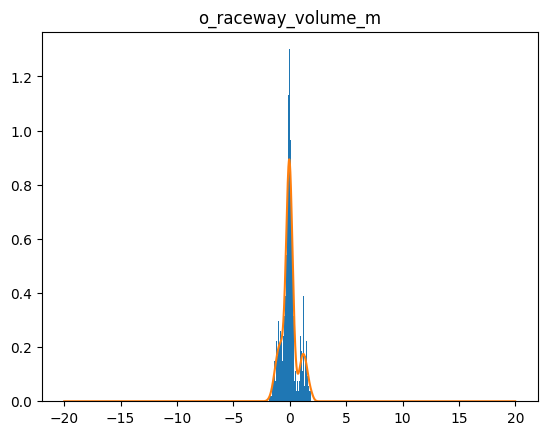

torch.Size([4000])
3501  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3502  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3503  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3504  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3505  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3506  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3507  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3508  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3509  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3510  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3511  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
3512  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3513  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3514  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3515  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3516  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3517  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3518  loss=  tensor(0.0320, grad_fn=<MeanBackward0>)
3519  loss=  tensor(0.0312,

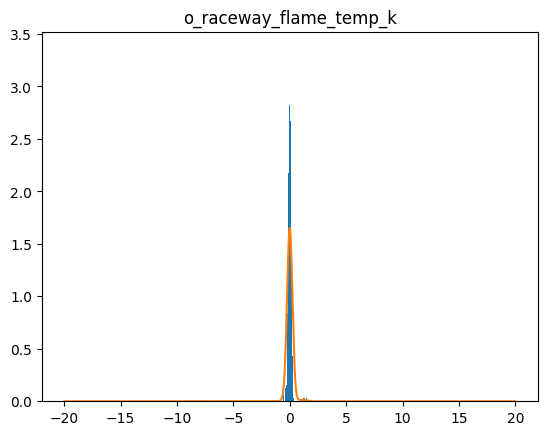

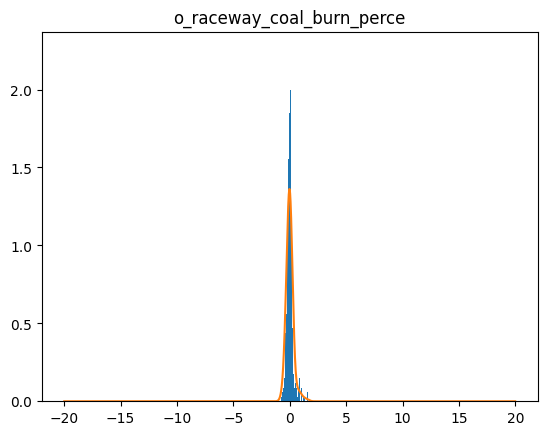

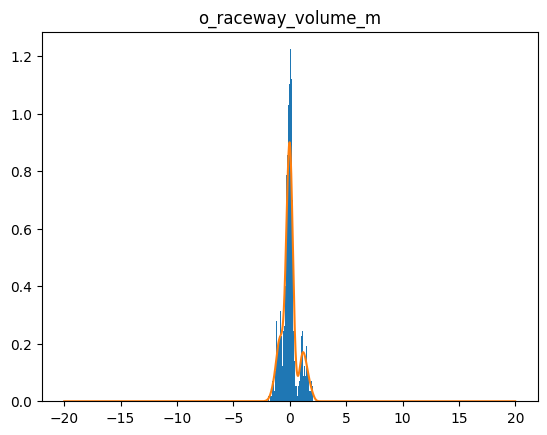

torch.Size([4000])
3551  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3552  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3553  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3554  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3555  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3556  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3557  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
3558  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3559  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3560  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3561  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3562  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3563  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3564  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3565  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3566  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3567  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3568  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3569  loss=  tensor(0.0311,

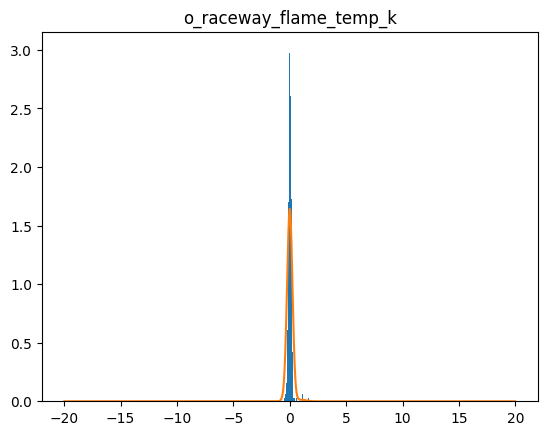

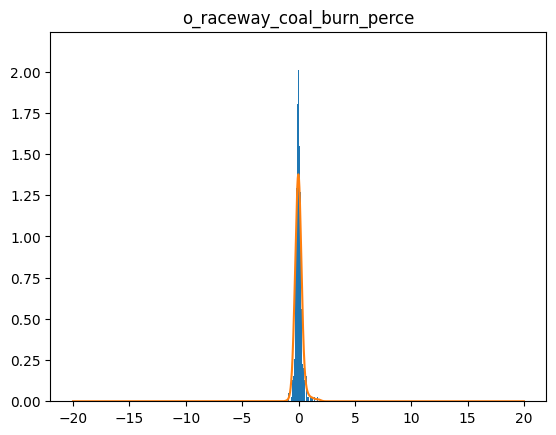

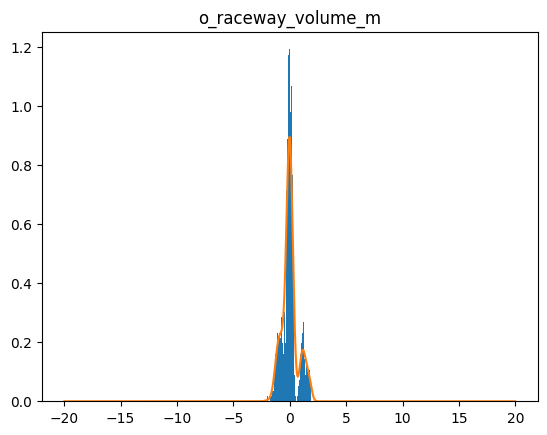

torch.Size([4000])
3601  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3602  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3603  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3604  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3605  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3606  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3607  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3608  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3609  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3610  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3611  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3612  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3613  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3614  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3615  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3616  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3617  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3618  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3619  loss=  tensor(0.0308,

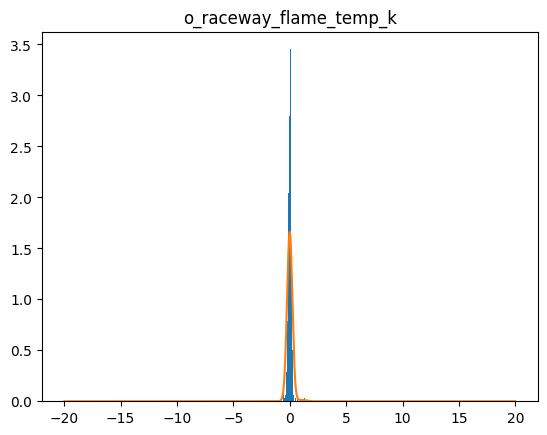

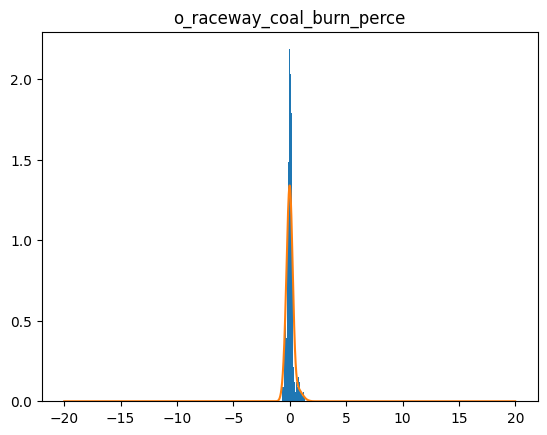

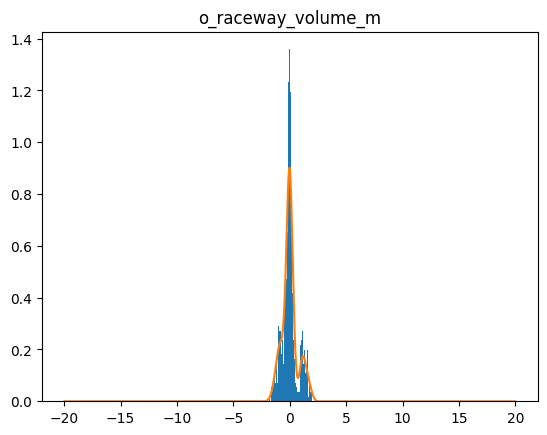

torch.Size([4000])
3651  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3652  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3653  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3654  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3655  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3656  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3657  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3658  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3659  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3660  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3661  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3662  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3663  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3664  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3665  loss=  tensor(0.0306, grad_fn=<MeanBackward0>)
3666  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3667  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3668  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3669  loss=  tensor(0.0309,

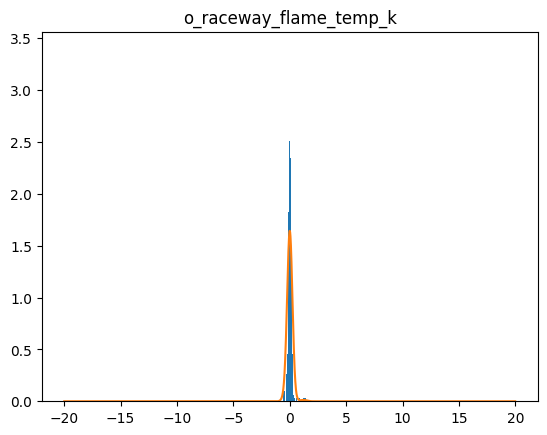

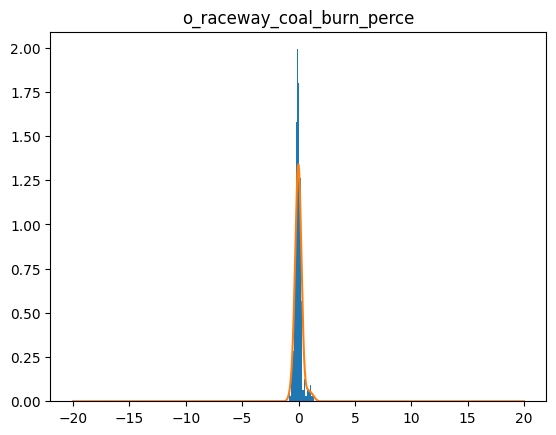

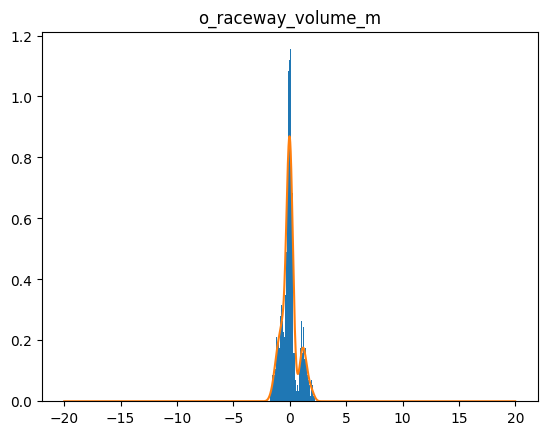

torch.Size([4000])
3701  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3702  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3703  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3704  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3705  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3706  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3707  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3708  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3709  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3710  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3711  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3712  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3713  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3714  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3715  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3716  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
3717  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3718  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3719  loss=  tensor(0.0315,

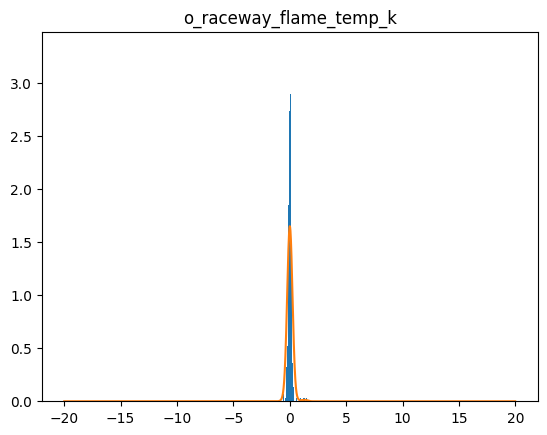

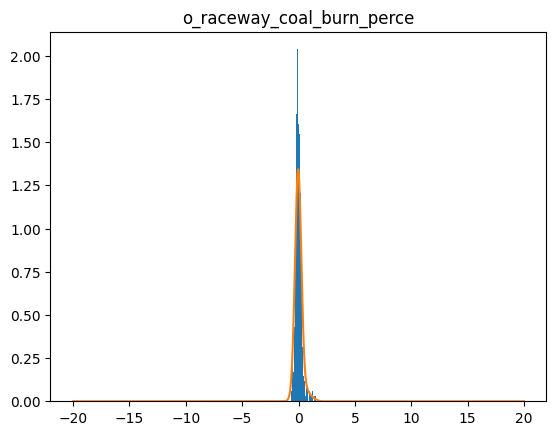

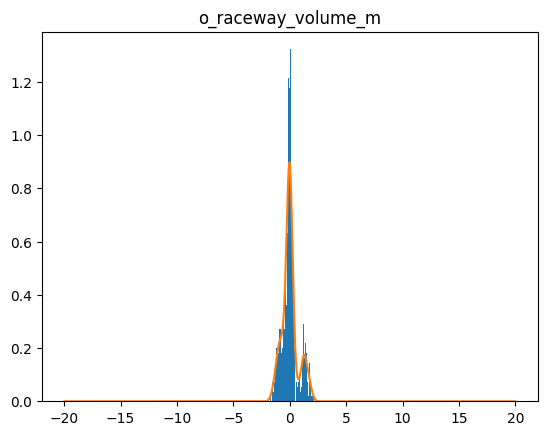

torch.Size([4000])
3751  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3752  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3753  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3754  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
3755  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3756  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3757  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3758  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3759  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3760  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3761  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3762  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3763  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3764  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3765  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3766  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3767  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3768  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3769  loss=  tensor(0.0316,

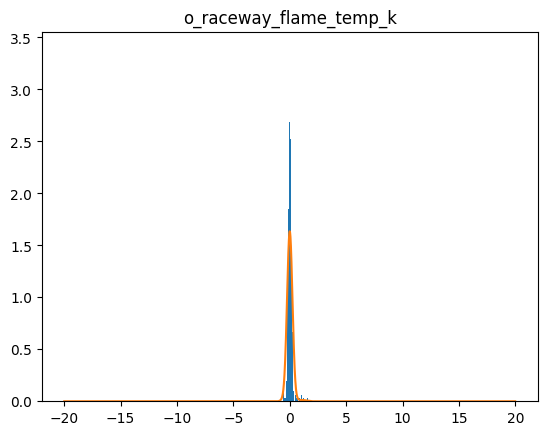

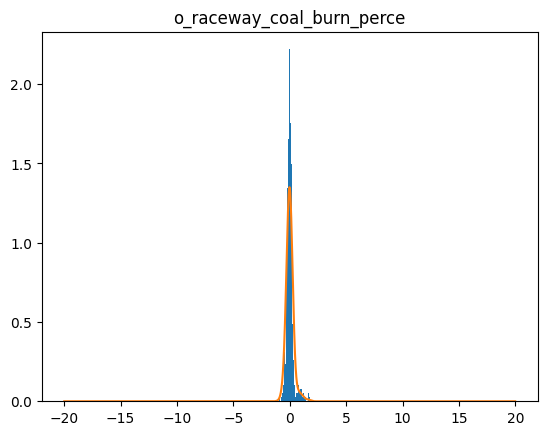

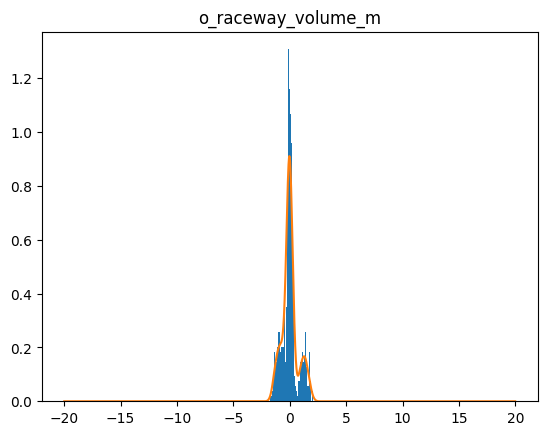

torch.Size([4000])
3801  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3802  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3803  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3804  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3805  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3806  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3807  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3808  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3809  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3810  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3811  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3812  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3813  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3814  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3815  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
3816  loss=  tensor(0.0307, grad_fn=<MeanBackward0>)
3817  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3818  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3819  loss=  tensor(0.0313,

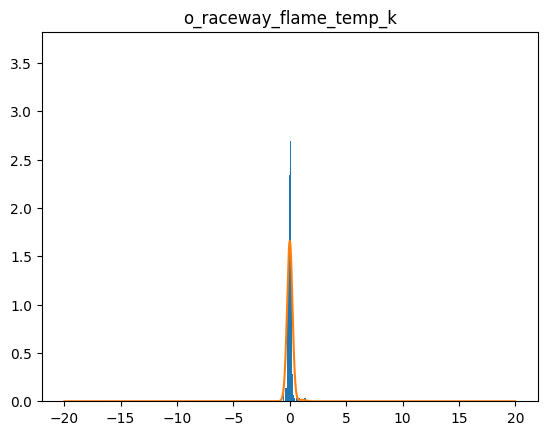

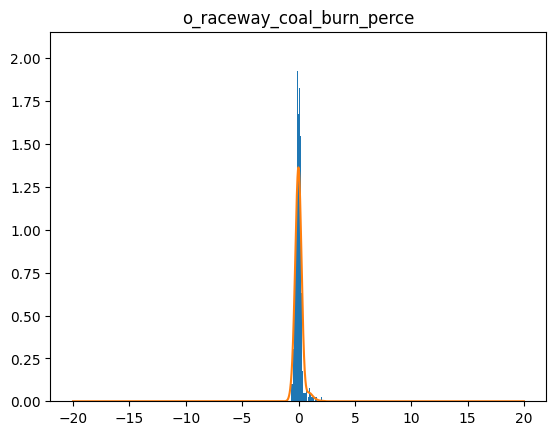

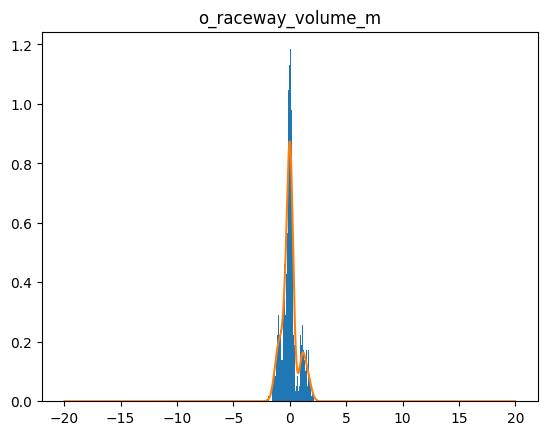

torch.Size([4000])
3851  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3852  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3853  loss=  tensor(0.0319, grad_fn=<MeanBackward0>)
3854  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3855  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3856  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3857  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3858  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3859  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3860  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3861  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
3862  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3863  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3864  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3865  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3866  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3867  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3868  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3869  loss=  tensor(0.0314,

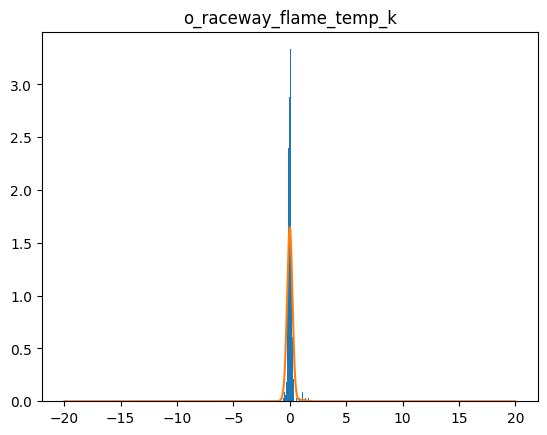

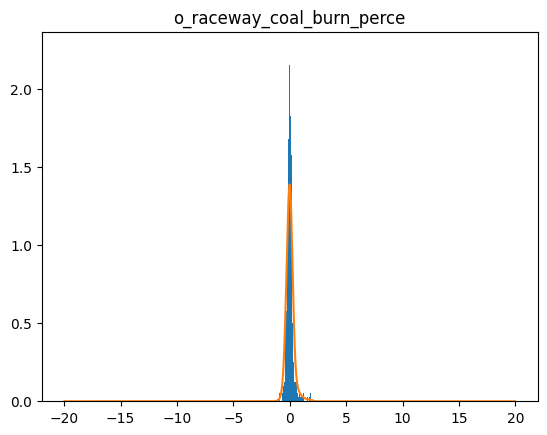

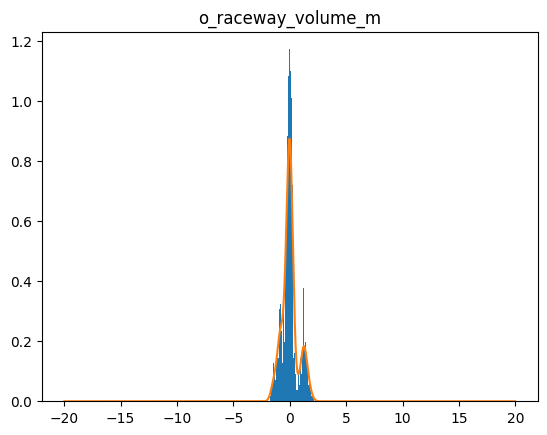

torch.Size([4000])
3901  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3902  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3903  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3904  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3905  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
3906  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3907  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3908  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3909  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3910  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3911  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3912  loss=  tensor(0.0318, grad_fn=<MeanBackward0>)
3913  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3914  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3915  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3916  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3917  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3918  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3919  loss=  tensor(0.0311,

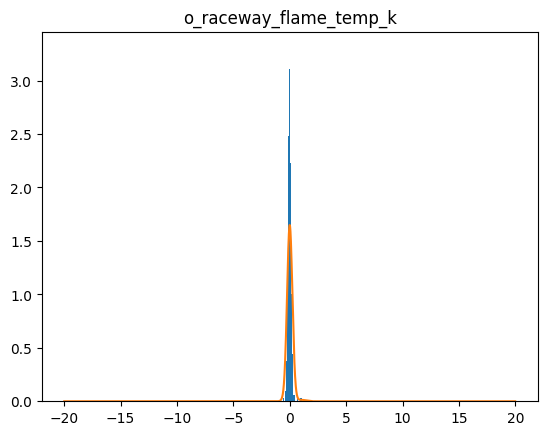

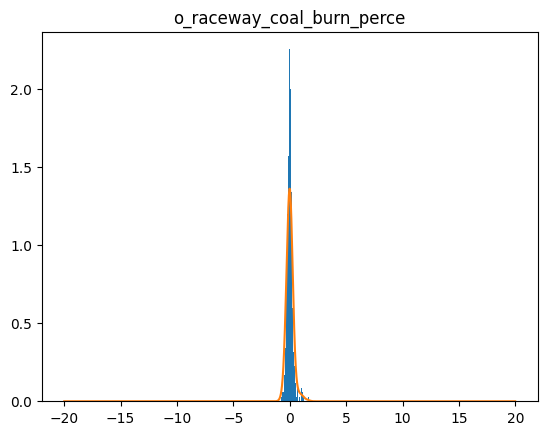

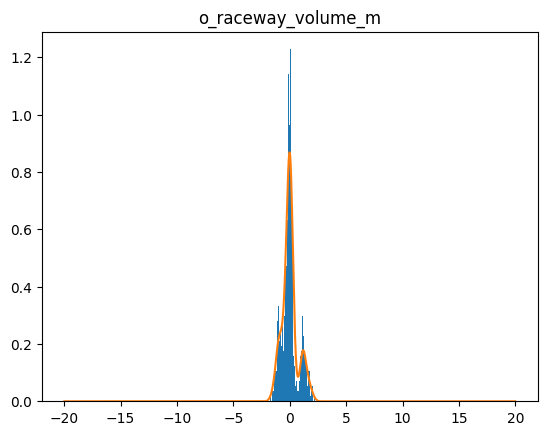

torch.Size([4000])
3951  loss=  tensor(0.0315, grad_fn=<MeanBackward0>)
3952  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3953  loss=  tensor(0.0314, grad_fn=<MeanBackward0>)
3954  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3955  loss=  tensor(0.0310, grad_fn=<MeanBackward0>)
3956  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3957  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3958  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3959  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3960  loss=  tensor(0.0312, grad_fn=<MeanBackward0>)
3961  loss=  tensor(0.0307, grad_fn=<MeanBackward0>)
3962  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3963  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
3964  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3965  loss=  tensor(0.0317, grad_fn=<MeanBackward0>)
3966  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
3967  loss=  tensor(0.0313, grad_fn=<MeanBackward0>)
3968  loss=  tensor(0.0316, grad_fn=<MeanBackward0>)
3969  loss=  tensor(0.0314,

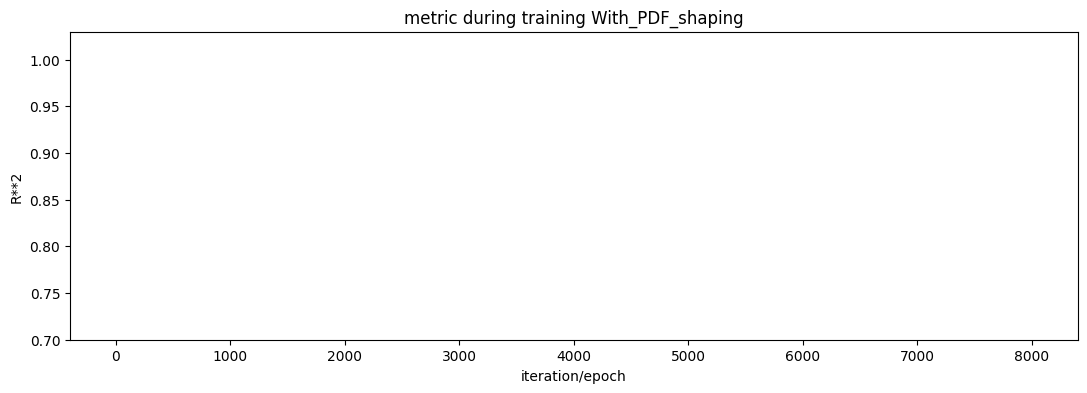

Training loss: tensor(0.2151, grad_fn=<MseLossBackward0>)
Training R**2: 0.584103177347125
Test loss - scaled: tensor(0.2069, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(915.8362, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.5942156363064167
Testing R**2 - descaled: 0.594215674688073
*****
*****
Testing R**2 - Output: 0 o_raceway_flame_temp_k 0.935454038418985
*****
*****
Testing R**2 - Output: 1 o_raceway_coal_burn_perce 0.8858343917203554
*****
*****
Testing R**2 - Output: 2 o_raceway_volume_m -0.03864140878346878


In [96]:

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)



opt         = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )

loss_fn     = F.mse_loss


fit_y_scaled_PDF(PDFshapingOBJ.N_EPOCHS, PDFshapingOBJ.N_EPOCHS_PDF, model, loss_fn, opt)

pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,       PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,     PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()   ))


PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [97]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])


**************************************************
preds, real
(2580.1558, 2583.367)
(90.41943, 91.07791)
(0.22024795, 0.2167488)
**************************************************
preds, real
(2318.0164, 2344.956)
(84.98136, 86.50982)
(0.2175564, 0.2167488)
**************************************************
preds, real
(2592.3916, 2621.923)
(101.49068, 100.0)
(0.19466469, 0.1965359)
**************************************************
preds, real
(2184.572, 2175.781)
(82.65926, 83.188614)
(0.2166161, 0.2167488)
**************************************************
preds, real
(2178.099, 2193.05)
(97.85306, 100.0)
(0.21490277, 0.2296868)
**************************************************
preds, real
(2321.2234, 2347.552)
(100.80226, 100.0)
(0.21419938, 0.1965359)
**************************************************
preds, real
(2264.8362, 2303.987)
(98.07512, 100.0)
(0.21211152, 0.1965359)
**************************************************
preds, real
(2279.9177, 2267.999)
(89.15355, 87.44452

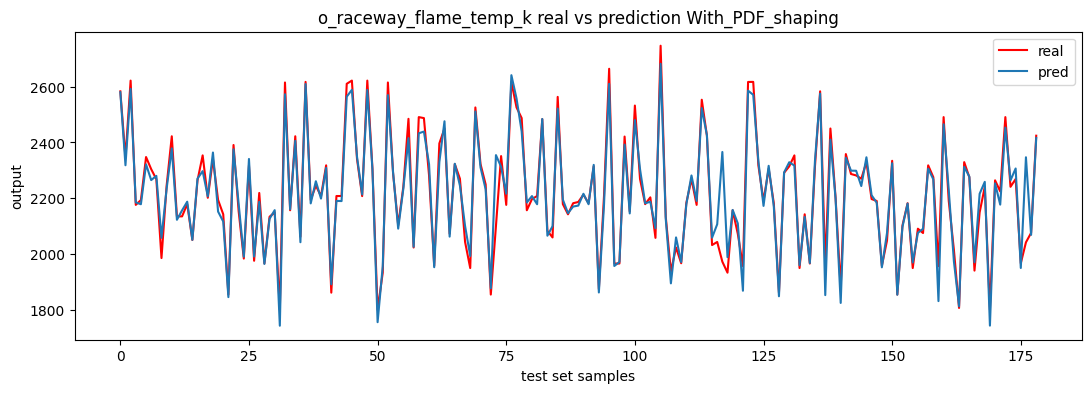

/Users/user/Desktop/DOE_CIVS/experiments/2023may/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


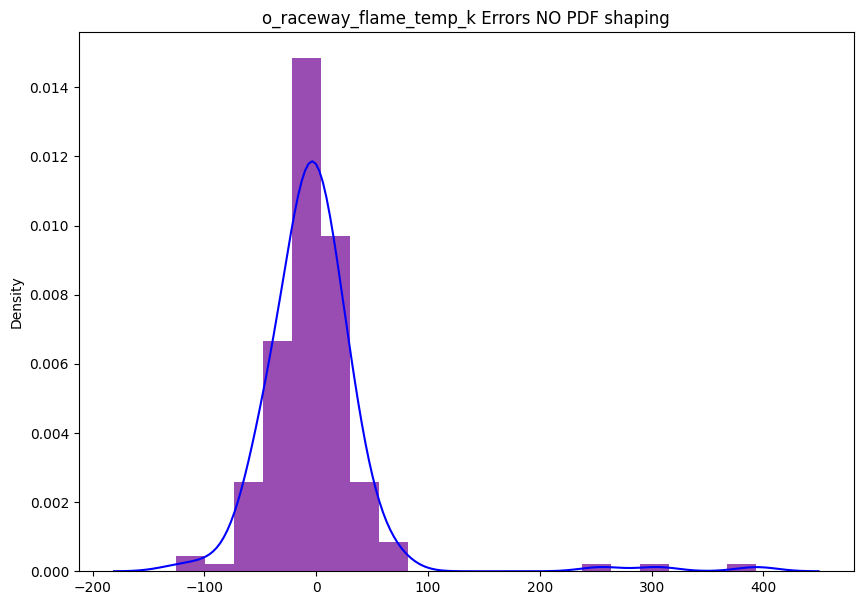

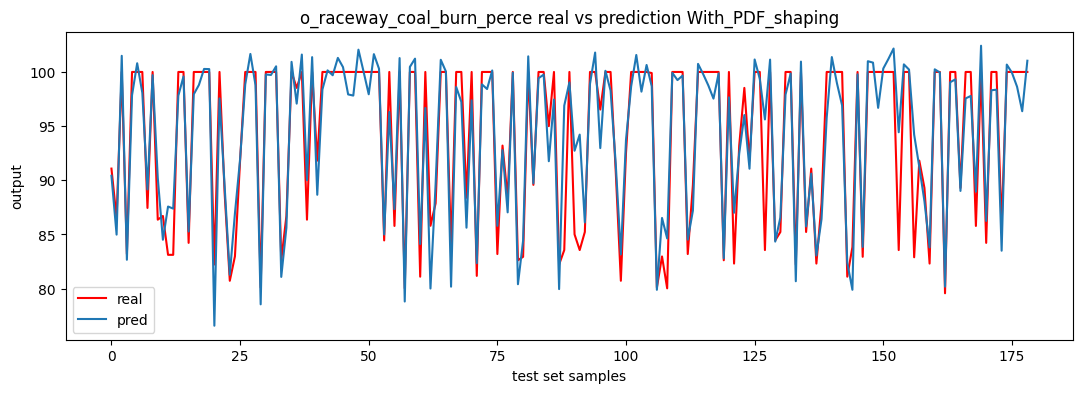

/Users/user/Desktop/DOE_CIVS/experiments/2023may/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


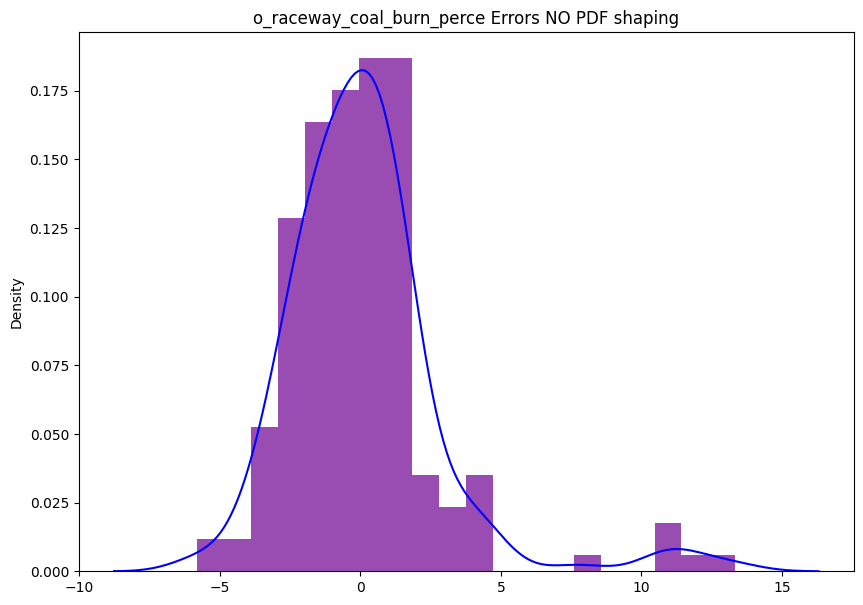

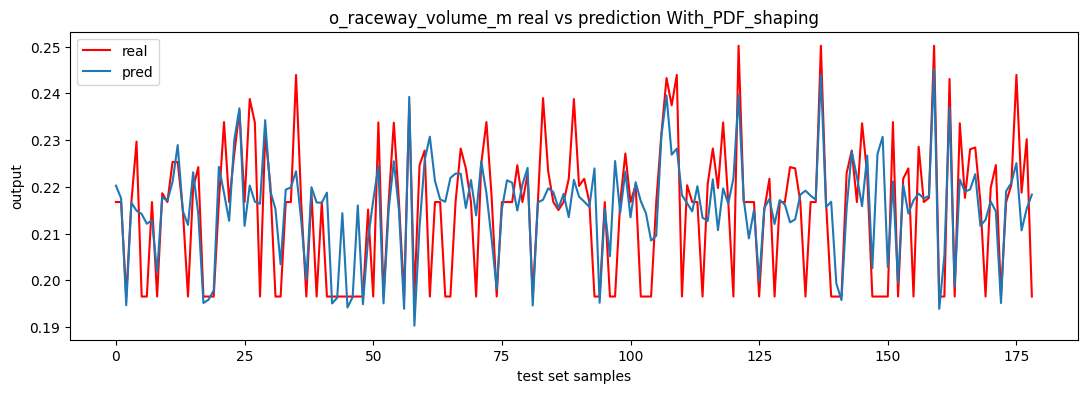

/Users/user/Desktop/DOE_CIVS/experiments/2023may/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


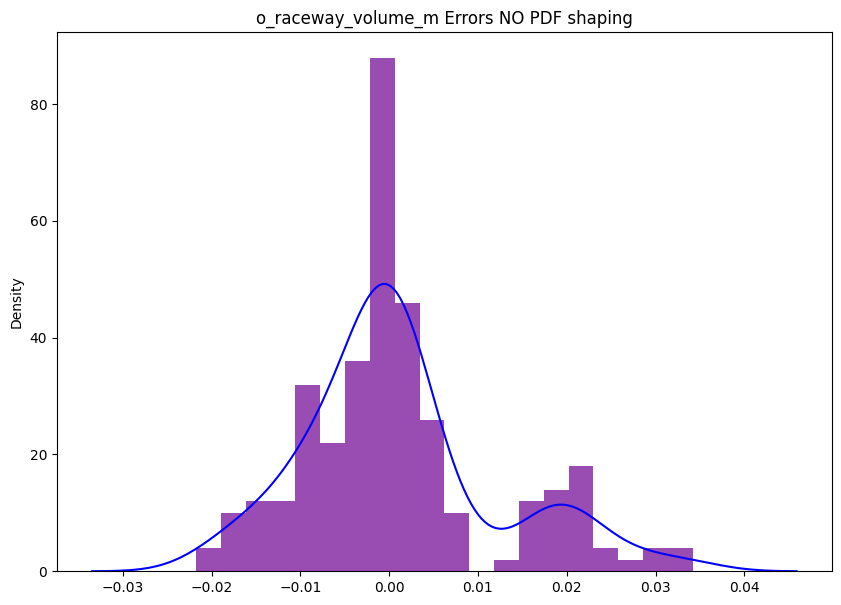

In [98]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )



## Export ONNX model


In [99]:

'''

model.eval()

dummy_input = torch.randn(1, 6)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/s536ShaftPDFshapingRC.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''


'\n\nmodel.eval()\n\ndummy_input = torch.randn(1, 6)\n\n\ninput_names = ["input1"]\noutput_names = ["output1", "output2"]\n\ntorch.onnx.export(\n  model, \n  dummy_input, \n  "ONNXmodels/s536ShaftPDFshapingRC.onnx", \n  verbose=False, \n  input_names  = input_names,\n  output_names = output_names\n)\n\n'